# Import Libraries

### Description of the changes:
 - Latent z l1 loss will be tracked during the run.  
 - Learning rate annealing turned on 
 - Added threshold in latent z loss

In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import os
import cv2

# for reading and displaying images
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import ReLU, Sigmoid, Sequential, Conv2d, Module 
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
torch.manual_seed(42) # different seeds will produce different color schemes in the autoencoder latent codes

In [2]:
! pwd

/home/arya1080/python_projects/CNN_TAM


# Load dataset

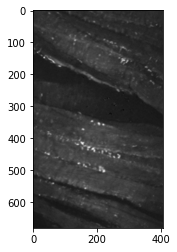

In [3]:
# loading dataset
data_dir = '/home/arya1080/engrprojects/WilsonGroup/TuCo/data/20210920 modify SVD_mods_Arya/620nm/'
filenames = os.listdir(data_dir)
# print(filenames)
img_stack = []
for files in filenames:
    img = io.imread(data_dir + files)
    plt.imshow(img[:,:,5], cmap='gray')
#     plt.show()
    img_stack.append(img)

In [4]:
# convert images to numpy arrays
img_stack = np.asarray(img_stack)
img_stack = img_stack.astype('float32')
print(img_stack.shape)

(25, 681, 406, 9)


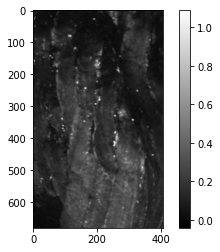

In [5]:
# choose a slice and show
plt.imshow(img_stack[2,:,:,5], cmap = 'gray')
plt.colorbar()
plt.show()

In [6]:
# get image height and width metrics
_, nx, ny, nch = img_stack.shape
print('img width = {}, img height = {}, img channels = {}'.format(nx, ny, nch))

img width = 681, img height = 406, img channels = 9


# Define model

In [7]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(nch, 64, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            
            # Defining another 2D convolution layer
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            
            # Defining another 2D convolution layer
            Conv2d(64, 64, kernel_size=1, stride=1),
            ReLU(inplace=True),
            
            # Defining another 2D convolution layer
            Conv2d(64, 64, kernel_size=1, stride=1),
            ReLU(inplace=True),
            
            # Defining another 2D convolution layer
            Conv2d(64, 3, kernel_size=1, stride=1),
            Sigmoid()
        )
        
        """The spectral autoencoder has a bottleneck in the number of channels instead of upsampling and downsampling layers"""
        self.cnn_spectral_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 64, kernel_size=1, stride=1),
            ReLU(inplace=True),
            
            # Defining another 2D convolution layer
            Conv2d(64, nch, kernel_size=1, stride=1),            
            
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.cnn_spectral_layers(x)
        return x
    
    # Latent space encoding output
    def forward_enc(self, x):
        z = self.cnn_layers(x)
        return z
    
    # Decoder output
    def decoder(self, z):
        y = self.cnn_spectral_layers(z)
        return y

In [8]:
# instantiate the model by calling the function
model = Net()
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
    (9): Sigmoid()
  )
  (cnn_spectral_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 9, kernel_size=(1, 1), stride=(1, 1))
  )
)


In [9]:
# define loss function
criterion = nn.L1Loss()

# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [10]:
# set the model training device
"""cuda:0 for GPU 0, cuda:1 for GPU1, cpu for CPU"""
device = 'cuda:0'
print(device)
model.to(device) # load the model in the training device

cuda:0


Net(
  (cnn_layers): Sequential(
    (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
    (9): Sigmoid()
  )
  (cnn_spectral_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 9, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [11]:
# prepare the input data before training
img_stack = torch.tensor(img_stack)
print(img_stack.shape)
img_stack = img_stack.to(device)

torch.Size([25, 681, 406, 9])


In [12]:
# define latent space visualization function
def visualize_z(ind):
    data = img_stack[ind,:,:,:]
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,:,:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
#     plt.figure(figsize=(10,10))
#     plt.imshow(img)
#     plt.show()
    return img

# Train model

  0%|                                          | 1/1000 [00:00<05:32,  3.00it/s]

Epoch: 1 	Training Loss Total: 0.205917 	L1 only: 0.157523 	Z Loss*Lambda: 0.048395


  0%|                                          | 2/1000 [00:00<05:16,  3.16it/s]

Epoch: 2 	Training Loss Total: 0.185424 	L1 only: 0.137625 	Z Loss*Lambda: 0.047799


  0%|▏                                         | 3/1000 [00:00<05:11,  3.20it/s]

Epoch: 3 	Training Loss Total: 0.167968 	L1 only: 0.121102 	Z Loss*Lambda: 0.046867


  0%|▏                                         | 4/1000 [00:01<05:09,  3.22it/s]

Epoch: 4 	Training Loss Total: 0.151489 	L1 only: 0.106856 	Z Loss*Lambda: 0.044632


  0%|▏                                         | 5/1000 [00:01<05:08,  3.23it/s]

Epoch: 5 	Training Loss Total: 0.134614 	L1 only: 0.094578 	Z Loss*Lambda: 0.040035


  1%|▎                                         | 6/1000 [00:01<05:06,  3.24it/s]

Epoch: 6 	Training Loss Total: 0.120177 	L1 only: 0.085187 	Z Loss*Lambda: 0.034991


  1%|▎                                         | 7/1000 [00:02<05:06,  3.24it/s]

Epoch: 7 	Training Loss Total: 0.111340 	L1 only: 0.078171 	Z Loss*Lambda: 0.033168


  1%|▎                                         | 8/1000 [00:02<05:05,  3.24it/s]

Epoch: 8 	Training Loss Total: 0.105359 	L1 only: 0.072733 	Z Loss*Lambda: 0.032626


  1%|▍                                         | 9/1000 [00:02<05:05,  3.25it/s]

Epoch: 9 	Training Loss Total: 0.099099 	L1 only: 0.067893 	Z Loss*Lambda: 0.031206


  1%|▍                                        | 10/1000 [00:03<05:04,  3.25it/s]

Epoch: 10 	Training Loss Total: 0.088367 	L1 only: 0.060827 	Z Loss*Lambda: 0.027540


  1%|▍                                        | 11/1000 [00:03<05:04,  3.25it/s]

Epoch: 11 	Training Loss Total: 0.080561 	L1 only: 0.055914 	Z Loss*Lambda: 0.024646


  1%|▍                                        | 12/1000 [00:03<05:04,  3.25it/s]

Epoch: 12 	Training Loss Total: 0.076611 	L1 only: 0.052863 	Z Loss*Lambda: 0.023749


  1%|▌                                        | 13/1000 [00:04<05:03,  3.25it/s]

Epoch: 13 	Training Loss Total: 0.073710 	L1 only: 0.050474 	Z Loss*Lambda: 0.023236


  1%|▌                                        | 14/1000 [00:04<05:03,  3.25it/s]

Epoch: 14 	Training Loss Total: 0.071111 	L1 only: 0.048215 	Z Loss*Lambda: 0.022896


  2%|▌                                        | 15/1000 [00:04<05:03,  3.25it/s]

Epoch: 15 	Training Loss Total: 0.068618 	L1 only: 0.045936 	Z Loss*Lambda: 0.022682


  2%|▋                                        | 16/1000 [00:04<05:03,  3.25it/s]

Epoch: 16 	Training Loss Total: 0.066075 	L1 only: 0.043585 	Z Loss*Lambda: 0.022490


  2%|▋                                        | 17/1000 [00:05<05:02,  3.25it/s]

Epoch: 17 	Training Loss Total: 0.063472 	L1 only: 0.041190 	Z Loss*Lambda: 0.022282


  2%|▋                                        | 18/1000 [00:05<05:02,  3.25it/s]

Epoch: 18 	Training Loss Total: 0.060998 	L1 only: 0.038934 	Z Loss*Lambda: 0.022063


  2%|▊                                        | 19/1000 [00:05<05:02,  3.25it/s]

Epoch: 19 	Training Loss Total: 0.058788 	L1 only: 0.036986 	Z Loss*Lambda: 0.021802


  2%|▊                                        | 20/1000 [00:06<05:01,  3.25it/s]

Epoch: 20 	Training Loss Total: 0.056829 	L1 only: 0.035361 	Z Loss*Lambda: 0.021468


  2%|▊                                        | 21/1000 [00:06<05:01,  3.24it/s]

Epoch: 21 	Training Loss Total: 0.055054 	L1 only: 0.033978 	Z Loss*Lambda: 0.021076


  2%|▉                                        | 22/1000 [00:06<05:01,  3.25it/s]

Epoch: 22 	Training Loss Total: 0.053358 	L1 only: 0.032708 	Z Loss*Lambda: 0.020650


  2%|▉                                        | 23/1000 [00:07<05:00,  3.25it/s]

Epoch: 23 	Training Loss Total: 0.051761 	L1 only: 0.031565 	Z Loss*Lambda: 0.020196


  2%|▉                                        | 24/1000 [00:07<05:00,  3.24it/s]

Epoch: 24 	Training Loss Total: 0.050410 	L1 only: 0.030665 	Z Loss*Lambda: 0.019745


  2%|█                                        | 25/1000 [00:07<05:00,  3.24it/s]

Epoch: 25 	Training Loss Total: 0.049162 	L1 only: 0.029843 	Z Loss*Lambda: 0.019319


  3%|█                                        | 26/1000 [00:08<05:00,  3.24it/s]

Epoch: 26 	Training Loss Total: 0.047929 	L1 only: 0.029025 	Z Loss*Lambda: 0.018904


  3%|█                                        | 27/1000 [00:08<04:59,  3.24it/s]

Epoch: 27 	Training Loss Total: 0.046720 	L1 only: 0.028223 	Z Loss*Lambda: 0.018497


  3%|█▏                                       | 28/1000 [00:08<04:59,  3.24it/s]

Epoch: 28 	Training Loss Total: 0.045547 	L1 only: 0.027452 	Z Loss*Lambda: 0.018095


  3%|█▏                                       | 29/1000 [00:08<04:59,  3.24it/s]

Epoch: 29 	Training Loss Total: 0.044416 	L1 only: 0.026731 	Z Loss*Lambda: 0.017686


  3%|█▏                                       | 30/1000 [00:09<04:58,  3.24it/s]

Epoch: 30 	Training Loss Total: 0.043265 	L1 only: 0.025977 	Z Loss*Lambda: 0.017289


  3%|█▎                                       | 31/1000 [00:09<04:58,  3.24it/s]

Epoch: 31 	Training Loss Total: 0.042203 	L1 only: 0.025310 	Z Loss*Lambda: 0.016893


  3%|█▎                                       | 32/1000 [00:09<04:58,  3.24it/s]

Epoch: 32 	Training Loss Total: 0.041186 	L1 only: 0.024679 	Z Loss*Lambda: 0.016507


  3%|█▎                                       | 33/1000 [00:10<04:58,  3.24it/s]

Epoch: 33 	Training Loss Total: 0.040239 	L1 only: 0.024118 	Z Loss*Lambda: 0.016121


  3%|█▍                                       | 34/1000 [00:10<04:57,  3.24it/s]

Epoch: 34 	Training Loss Total: 0.039300 	L1 only: 0.023557 	Z Loss*Lambda: 0.015743


  4%|█▍                                       | 35/1000 [00:10<04:57,  3.24it/s]

Epoch: 35 	Training Loss Total: 0.038352 	L1 only: 0.022970 	Z Loss*Lambda: 0.015382


  4%|█▍                                       | 36/1000 [00:11<04:57,  3.24it/s]

Epoch: 36 	Training Loss Total: 0.037444 	L1 only: 0.022417 	Z Loss*Lambda: 0.015027


  4%|█▌                                       | 37/1000 [00:11<04:56,  3.24it/s]

Epoch: 37 	Training Loss Total: 0.036576 	L1 only: 0.021903 	Z Loss*Lambda: 0.014673


  4%|█▌                                       | 38/1000 [00:11<04:56,  3.24it/s]

Epoch: 38 	Training Loss Total: 0.035748 	L1 only: 0.021428 	Z Loss*Lambda: 0.014319


  4%|█▌                                       | 39/1000 [00:12<04:56,  3.24it/s]

Epoch: 39 	Training Loss Total: 0.034925 	L1 only: 0.020954 	Z Loss*Lambda: 0.013970


  4%|█▋                                       | 40/1000 [00:12<04:56,  3.24it/s]

Epoch: 40 	Training Loss Total: 0.033736 	L1 only: 0.020492 	Z Loss*Lambda: 0.013639


  4%|█▋                                       | 41/1000 [00:12<04:56,  3.24it/s]

Epoch: 41 	Training Loss Total: 0.032915 	L1 only: 0.019983 	Z Loss*Lambda: 0.013316


  4%|█▋                                       | 42/1000 [00:12<04:55,  3.24it/s]

Epoch: 42 	Training Loss Total: 0.032137 	L1 only: 0.019517 	Z Loss*Lambda: 0.012991


  4%|█▊                                       | 43/1000 [00:13<04:55,  3.24it/s]

Epoch: 43 	Training Loss Total: 0.031025 	L1 only: 0.019085 	Z Loss*Lambda: 0.012689


  4%|█▊                                       | 44/1000 [00:13<04:55,  3.24it/s]

Epoch: 44 	Training Loss Total: 0.029165 	L1 only: 0.018650 	Z Loss*Lambda: 0.012416


  4%|█▊                                       | 45/1000 [00:13<04:55,  3.24it/s]

Epoch: 45 	Training Loss Total: 0.028562 	L1 only: 0.018219 	Z Loss*Lambda: 0.012208


  5%|█▉                                       | 46/1000 [00:14<04:54,  3.24it/s]

Epoch: 46 	Training Loss Total: 0.027525 	L1 only: 0.017763 	Z Loss*Lambda: 0.011998


  5%|█▉                                       | 47/1000 [00:14<04:54,  3.24it/s]

Epoch: 47 	Training Loss Total: 0.027012 	L1 only: 0.017402 	Z Loss*Lambda: 0.011802


  5%|█▉                                       | 48/1000 [00:14<04:54,  3.24it/s]

Epoch: 48 	Training Loss Total: 0.026471 	L1 only: 0.017018 	Z Loss*Lambda: 0.011606


  5%|██                                       | 49/1000 [00:15<04:54,  3.23it/s]

Epoch: 49 	Training Loss Total: 0.025549 	L1 only: 0.016640 	Z Loss*Lambda: 0.011426
Epoch: 50 	Training Loss Total: 0.024344 	L1 only: 0.016356 	Z Loss*Lambda: 0.011261


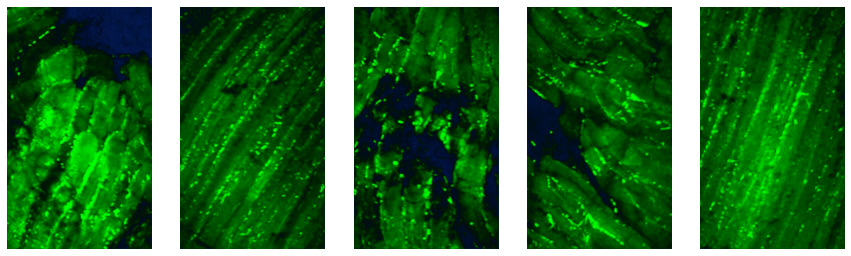

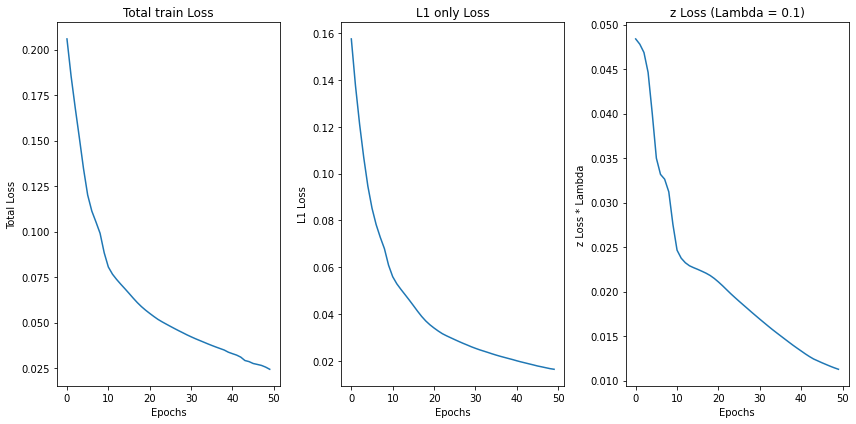

  5%|██                                       | 51/1000 [00:16<06:33,  2.41it/s]

Epoch: 51 	Training Loss Total: 0.023641 	L1 only: 0.016122 	Z Loss*Lambda: 0.011145


  5%|██▏                                      | 52/1000 [00:16<06:02,  2.61it/s]

Epoch: 52 	Training Loss Total: 0.023224 	L1 only: 0.015816 	Z Loss*Lambda: 0.011005


  5%|██▏                                      | 53/1000 [00:16<05:41,  2.77it/s]

Epoch: 53 	Training Loss Total: 0.022922 	L1 only: 0.015594 	Z Loss*Lambda: 0.010860


  5%|██▏                                      | 54/1000 [00:17<05:26,  2.90it/s]

Epoch: 54 	Training Loss Total: 0.022620 	L1 only: 0.015411 	Z Loss*Lambda: 0.010702


  6%|██▎                                      | 55/1000 [00:17<05:16,  2.99it/s]

Epoch: 55 	Training Loss Total: 0.021993 	L1 only: 0.015254 	Z Loss*Lambda: 0.010555


  6%|██▎                                      | 56/1000 [00:17<05:08,  3.06it/s]

Epoch: 56 	Training Loss Total: 0.021267 	L1 only: 0.015044 	Z Loss*Lambda: 0.010413


  6%|██▎                                      | 57/1000 [00:18<05:03,  3.11it/s]

Epoch: 57 	Training Loss Total: 0.021109 	L1 only: 0.014939 	Z Loss*Lambda: 0.010287


  6%|██▍                                      | 58/1000 [00:18<04:59,  3.14it/s]

Epoch: 58 	Training Loss Total: 0.020506 	L1 only: 0.014806 	Z Loss*Lambda: 0.010171


  6%|██▍                                      | 59/1000 [00:18<04:56,  3.17it/s]

Epoch: 59 	Training Loss Total: 0.020380 	L1 only: 0.014736 	Z Loss*Lambda: 0.010050


  6%|██▍                                      | 60/1000 [00:19<04:54,  3.19it/s]

Epoch: 60 	Training Loss Total: 0.020220 	L1 only: 0.014648 	Z Loss*Lambda: 0.009921


  6%|██▌                                      | 61/1000 [00:19<04:53,  3.20it/s]

Epoch: 61 	Training Loss Total: 0.019710 	L1 only: 0.014589 	Z Loss*Lambda: 0.009810


  6%|██▌                                      | 62/1000 [00:19<04:52,  3.21it/s]

Epoch: 62 	Training Loss Total: 0.019155 	L1 only: 0.014482 	Z Loss*Lambda: 0.009716


  6%|██▌                                      | 63/1000 [00:19<04:51,  3.22it/s]

Epoch: 63 	Training Loss Total: 0.019039 	L1 only: 0.014410 	Z Loss*Lambda: 0.009619


  6%|██▌                                      | 64/1000 [00:20<04:50,  3.22it/s]

Epoch: 64 	Training Loss Total: 0.018956 	L1 only: 0.014368 	Z Loss*Lambda: 0.009525


  6%|██▋                                      | 65/1000 [00:20<04:50,  3.22it/s]

Epoch: 65 	Training Loss Total: 0.018865 	L1 only: 0.014319 	Z Loss*Lambda: 0.009432


  7%|██▋                                      | 66/1000 [00:20<04:49,  3.23it/s]

Epoch: 66 	Training Loss Total: 0.018346 	L1 only: 0.014239 	Z Loss*Lambda: 0.009351


  7%|██▋                                      | 67/1000 [00:21<04:49,  3.23it/s]

Epoch: 67 	Training Loss Total: 0.018275 	L1 only: 0.014200 	Z Loss*Lambda: 0.009272


  7%|██▊                                      | 68/1000 [00:21<04:48,  3.23it/s]

Epoch: 68 	Training Loss Total: 0.018202 	L1 only: 0.014160 	Z Loss*Lambda: 0.009191


  7%|██▊                                      | 69/1000 [00:21<04:48,  3.23it/s]

Epoch: 69 	Training Loss Total: 0.018123 	L1 only: 0.014116 	Z Loss*Lambda: 0.009110


  7%|██▊                                      | 70/1000 [00:22<04:48,  3.23it/s]

Epoch: 70 	Training Loss Total: 0.017678 	L1 only: 0.014101 	Z Loss*Lambda: 0.009032


  7%|██▉                                      | 71/1000 [00:22<04:47,  3.23it/s]

Epoch: 71 	Training Loss Total: 0.017678 	L1 only: 0.014118 	Z Loss*Lambda: 0.008974


  7%|██▉                                      | 72/1000 [00:22<04:47,  3.23it/s]

Epoch: 72 	Training Loss Total: 0.017189 	L1 only: 0.014058 	Z Loss*Lambda: 0.008904


  7%|██▉                                      | 73/1000 [00:23<04:47,  3.23it/s]

Epoch: 73 	Training Loss Total: 0.017194 	L1 only: 0.014080 	Z Loss*Lambda: 0.008849


  7%|███                                      | 74/1000 [00:23<04:46,  3.23it/s]

Epoch: 74 	Training Loss Total: 0.017028 	L1 only: 0.013941 	Z Loss*Lambda: 0.008787


  8%|███                                      | 75/1000 [00:23<04:46,  3.23it/s]

Epoch: 75 	Training Loss Total: 0.017033 	L1 only: 0.013960 	Z Loss*Lambda: 0.008735


  8%|███                                      | 76/1000 [00:23<04:46,  3.23it/s]

Epoch: 76 	Training Loss Total: 0.016945 	L1 only: 0.013893 	Z Loss*Lambda: 0.008676


  8%|███▏                                     | 77/1000 [00:24<04:45,  3.23it/s]

Epoch: 77 	Training Loss Total: 0.016915 	L1 only: 0.013882 	Z Loss*Lambda: 0.008623


  8%|███▏                                     | 78/1000 [00:24<04:45,  3.23it/s]

Epoch: 78 	Training Loss Total: 0.016418 	L1 only: 0.013807 	Z Loss*Lambda: 0.008569


  8%|███▏                                     | 79/1000 [00:24<04:45,  3.23it/s]

Epoch: 79 	Training Loss Total: 0.016451 	L1 only: 0.013850 	Z Loss*Lambda: 0.008528


  8%|███▎                                     | 80/1000 [00:25<04:45,  3.23it/s]

Epoch: 80 	Training Loss Total: 0.016344 	L1 only: 0.013760 	Z Loss*Lambda: 0.008477


  8%|███▎                                     | 81/1000 [00:25<04:44,  3.23it/s]

Epoch: 81 	Training Loss Total: 0.016342 	L1 only: 0.013770 	Z Loss*Lambda: 0.008434


  8%|███▎                                     | 82/1000 [00:25<04:44,  3.23it/s]

Epoch: 82 	Training Loss Total: 0.015845 	L1 only: 0.013687 	Z Loss*Lambda: 0.008386


  8%|███▍                                     | 83/1000 [00:26<04:44,  3.23it/s]

Epoch: 83 	Training Loss Total: 0.015800 	L1 only: 0.013650 	Z Loss*Lambda: 0.008346


  8%|███▍                                     | 84/1000 [00:26<04:43,  3.23it/s]

Epoch: 84 	Training Loss Total: 0.015360 	L1 only: 0.013618 	Z Loss*Lambda: 0.008314


  8%|███▍                                     | 85/1000 [00:26<04:43,  3.23it/s]

Epoch: 85 	Training Loss Total: 0.015321 	L1 only: 0.013583 	Z Loss*Lambda: 0.008285


  9%|███▌                                     | 86/1000 [00:27<04:43,  3.23it/s]

Epoch: 86 	Training Loss Total: 0.015294 	L1 only: 0.013560 	Z Loss*Lambda: 0.008255


  9%|███▌                                     | 87/1000 [00:27<04:42,  3.23it/s]

Epoch: 87 	Training Loss Total: 0.015269 	L1 only: 0.013543 	Z Loss*Lambda: 0.008223


  9%|███▌                                     | 88/1000 [00:27<04:42,  3.23it/s]

Epoch: 88 	Training Loss Total: 0.015236 	L1 only: 0.013517 	Z Loss*Lambda: 0.008191


  9%|███▋                                     | 89/1000 [00:28<04:42,  3.23it/s]

Epoch: 89 	Training Loss Total: 0.015210 	L1 only: 0.013496 	Z Loss*Lambda: 0.008158


  9%|███▋                                     | 90/1000 [00:28<04:42,  3.22it/s]

Epoch: 90 	Training Loss Total: 0.015186 	L1 only: 0.013478 	Z Loss*Lambda: 0.008128


  9%|███▋                                     | 91/1000 [00:28<04:41,  3.23it/s]

Epoch: 91 	Training Loss Total: 0.015164 	L1 only: 0.013463 	Z Loss*Lambda: 0.008095


  9%|███▊                                     | 92/1000 [00:28<04:41,  3.22it/s]

Epoch: 92 	Training Loss Total: 0.015132 	L1 only: 0.013437 	Z Loss*Lambda: 0.008064


  9%|███▊                                     | 93/1000 [00:29<04:41,  3.22it/s]

Epoch: 93 	Training Loss Total: 0.015113 	L1 only: 0.013425 	Z Loss*Lambda: 0.008031


  9%|███▊                                     | 94/1000 [00:29<04:41,  3.22it/s]

Epoch: 94 	Training Loss Total: 0.015086 	L1 only: 0.013404 	Z Loss*Lambda: 0.008001


 10%|███▉                                     | 95/1000 [00:29<04:40,  3.22it/s]

Epoch: 95 	Training Loss Total: 0.015066 	L1 only: 0.013391 	Z Loss*Lambda: 0.007969


 10%|███▉                                     | 96/1000 [00:30<04:40,  3.22it/s]

Epoch: 96 	Training Loss Total: 0.015044 	L1 only: 0.013375 	Z Loss*Lambda: 0.007937


 10%|███▉                                     | 97/1000 [00:30<04:40,  3.22it/s]

Epoch: 97 	Training Loss Total: 0.015015 	L1 only: 0.013352 	Z Loss*Lambda: 0.007907


 10%|████                                     | 98/1000 [00:30<04:39,  3.22it/s]

Epoch: 98 	Training Loss Total: 0.014991 	L1 only: 0.013335 	Z Loss*Lambda: 0.007876


 10%|████                                     | 99/1000 [00:31<04:39,  3.22it/s]

Epoch: 99 	Training Loss Total: 0.014969 	L1 only: 0.013321 	Z Loss*Lambda: 0.007844
Epoch: 100 	Training Loss Total: 0.014940 	L1 only: 0.013299 	Z Loss*Lambda: 0.007814


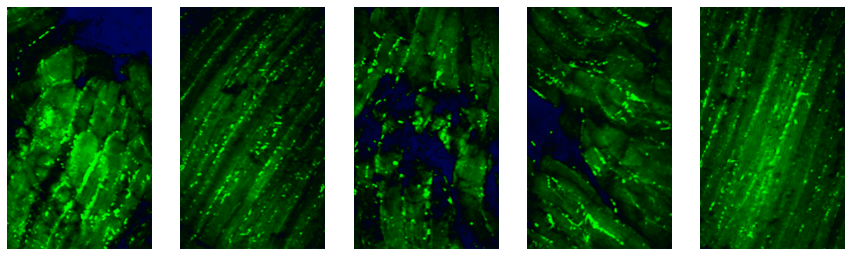

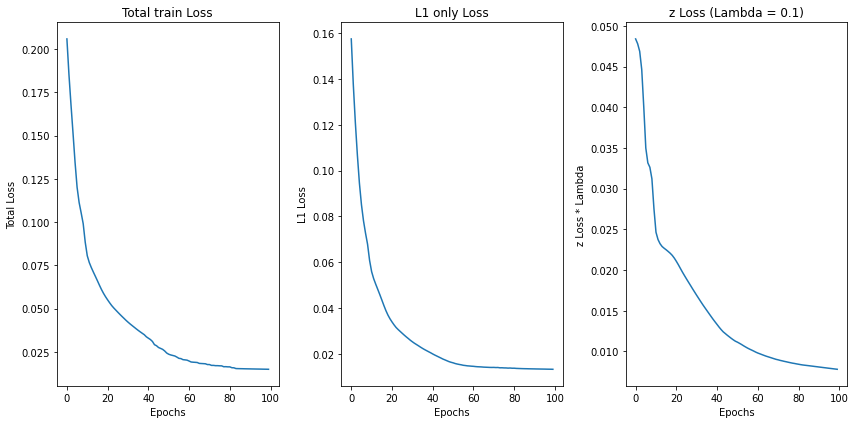

 10%|████                                    | 101/1000 [00:32<06:25,  2.33it/s]

Epoch: 101 	Training Loss Total: 0.014918 	L1 only: 0.013283 	Z Loss*Lambda: 0.007784


 10%|████                                    | 102/1000 [00:32<05:52,  2.55it/s]

Epoch: 102 	Training Loss Total: 0.014896 	L1 only: 0.013269 	Z Loss*Lambda: 0.007753


 10%|████                                    | 103/1000 [00:32<05:30,  2.72it/s]

Epoch: 103 	Training Loss Total: 0.014877 	L1 only: 0.013254 	Z Loss*Lambda: 0.007723


 10%|████▏                                   | 104/1000 [00:33<05:14,  2.85it/s]

Epoch: 104 	Training Loss Total: 0.014467 	L1 only: 0.013237 	Z Loss*Lambda: 0.007703


 10%|████▏                                   | 105/1000 [00:33<05:03,  2.95it/s]

Epoch: 105 	Training Loss Total: 0.014136 	L1 only: 0.013300 	Z Loss*Lambda: 0.007697


 11%|████▏                                   | 106/1000 [00:33<04:55,  3.03it/s]

Epoch: 106 	Training Loss Total: 0.014111 	L1 only: 0.013284 	Z Loss*Lambda: 0.007672


 11%|████▎                                   | 107/1000 [00:34<04:49,  3.08it/s]

Epoch: 107 	Training Loss Total: 0.014076 	L1 only: 0.013247 	Z Loss*Lambda: 0.007659


 11%|████▎                                   | 108/1000 [00:34<04:45,  3.12it/s]

Epoch: 108 	Training Loss Total: 0.014119 	L1 only: 0.013291 	Z Loss*Lambda: 0.007639


 11%|████▎                                   | 109/1000 [00:34<04:42,  3.15it/s]

Epoch: 109 	Training Loss Total: 0.013697 	L1 only: 0.013274 	Z Loss*Lambda: 0.007617


 11%|████▍                                   | 110/1000 [00:35<04:40,  3.17it/s]

Epoch: 110 	Training Loss Total: 0.013749 	L1 only: 0.013324 	Z Loss*Lambda: 0.007606


 11%|████▍                                   | 111/1000 [00:35<04:39,  3.18it/s]

Epoch: 111 	Training Loss Total: 0.013576 	L1 only: 0.013161 	Z Loss*Lambda: 0.007591


 11%|████▍                                   | 112/1000 [00:35<04:37,  3.20it/s]

Epoch: 112 	Training Loss Total: 0.013617 	L1 only: 0.013198 	Z Loss*Lambda: 0.007584


 11%|████▌                                   | 113/1000 [00:36<04:37,  3.20it/s]

Epoch: 113 	Training Loss Total: 0.013600 	L1 only: 0.013183 	Z Loss*Lambda: 0.007567


 11%|████▌                                   | 114/1000 [00:36<04:36,  3.21it/s]

Epoch: 114 	Training Loss Total: 0.013576 	L1 only: 0.013161 	Z Loss*Lambda: 0.007554


 12%|████▌                                   | 115/1000 [00:36<04:35,  3.21it/s]

Epoch: 115 	Training Loss Total: 0.013574 	L1 only: 0.013159 	Z Loss*Lambda: 0.007542


 12%|████▋                                   | 116/1000 [00:36<04:35,  3.21it/s]

Epoch: 116 	Training Loss Total: 0.013544 	L1 only: 0.013131 	Z Loss*Lambda: 0.007528


 12%|████▋                                   | 117/1000 [00:37<04:34,  3.21it/s]

Epoch: 117 	Training Loss Total: 0.013548 	L1 only: 0.013135 	Z Loss*Lambda: 0.007515


 12%|████▋                                   | 118/1000 [00:37<04:34,  3.21it/s]

Epoch: 118 	Training Loss Total: 0.013522 	L1 only: 0.013111 	Z Loss*Lambda: 0.007501


 12%|████▊                                   | 119/1000 [00:37<04:34,  3.21it/s]

Epoch: 119 	Training Loss Total: 0.013511 	L1 only: 0.013101 	Z Loss*Lambda: 0.007488


 12%|████▊                                   | 120/1000 [00:38<04:33,  3.21it/s]

Epoch: 120 	Training Loss Total: 0.013491 	L1 only: 0.013083 	Z Loss*Lambda: 0.007475


 12%|████▊                                   | 121/1000 [00:38<04:33,  3.21it/s]

Epoch: 121 	Training Loss Total: 0.013493 	L1 only: 0.013084 	Z Loss*Lambda: 0.007461


 12%|████▉                                   | 122/1000 [00:38<04:33,  3.21it/s]

Epoch: 122 	Training Loss Total: 0.013492 	L1 only: 0.013085 	Z Loss*Lambda: 0.007447


 12%|████▉                                   | 123/1000 [00:39<04:32,  3.21it/s]

Epoch: 123 	Training Loss Total: 0.013502 	L1 only: 0.013094 	Z Loss*Lambda: 0.007434


 12%|████▉                                   | 124/1000 [00:39<04:32,  3.21it/s]

Epoch: 124 	Training Loss Total: 0.013481 	L1 only: 0.013074 	Z Loss*Lambda: 0.007420


 12%|█████                                   | 125/1000 [00:39<04:32,  3.21it/s]

Epoch: 125 	Training Loss Total: 0.013476 	L1 only: 0.013071 	Z Loss*Lambda: 0.007407


 13%|█████                                   | 126/1000 [00:40<04:31,  3.21it/s]

Epoch: 126 	Training Loss Total: 0.013474 	L1 only: 0.013069 	Z Loss*Lambda: 0.007394


 13%|█████                                   | 127/1000 [00:40<04:31,  3.21it/s]

Epoch: 127 	Training Loss Total: 0.013463 	L1 only: 0.013059 	Z Loss*Lambda: 0.007379


 13%|█████                                   | 128/1000 [00:40<04:31,  3.21it/s]

Epoch: 128 	Training Loss Total: 0.013499 	L1 only: 0.013093 	Z Loss*Lambda: 0.007367


 13%|█████▏                                  | 129/1000 [00:41<04:31,  3.21it/s]

Epoch: 129 	Training Loss Total: 0.013429 	L1 only: 0.013028 	Z Loss*Lambda: 0.007353


 13%|█████▏                                  | 130/1000 [00:41<04:30,  3.21it/s]

Epoch: 130 	Training Loss Total: 0.013439 	L1 only: 0.013038 	Z Loss*Lambda: 0.007342


 13%|█████▏                                  | 131/1000 [00:41<04:30,  3.21it/s]

Epoch: 131 	Training Loss Total: 0.013440 	L1 only: 0.013039 	Z Loss*Lambda: 0.007328


 13%|█████▎                                  | 132/1000 [00:41<04:30,  3.21it/s]

Epoch: 132 	Training Loss Total: 0.013079 	L1 only: 0.013079 	Z Loss*Lambda: 0.007320


 13%|█████▎                                  | 133/1000 [00:42<04:29,  3.21it/s]

Epoch: 133 	Training Loss Total: 0.012973 	L1 only: 0.012973 	Z Loss*Lambda: 0.007310


 13%|█████▎                                  | 134/1000 [00:42<04:29,  3.21it/s]

Epoch: 134 	Training Loss Total: 0.012953 	L1 only: 0.012953 	Z Loss*Lambda: 0.007309


 14%|█████▍                                  | 135/1000 [00:42<04:29,  3.21it/s]

Epoch: 135 	Training Loss Total: 0.012943 	L1 only: 0.012943 	Z Loss*Lambda: 0.007301


 14%|█████▍                                  | 136/1000 [00:43<04:28,  3.21it/s]

Epoch: 136 	Training Loss Total: 0.012941 	L1 only: 0.012941 	Z Loss*Lambda: 0.007293


 14%|█████▍                                  | 137/1000 [00:43<04:28,  3.21it/s]

Epoch: 137 	Training Loss Total: 0.012937 	L1 only: 0.012937 	Z Loss*Lambda: 0.007286


 14%|█████▌                                  | 138/1000 [00:43<04:28,  3.21it/s]

Epoch: 138 	Training Loss Total: 0.012932 	L1 only: 0.012932 	Z Loss*Lambda: 0.007278


 14%|█████▌                                  | 139/1000 [00:44<04:28,  3.21it/s]

Epoch: 139 	Training Loss Total: 0.012932 	L1 only: 0.012932 	Z Loss*Lambda: 0.007271


 14%|█████▌                                  | 140/1000 [00:44<04:27,  3.21it/s]

Epoch: 140 	Training Loss Total: 0.012937 	L1 only: 0.012937 	Z Loss*Lambda: 0.007263


 14%|█████▋                                  | 141/1000 [00:44<04:27,  3.21it/s]

Epoch: 141 	Training Loss Total: 0.012938 	L1 only: 0.012938 	Z Loss*Lambda: 0.007255


 14%|█████▋                                  | 142/1000 [00:45<04:27,  3.21it/s]

Epoch: 142 	Training Loss Total: 0.012946 	L1 only: 0.012946 	Z Loss*Lambda: 0.007247


 14%|█████▋                                  | 143/1000 [00:45<04:26,  3.21it/s]

Epoch: 143 	Training Loss Total: 0.012949 	L1 only: 0.012949 	Z Loss*Lambda: 0.007240


 14%|█████▊                                  | 144/1000 [00:45<04:26,  3.21it/s]

Epoch: 144 	Training Loss Total: 0.012933 	L1 only: 0.012933 	Z Loss*Lambda: 0.007233


 14%|█████▊                                  | 145/1000 [00:45<04:26,  3.21it/s]

Epoch: 145 	Training Loss Total: 0.012927 	L1 only: 0.012927 	Z Loss*Lambda: 0.007225


 15%|█████▊                                  | 146/1000 [00:46<04:25,  3.21it/s]

Epoch: 146 	Training Loss Total: 0.012921 	L1 only: 0.012921 	Z Loss*Lambda: 0.007218


 15%|█████▉                                  | 147/1000 [00:46<04:25,  3.21it/s]

Epoch: 147 	Training Loss Total: 0.012933 	L1 only: 0.012933 	Z Loss*Lambda: 0.007210


 15%|█████▉                                  | 148/1000 [00:46<04:25,  3.21it/s]

Epoch: 148 	Training Loss Total: 0.012936 	L1 only: 0.012936 	Z Loss*Lambda: 0.007202


 15%|█████▉                                  | 149/1000 [00:47<04:24,  3.21it/s]

Epoch: 149 	Training Loss Total: 0.012932 	L1 only: 0.012932 	Z Loss*Lambda: 0.007194
Epoch: 150 	Training Loss Total: 0.012923 	L1 only: 0.012923 	Z Loss*Lambda: 0.007187


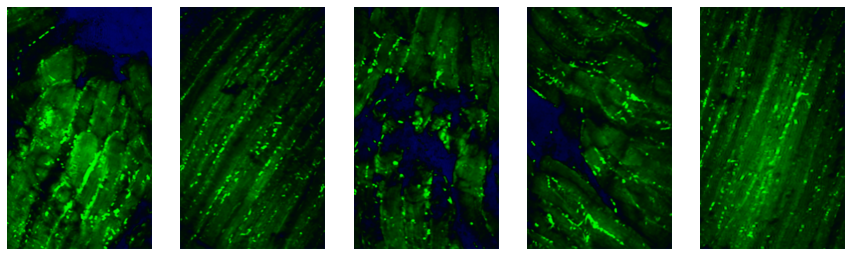

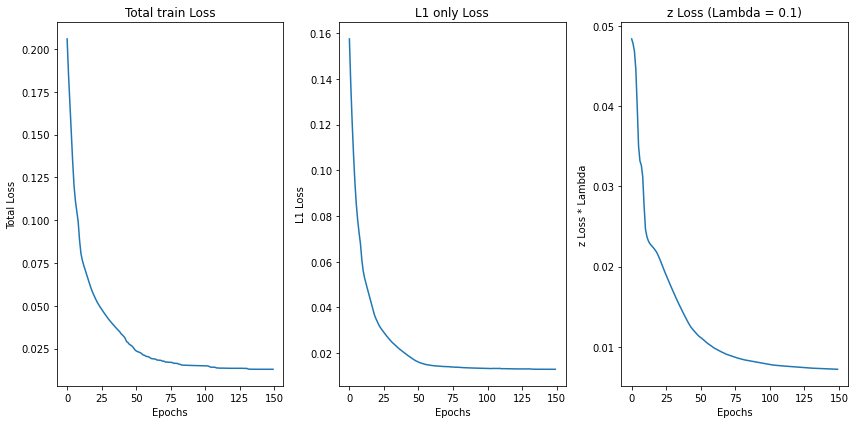

 15%|██████                                  | 151/1000 [00:48<05:51,  2.42it/s]

Epoch: 151 	Training Loss Total: 0.012911 	L1 only: 0.012911 	Z Loss*Lambda: 0.007179


 15%|██████                                  | 152/1000 [00:48<05:24,  2.61it/s]

Epoch: 152 	Training Loss Total: 0.012908 	L1 only: 0.012908 	Z Loss*Lambda: 0.007172


 15%|██████                                  | 153/1000 [00:48<05:06,  2.76it/s]

Epoch: 153 	Training Loss Total: 0.012900 	L1 only: 0.012900 	Z Loss*Lambda: 0.007164


 15%|██████▏                                 | 154/1000 [00:49<04:53,  2.88it/s]

Epoch: 154 	Training Loss Total: 0.012907 	L1 only: 0.012907 	Z Loss*Lambda: 0.007157


 16%|██████▏                                 | 155/1000 [00:49<04:44,  2.97it/s]

Epoch: 155 	Training Loss Total: 0.012892 	L1 only: 0.012892 	Z Loss*Lambda: 0.007149


 16%|██████▏                                 | 156/1000 [00:49<04:37,  3.04it/s]

Epoch: 156 	Training Loss Total: 0.012891 	L1 only: 0.012891 	Z Loss*Lambda: 0.007142


 16%|██████▎                                 | 157/1000 [00:50<04:33,  3.09it/s]

Epoch: 157 	Training Loss Total: 0.012875 	L1 only: 0.012875 	Z Loss*Lambda: 0.007135


 16%|██████▎                                 | 158/1000 [00:50<04:29,  3.12it/s]

Epoch: 158 	Training Loss Total: 0.012872 	L1 only: 0.012872 	Z Loss*Lambda: 0.007127


 16%|██████▎                                 | 159/1000 [00:50<04:26,  3.15it/s]

Epoch: 159 	Training Loss Total: 0.012866 	L1 only: 0.012866 	Z Loss*Lambda: 0.007121


 16%|██████▍                                 | 160/1000 [00:51<04:25,  3.16it/s]

Epoch: 160 	Training Loss Total: 0.012871 	L1 only: 0.012871 	Z Loss*Lambda: 0.007113


 16%|██████▍                                 | 161/1000 [00:51<04:24,  3.18it/s]

Epoch: 161 	Training Loss Total: 0.012871 	L1 only: 0.012871 	Z Loss*Lambda: 0.007106


 16%|██████▍                                 | 162/1000 [00:51<04:22,  3.19it/s]

Epoch: 162 	Training Loss Total: 0.012868 	L1 only: 0.012868 	Z Loss*Lambda: 0.007099


 16%|██████▌                                 | 163/1000 [00:52<04:22,  3.19it/s]

Epoch: 163 	Training Loss Total: 0.012866 	L1 only: 0.012866 	Z Loss*Lambda: 0.007092


 16%|██████▌                                 | 164/1000 [00:52<04:21,  3.20it/s]

Epoch: 164 	Training Loss Total: 0.012867 	L1 only: 0.012867 	Z Loss*Lambda: 0.007085


 16%|██████▌                                 | 165/1000 [00:52<04:20,  3.20it/s]

Epoch: 165 	Training Loss Total: 0.012867 	L1 only: 0.012867 	Z Loss*Lambda: 0.007078


 17%|██████▋                                 | 166/1000 [00:53<04:20,  3.20it/s]

Epoch: 166 	Training Loss Total: 0.012846 	L1 only: 0.012846 	Z Loss*Lambda: 0.007072


 17%|██████▋                                 | 167/1000 [00:53<04:20,  3.20it/s]

Epoch: 167 	Training Loss Total: 0.012842 	L1 only: 0.012842 	Z Loss*Lambda: 0.007065


 17%|██████▋                                 | 168/1000 [00:53<04:19,  3.21it/s]

Epoch: 168 	Training Loss Total: 0.012816 	L1 only: 0.012816 	Z Loss*Lambda: 0.007058


 17%|██████▊                                 | 169/1000 [00:53<04:19,  3.21it/s]

Epoch: 169 	Training Loss Total: 0.012814 	L1 only: 0.012814 	Z Loss*Lambda: 0.007053


 17%|██████▊                                 | 170/1000 [00:54<04:19,  3.20it/s]

Epoch: 170 	Training Loss Total: 0.012814 	L1 only: 0.012814 	Z Loss*Lambda: 0.007046


 17%|██████▊                                 | 171/1000 [00:54<04:18,  3.21it/s]

Epoch: 171 	Training Loss Total: 0.012833 	L1 only: 0.012833 	Z Loss*Lambda: 0.007040


 17%|██████▉                                 | 172/1000 [00:54<04:18,  3.21it/s]

Epoch: 172 	Training Loss Total: 0.012838 	L1 only: 0.012838 	Z Loss*Lambda: 0.007033


 17%|██████▉                                 | 173/1000 [00:55<04:18,  3.20it/s]

Epoch: 173 	Training Loss Total: 0.012830 	L1 only: 0.012830 	Z Loss*Lambda: 0.007026


 17%|██████▉                                 | 174/1000 [00:55<04:17,  3.20it/s]

Epoch: 174 	Training Loss Total: 0.012826 	L1 only: 0.012826 	Z Loss*Lambda: 0.007020


 18%|███████                                 | 175/1000 [00:55<04:17,  3.21it/s]

Epoch: 175 	Training Loss Total: 0.012802 	L1 only: 0.012802 	Z Loss*Lambda: 0.007013


 18%|███████                                 | 176/1000 [00:56<04:17,  3.21it/s]

Epoch: 176 	Training Loss Total: 0.012791 	L1 only: 0.012791 	Z Loss*Lambda: 0.007008


 18%|███████                                 | 177/1000 [00:56<04:16,  3.21it/s]

Epoch: 177 	Training Loss Total: 0.012790 	L1 only: 0.012790 	Z Loss*Lambda: 0.007001


 18%|███████                                 | 178/1000 [00:56<04:16,  3.21it/s]

Epoch: 178 	Training Loss Total: 0.012786 	L1 only: 0.012786 	Z Loss*Lambda: 0.006995


 18%|███████▏                                | 179/1000 [00:57<04:16,  3.21it/s]

Epoch: 179 	Training Loss Total: 0.012807 	L1 only: 0.012807 	Z Loss*Lambda: 0.006989


 18%|███████▏                                | 180/1000 [00:57<04:15,  3.21it/s]

Epoch: 180 	Training Loss Total: 0.012824 	L1 only: 0.012824 	Z Loss*Lambda: 0.006983


 18%|███████▏                                | 181/1000 [00:57<04:15,  3.21it/s]

Epoch: 181 	Training Loss Total: 0.012791 	L1 only: 0.012791 	Z Loss*Lambda: 0.006976


 18%|███████▎                                | 182/1000 [00:58<04:15,  3.21it/s]

Epoch: 182 	Training Loss Total: 0.012787 	L1 only: 0.012787 	Z Loss*Lambda: 0.006970


 18%|███████▎                                | 183/1000 [00:58<04:14,  3.20it/s]

Epoch: 183 	Training Loss Total: 0.012772 	L1 only: 0.012772 	Z Loss*Lambda: 0.006964


 18%|███████▎                                | 184/1000 [00:58<04:14,  3.20it/s]

Epoch: 184 	Training Loss Total: 0.012773 	L1 only: 0.012773 	Z Loss*Lambda: 0.006959


 18%|███████▍                                | 185/1000 [00:58<04:14,  3.20it/s]

Epoch: 185 	Training Loss Total: 0.012772 	L1 only: 0.012772 	Z Loss*Lambda: 0.006953


 19%|███████▍                                | 186/1000 [00:59<04:13,  3.21it/s]

Epoch: 186 	Training Loss Total: 0.012779 	L1 only: 0.012779 	Z Loss*Lambda: 0.006947


 19%|███████▍                                | 187/1000 [00:59<04:13,  3.21it/s]

Epoch: 187 	Training Loss Total: 0.012761 	L1 only: 0.012761 	Z Loss*Lambda: 0.006941


 19%|███████▌                                | 188/1000 [00:59<04:13,  3.21it/s]

Epoch: 188 	Training Loss Total: 0.012741 	L1 only: 0.012741 	Z Loss*Lambda: 0.006936


 19%|███████▌                                | 189/1000 [01:00<04:12,  3.21it/s]

Epoch: 189 	Training Loss Total: 0.012736 	L1 only: 0.012736 	Z Loss*Lambda: 0.006931


 19%|███████▌                                | 190/1000 [01:00<04:12,  3.21it/s]

Epoch: 190 	Training Loss Total: 0.012737 	L1 only: 0.012737 	Z Loss*Lambda: 0.006925


 19%|███████▋                                | 191/1000 [01:00<04:12,  3.21it/s]

Epoch: 191 	Training Loss Total: 0.012741 	L1 only: 0.012741 	Z Loss*Lambda: 0.006919


 19%|███████▋                                | 192/1000 [01:01<04:11,  3.21it/s]

Epoch: 192 	Training Loss Total: 0.012750 	L1 only: 0.012750 	Z Loss*Lambda: 0.006913


 19%|███████▋                                | 193/1000 [01:01<04:11,  3.21it/s]

Epoch: 193 	Training Loss Total: 0.012759 	L1 only: 0.012759 	Z Loss*Lambda: 0.006907


 19%|███████▊                                | 194/1000 [01:01<04:11,  3.20it/s]

Epoch: 194 	Training Loss Total: 0.012751 	L1 only: 0.012751 	Z Loss*Lambda: 0.006902


 20%|███████▊                                | 195/1000 [01:02<04:11,  3.21it/s]

Epoch: 195 	Training Loss Total: 0.012763 	L1 only: 0.012763 	Z Loss*Lambda: 0.006896


 20%|███████▊                                | 196/1000 [01:02<04:10,  3.21it/s]

Epoch: 196 	Training Loss Total: 0.012745 	L1 only: 0.012745 	Z Loss*Lambda: 0.006890


 20%|███████▉                                | 197/1000 [01:02<04:10,  3.20it/s]

Epoch: 197 	Training Loss Total: 0.012722 	L1 only: 0.012722 	Z Loss*Lambda: 0.006885


 20%|███████▉                                | 198/1000 [01:03<04:10,  3.21it/s]

Epoch: 198 	Training Loss Total: 0.012719 	L1 only: 0.012719 	Z Loss*Lambda: 0.006880


 20%|███████▉                                | 199/1000 [01:03<04:09,  3.20it/s]

Epoch: 199 	Training Loss Total: 0.012732 	L1 only: 0.012732 	Z Loss*Lambda: 0.006875
Epoch: 200 	Training Loss Total: 0.012720 	L1 only: 0.012720 	Z Loss*Lambda: 0.006869


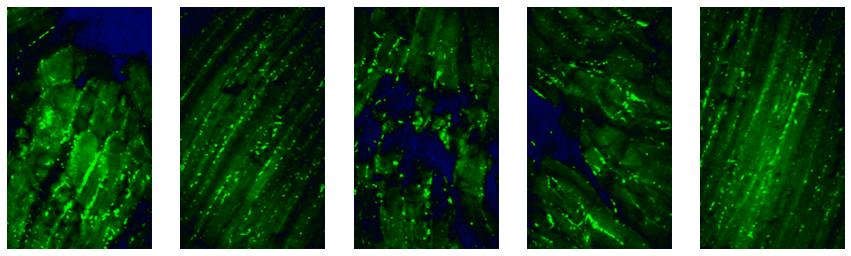

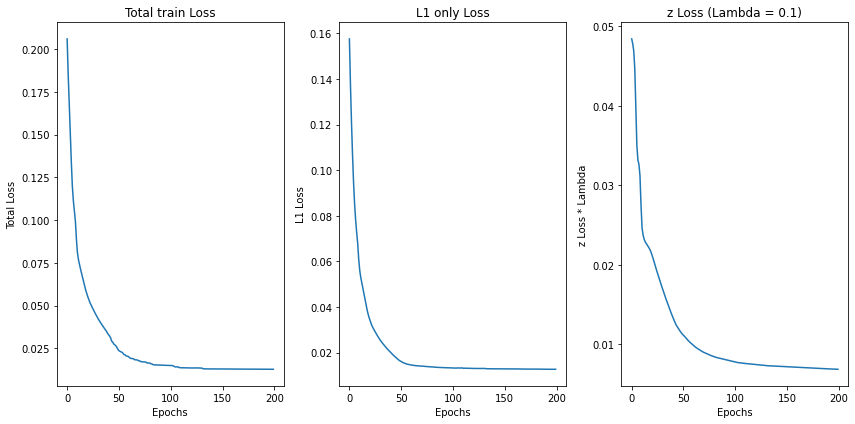

 20%|████████                                | 201/1000 [01:04<05:30,  2.42it/s]

Epoch: 201 	Training Loss Total: 0.012708 	L1 only: 0.012708 	Z Loss*Lambda: 0.006863


 20%|████████                                | 202/1000 [01:04<05:05,  2.61it/s]

Epoch: 202 	Training Loss Total: 0.012714 	L1 only: 0.012714 	Z Loss*Lambda: 0.006858


 20%|████████                                | 203/1000 [01:05<04:48,  2.76it/s]

Epoch: 203 	Training Loss Total: 0.012701 	L1 only: 0.012701 	Z Loss*Lambda: 0.006853


 20%|████████▏                               | 204/1000 [01:05<04:36,  2.88it/s]

Epoch: 204 	Training Loss Total: 0.012681 	L1 only: 0.012681 	Z Loss*Lambda: 0.006848


 20%|████████▏                               | 205/1000 [01:05<04:27,  2.97it/s]

Epoch: 205 	Training Loss Total: 0.012694 	L1 only: 0.012694 	Z Loss*Lambda: 0.006843


 21%|████████▏                               | 206/1000 [01:05<04:21,  3.04it/s]

Epoch: 206 	Training Loss Total: 0.012681 	L1 only: 0.012681 	Z Loss*Lambda: 0.006837


 21%|████████▎                               | 207/1000 [01:06<04:17,  3.08it/s]

Epoch: 207 	Training Loss Total: 0.012669 	L1 only: 0.012669 	Z Loss*Lambda: 0.006832


 21%|████████▎                               | 208/1000 [01:06<04:14,  3.12it/s]

Epoch: 208 	Training Loss Total: 0.012681 	L1 only: 0.012681 	Z Loss*Lambda: 0.006827


 21%|████████▎                               | 209/1000 [01:06<04:11,  3.14it/s]

Epoch: 209 	Training Loss Total: 0.012681 	L1 only: 0.012681 	Z Loss*Lambda: 0.006822


 21%|████████▍                               | 210/1000 [01:07<04:10,  3.15it/s]

Epoch: 210 	Training Loss Total: 0.012681 	L1 only: 0.012681 	Z Loss*Lambda: 0.006817


 21%|████████▍                               | 211/1000 [01:07<04:08,  3.17it/s]

Epoch: 211 	Training Loss Total: 0.012671 	L1 only: 0.012671 	Z Loss*Lambda: 0.006811


 21%|████████▍                               | 212/1000 [01:07<04:07,  3.18it/s]

Epoch: 212 	Training Loss Total: 0.012671 	L1 only: 0.012671 	Z Loss*Lambda: 0.006806


 21%|████████▌                               | 213/1000 [01:08<04:07,  3.18it/s]

Epoch: 213 	Training Loss Total: 0.012685 	L1 only: 0.012685 	Z Loss*Lambda: 0.006801


 21%|████████▌                               | 214/1000 [01:08<04:06,  3.19it/s]

Epoch: 214 	Training Loss Total: 0.012693 	L1 only: 0.012693 	Z Loss*Lambda: 0.006796


 22%|████████▌                               | 215/1000 [01:08<04:05,  3.19it/s]

Epoch: 215 	Training Loss Total: 0.012672 	L1 only: 0.012672 	Z Loss*Lambda: 0.006791


 22%|████████▋                               | 216/1000 [01:09<04:05,  3.19it/s]

Epoch: 216 	Training Loss Total: 0.012658 	L1 only: 0.012658 	Z Loss*Lambda: 0.006786


 22%|████████▋                               | 217/1000 [01:09<04:05,  3.19it/s]

Epoch: 217 	Training Loss Total: 0.012653 	L1 only: 0.012653 	Z Loss*Lambda: 0.006782


 22%|████████▋                               | 218/1000 [01:09<04:04,  3.19it/s]

Epoch: 218 	Training Loss Total: 0.012658 	L1 only: 0.012658 	Z Loss*Lambda: 0.006777


 22%|████████▊                               | 219/1000 [01:10<04:04,  3.20it/s]

Epoch: 219 	Training Loss Total: 0.012660 	L1 only: 0.012660 	Z Loss*Lambda: 0.006772


 22%|████████▊                               | 220/1000 [01:10<04:04,  3.19it/s]

Epoch: 220 	Training Loss Total: 0.012653 	L1 only: 0.012653 	Z Loss*Lambda: 0.006767


 22%|████████▊                               | 221/1000 [01:10<04:03,  3.19it/s]

Epoch: 221 	Training Loss Total: 0.012647 	L1 only: 0.012647 	Z Loss*Lambda: 0.006762


 22%|████████▉                               | 222/1000 [01:10<04:03,  3.20it/s]

Epoch: 222 	Training Loss Total: 0.012641 	L1 only: 0.012641 	Z Loss*Lambda: 0.006758


 22%|████████▉                               | 223/1000 [01:11<04:03,  3.19it/s]

Epoch: 223 	Training Loss Total: 0.012633 	L1 only: 0.012633 	Z Loss*Lambda: 0.006753


 22%|████████▉                               | 224/1000 [01:11<04:02,  3.19it/s]

Epoch: 224 	Training Loss Total: 0.012631 	L1 only: 0.012631 	Z Loss*Lambda: 0.006749


 22%|█████████                               | 225/1000 [01:11<04:02,  3.20it/s]

Epoch: 225 	Training Loss Total: 0.012623 	L1 only: 0.012623 	Z Loss*Lambda: 0.006744


 23%|█████████                               | 226/1000 [01:12<04:02,  3.20it/s]

Epoch: 226 	Training Loss Total: 0.012631 	L1 only: 0.012631 	Z Loss*Lambda: 0.006739


 23%|█████████                               | 227/1000 [01:12<04:02,  3.19it/s]

Epoch: 227 	Training Loss Total: 0.012650 	L1 only: 0.012650 	Z Loss*Lambda: 0.006734


 23%|█████████                               | 228/1000 [01:12<04:01,  3.20it/s]

Epoch: 228 	Training Loss Total: 0.012654 	L1 only: 0.012654 	Z Loss*Lambda: 0.006729


 23%|█████████▏                              | 229/1000 [01:13<04:01,  3.20it/s]

Epoch: 229 	Training Loss Total: 0.012650 	L1 only: 0.012650 	Z Loss*Lambda: 0.006725


 23%|█████████▏                              | 230/1000 [01:13<04:01,  3.19it/s]

Epoch: 230 	Training Loss Total: 0.012627 	L1 only: 0.012627 	Z Loss*Lambda: 0.006720


 23%|█████████▏                              | 231/1000 [01:13<04:00,  3.20it/s]

Epoch: 231 	Training Loss Total: 0.012610 	L1 only: 0.012610 	Z Loss*Lambda: 0.006716


 23%|█████████▎                              | 232/1000 [01:14<04:00,  3.20it/s]

Epoch: 232 	Training Loss Total: 0.012609 	L1 only: 0.012609 	Z Loss*Lambda: 0.006712


 23%|█████████▎                              | 233/1000 [01:14<03:59,  3.20it/s]

Epoch: 233 	Training Loss Total: 0.012619 	L1 only: 0.012619 	Z Loss*Lambda: 0.006708


 23%|█████████▎                              | 234/1000 [01:14<03:59,  3.20it/s]

Epoch: 234 	Training Loss Total: 0.012622 	L1 only: 0.012622 	Z Loss*Lambda: 0.006703


 24%|█████████▍                              | 235/1000 [01:15<03:59,  3.20it/s]

Epoch: 235 	Training Loss Total: 0.012634 	L1 only: 0.012634 	Z Loss*Lambda: 0.006699


 24%|█████████▍                              | 236/1000 [01:15<03:59,  3.20it/s]

Epoch: 236 	Training Loss Total: 0.012634 	L1 only: 0.012634 	Z Loss*Lambda: 0.006694


 24%|█████████▍                              | 237/1000 [01:15<03:58,  3.20it/s]

Epoch: 237 	Training Loss Total: 0.012618 	L1 only: 0.012618 	Z Loss*Lambda: 0.006690


 24%|█████████▌                              | 238/1000 [01:16<03:58,  3.20it/s]

Epoch: 238 	Training Loss Total: 0.012622 	L1 only: 0.012622 	Z Loss*Lambda: 0.006686


 24%|█████████▌                              | 239/1000 [01:16<03:58,  3.20it/s]

Epoch: 239 	Training Loss Total: 0.012612 	L1 only: 0.012612 	Z Loss*Lambda: 0.006682


 24%|█████████▌                              | 240/1000 [01:16<03:57,  3.20it/s]

Epoch: 240 	Training Loss Total: 0.012601 	L1 only: 0.012601 	Z Loss*Lambda: 0.006677


 24%|█████████▋                              | 241/1000 [01:16<03:57,  3.20it/s]

Epoch: 241 	Training Loss Total: 0.012592 	L1 only: 0.012592 	Z Loss*Lambda: 0.006673


 24%|█████████▋                              | 242/1000 [01:17<03:57,  3.20it/s]

Epoch: 242 	Training Loss Total: 0.012597 	L1 only: 0.012597 	Z Loss*Lambda: 0.006668


 24%|█████████▋                              | 243/1000 [01:17<03:56,  3.20it/s]

Epoch: 243 	Training Loss Total: 0.012607 	L1 only: 0.012607 	Z Loss*Lambda: 0.006664


 24%|█████████▊                              | 244/1000 [01:17<03:56,  3.19it/s]

Epoch: 244 	Training Loss Total: 0.012604 	L1 only: 0.012604 	Z Loss*Lambda: 0.006660


 24%|█████████▊                              | 245/1000 [01:18<03:56,  3.19it/s]

Epoch: 245 	Training Loss Total: 0.012603 	L1 only: 0.012603 	Z Loss*Lambda: 0.006656


 25%|█████████▊                              | 246/1000 [01:18<03:55,  3.19it/s]

Epoch: 246 	Training Loss Total: 0.012618 	L1 only: 0.012618 	Z Loss*Lambda: 0.006652


 25%|█████████▉                              | 247/1000 [01:18<03:55,  3.19it/s]

Epoch: 247 	Training Loss Total: 0.012621 	L1 only: 0.012621 	Z Loss*Lambda: 0.006648


 25%|█████████▉                              | 248/1000 [01:19<03:55,  3.19it/s]

Epoch: 248 	Training Loss Total: 0.012599 	L1 only: 0.012599 	Z Loss*Lambda: 0.006643


 25%|█████████▉                              | 249/1000 [01:19<03:55,  3.19it/s]

Epoch: 249 	Training Loss Total: 0.012580 	L1 only: 0.012580 	Z Loss*Lambda: 0.006639
Epoch: 250 	Training Loss Total: 0.012568 	L1 only: 0.012568 	Z Loss*Lambda: 0.006636


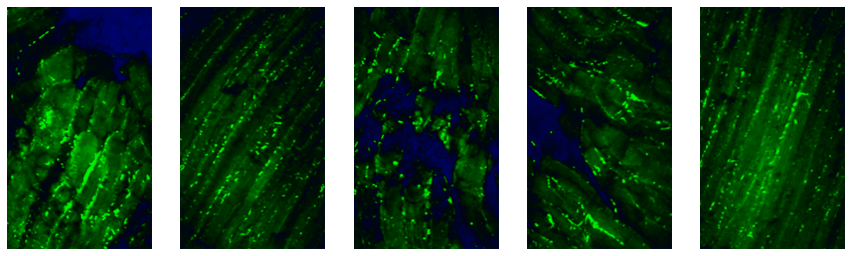

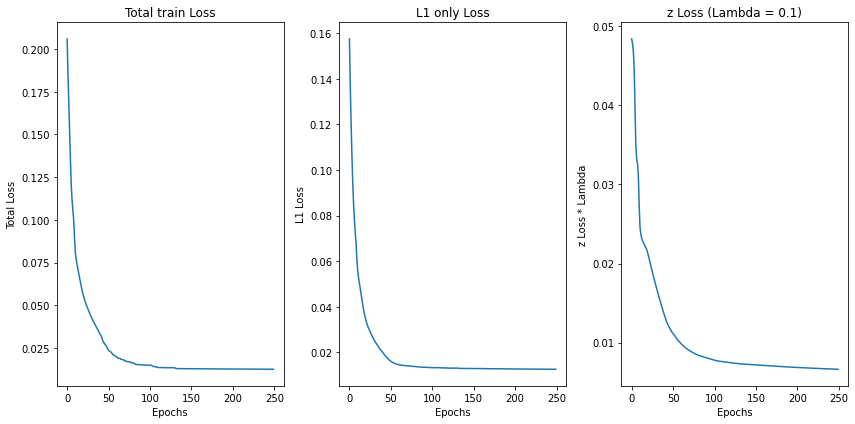

 25%|██████████                              | 251/1000 [01:20<05:23,  2.32it/s]

Epoch: 251 	Training Loss Total: 0.012559 	L1 only: 0.012559 	Z Loss*Lambda: 0.006632


 25%|██████████                              | 252/1000 [01:20<04:55,  2.53it/s]

Epoch: 252 	Training Loss Total: 0.012564 	L1 only: 0.012564 	Z Loss*Lambda: 0.006628


 25%|██████████                              | 253/1000 [01:21<04:37,  2.69it/s]

Epoch: 253 	Training Loss Total: 0.012573 	L1 only: 0.012573 	Z Loss*Lambda: 0.006624


 25%|██████████▏                             | 254/1000 [01:21<04:24,  2.82it/s]

Epoch: 254 	Training Loss Total: 0.012588 	L1 only: 0.012588 	Z Loss*Lambda: 0.006620


 26%|██████████▏                             | 255/1000 [01:21<04:14,  2.93it/s]

Epoch: 255 	Training Loss Total: 0.012588 	L1 only: 0.012588 	Z Loss*Lambda: 0.006616


 26%|██████████▏                             | 256/1000 [01:22<04:07,  3.00it/s]

Epoch: 256 	Training Loss Total: 0.012595 	L1 only: 0.012595 	Z Loss*Lambda: 0.006612


 26%|██████████▎                             | 257/1000 [01:22<04:03,  3.05it/s]

Epoch: 257 	Training Loss Total: 0.012601 	L1 only: 0.012601 	Z Loss*Lambda: 0.006608


 26%|██████████▎                             | 258/1000 [01:22<03:59,  3.10it/s]

Epoch: 258 	Training Loss Total: 0.012567 	L1 only: 0.012567 	Z Loss*Lambda: 0.006605


 26%|██████████▎                             | 259/1000 [01:23<03:57,  3.13it/s]

Epoch: 259 	Training Loss Total: 0.012552 	L1 only: 0.012552 	Z Loss*Lambda: 0.006601


 26%|██████████▍                             | 260/1000 [01:23<03:55,  3.14it/s]

Epoch: 260 	Training Loss Total: 0.012554 	L1 only: 0.012554 	Z Loss*Lambda: 0.006598


 26%|██████████▍                             | 261/1000 [01:23<03:54,  3.16it/s]

Epoch: 261 	Training Loss Total: 0.012554 	L1 only: 0.012554 	Z Loss*Lambda: 0.006594


 26%|██████████▍                             | 262/1000 [01:24<03:52,  3.17it/s]

Epoch: 262 	Training Loss Total: 0.012557 	L1 only: 0.012557 	Z Loss*Lambda: 0.006591


 26%|██████████▌                             | 263/1000 [01:24<03:51,  3.18it/s]

Epoch: 263 	Training Loss Total: 0.012557 	L1 only: 0.012557 	Z Loss*Lambda: 0.006587


 26%|██████████▌                             | 264/1000 [01:24<03:51,  3.18it/s]

Epoch: 264 	Training Loss Total: 0.012539 	L1 only: 0.012539 	Z Loss*Lambda: 0.006584


 26%|██████████▌                             | 265/1000 [01:25<03:50,  3.18it/s]

Epoch: 265 	Training Loss Total: 0.012531 	L1 only: 0.012531 	Z Loss*Lambda: 0.006581


 27%|██████████▋                             | 266/1000 [01:25<03:50,  3.19it/s]

Epoch: 266 	Training Loss Total: 0.012538 	L1 only: 0.012538 	Z Loss*Lambda: 0.006578


 27%|██████████▋                             | 267/1000 [01:25<03:50,  3.19it/s]

Epoch: 267 	Training Loss Total: 0.012541 	L1 only: 0.012541 	Z Loss*Lambda: 0.006576


 27%|██████████▋                             | 268/1000 [01:25<03:49,  3.19it/s]

Epoch: 268 	Training Loss Total: 0.012530 	L1 only: 0.012530 	Z Loss*Lambda: 0.006573


 27%|██████████▊                             | 269/1000 [01:26<03:49,  3.19it/s]

Epoch: 269 	Training Loss Total: 0.012526 	L1 only: 0.012526 	Z Loss*Lambda: 0.006570


 27%|██████████▊                             | 270/1000 [01:26<03:48,  3.19it/s]

Epoch: 270 	Training Loss Total: 0.012526 	L1 only: 0.012526 	Z Loss*Lambda: 0.006568


 27%|██████████▊                             | 271/1000 [01:26<03:48,  3.19it/s]

Epoch: 271 	Training Loss Total: 0.012534 	L1 only: 0.012534 	Z Loss*Lambda: 0.006565


 27%|██████████▉                             | 272/1000 [01:27<03:48,  3.19it/s]

Epoch: 272 	Training Loss Total: 0.012532 	L1 only: 0.012532 	Z Loss*Lambda: 0.006562


 27%|██████████▉                             | 273/1000 [01:27<03:47,  3.19it/s]

Epoch: 273 	Training Loss Total: 0.012529 	L1 only: 0.012529 	Z Loss*Lambda: 0.006561


 27%|██████████▉                             | 274/1000 [01:27<03:47,  3.19it/s]

Epoch: 274 	Training Loss Total: 0.012537 	L1 only: 0.012537 	Z Loss*Lambda: 0.006559


 28%|███████████                             | 275/1000 [01:28<03:47,  3.19it/s]

Epoch: 275 	Training Loss Total: 0.012569 	L1 only: 0.012569 	Z Loss*Lambda: 0.006558


 28%|███████████                             | 276/1000 [01:28<03:46,  3.19it/s]

Epoch: 276 	Training Loss Total: 0.012580 	L1 only: 0.012580 	Z Loss*Lambda: 0.006556


 28%|███████████                             | 277/1000 [01:28<03:46,  3.19it/s]

Epoch: 277 	Training Loss Total: 0.012543 	L1 only: 0.012543 	Z Loss*Lambda: 0.006554


 28%|███████████                             | 278/1000 [01:29<03:46,  3.19it/s]

Epoch: 278 	Training Loss Total: 0.012533 	L1 only: 0.012533 	Z Loss*Lambda: 0.006555


 28%|███████████▏                            | 279/1000 [01:29<03:45,  3.19it/s]

Epoch: 279 	Training Loss Total: 0.012529 	L1 only: 0.012529 	Z Loss*Lambda: 0.006553


 28%|███████████▏                            | 280/1000 [01:29<03:45,  3.19it/s]

Epoch: 280 	Training Loss Total: 0.012538 	L1 only: 0.012538 	Z Loss*Lambda: 0.006553


 28%|███████████▏                            | 281/1000 [01:30<03:45,  3.19it/s]

Epoch: 281 	Training Loss Total: 0.012513 	L1 only: 0.012513 	Z Loss*Lambda: 0.006552


 28%|███████████▎                            | 282/1000 [01:30<03:45,  3.19it/s]

Epoch: 282 	Training Loss Total: 0.012501 	L1 only: 0.012501 	Z Loss*Lambda: 0.006552


 28%|███████████▎                            | 283/1000 [01:30<03:44,  3.19it/s]

Epoch: 283 	Training Loss Total: 0.012487 	L1 only: 0.012487 	Z Loss*Lambda: 0.006552


 28%|███████████▎                            | 284/1000 [01:30<03:44,  3.19it/s]

Epoch: 284 	Training Loss Total: 0.012480 	L1 only: 0.012480 	Z Loss*Lambda: 0.006553


 28%|███████████▍                            | 285/1000 [01:31<03:44,  3.19it/s]

Epoch: 285 	Training Loss Total: 0.012472 	L1 only: 0.012472 	Z Loss*Lambda: 0.006553


 29%|███████████▍                            | 286/1000 [01:31<03:44,  3.19it/s]

Epoch: 286 	Training Loss Total: 0.012474 	L1 only: 0.012474 	Z Loss*Lambda: 0.006554


 29%|███████████▍                            | 287/1000 [01:31<03:43,  3.19it/s]

Epoch: 287 	Training Loss Total: 0.012476 	L1 only: 0.012476 	Z Loss*Lambda: 0.006554


 29%|███████████▌                            | 288/1000 [01:32<03:43,  3.18it/s]

Epoch: 288 	Training Loss Total: 0.012483 	L1 only: 0.012483 	Z Loss*Lambda: 0.006555


 29%|███████████▌                            | 289/1000 [01:32<03:43,  3.19it/s]

Epoch: 289 	Training Loss Total: 0.012486 	L1 only: 0.012486 	Z Loss*Lambda: 0.006554


 29%|███████████▌                            | 290/1000 [01:32<03:42,  3.19it/s]

Epoch: 290 	Training Loss Total: 0.012497 	L1 only: 0.012497 	Z Loss*Lambda: 0.006554


 29%|███████████▋                            | 291/1000 [01:33<03:42,  3.19it/s]

Epoch: 291 	Training Loss Total: 0.012519 	L1 only: 0.012519 	Z Loss*Lambda: 0.006554


 29%|███████████▋                            | 292/1000 [01:33<03:42,  3.19it/s]

Epoch: 292 	Training Loss Total: 0.012525 	L1 only: 0.012525 	Z Loss*Lambda: 0.006554


 29%|███████████▋                            | 293/1000 [01:33<03:41,  3.19it/s]

Epoch: 293 	Training Loss Total: 0.012484 	L1 only: 0.012484 	Z Loss*Lambda: 0.006552


 29%|███████████▊                            | 294/1000 [01:34<03:41,  3.18it/s]

Epoch: 294 	Training Loss Total: 0.012465 	L1 only: 0.012465 	Z Loss*Lambda: 0.006552


 30%|███████████▊                            | 295/1000 [01:34<03:41,  3.18it/s]

Epoch: 295 	Training Loss Total: 0.012468 	L1 only: 0.012468 	Z Loss*Lambda: 0.006551


 30%|███████████▊                            | 296/1000 [01:34<03:41,  3.18it/s]

Epoch: 296 	Training Loss Total: 0.012514 	L1 only: 0.012514 	Z Loss*Lambda: 0.006549


 30%|███████████▉                            | 297/1000 [01:35<03:40,  3.18it/s]

Epoch: 297 	Training Loss Total: 0.012517 	L1 only: 0.012517 	Z Loss*Lambda: 0.006546


 30%|███████████▉                            | 298/1000 [01:35<03:40,  3.18it/s]

Epoch: 298 	Training Loss Total: 0.012476 	L1 only: 0.012476 	Z Loss*Lambda: 0.006541


 30%|███████████▉                            | 299/1000 [01:35<03:40,  3.18it/s]

Epoch: 299 	Training Loss Total: 0.012456 	L1 only: 0.012456 	Z Loss*Lambda: 0.006536
Epoch: 300 	Training Loss Total: 0.012447 	L1 only: 0.012447 	Z Loss*Lambda: 0.006533


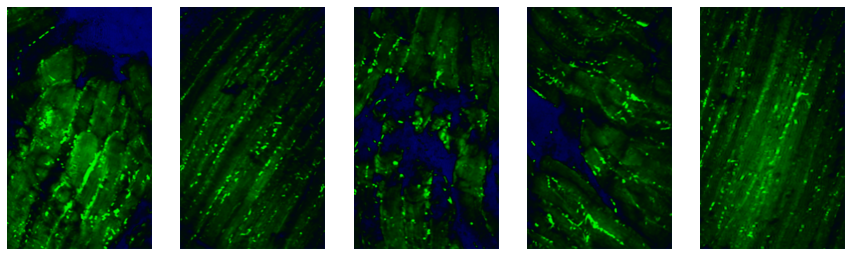

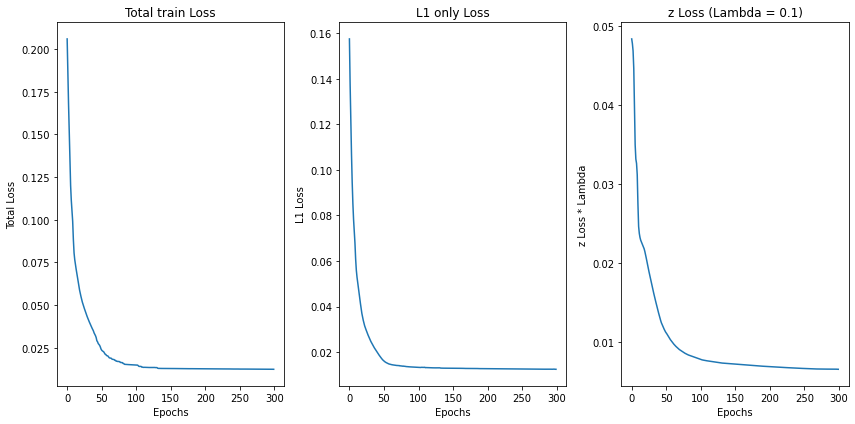

 30%|████████████                            | 301/1000 [01:36<04:52,  2.39it/s]

Epoch: 301 	Training Loss Total: 0.012440 	L1 only: 0.012440 	Z Loss*Lambda: 0.006530


 30%|████████████                            | 302/1000 [01:37<04:29,  2.59it/s]

Epoch: 302 	Training Loss Total: 0.012447 	L1 only: 0.012447 	Z Loss*Lambda: 0.006528


 30%|████████████                            | 303/1000 [01:37<04:14,  2.74it/s]

Epoch: 303 	Training Loss Total: 0.012453 	L1 only: 0.012453 	Z Loss*Lambda: 0.006527


 30%|████████████▏                           | 304/1000 [01:37<04:03,  2.86it/s]

Epoch: 304 	Training Loss Total: 0.012444 	L1 only: 0.012444 	Z Loss*Lambda: 0.006524


 30%|████████████▏                           | 305/1000 [01:38<03:55,  2.95it/s]

Epoch: 305 	Training Loss Total: 0.012441 	L1 only: 0.012441 	Z Loss*Lambda: 0.006525


 31%|████████████▏                           | 306/1000 [01:38<03:49,  3.02it/s]

Epoch: 306 	Training Loss Total: 0.012438 	L1 only: 0.012438 	Z Loss*Lambda: 0.006522


 31%|████████████▎                           | 307/1000 [01:38<03:46,  3.06it/s]

Epoch: 307 	Training Loss Total: 0.012434 	L1 only: 0.012434 	Z Loss*Lambda: 0.006520


 31%|████████████▎                           | 308/1000 [01:39<03:43,  3.10it/s]

Epoch: 308 	Training Loss Total: 0.012436 	L1 only: 0.012436 	Z Loss*Lambda: 0.006519


 31%|████████████▎                           | 309/1000 [01:39<03:41,  3.12it/s]

Epoch: 309 	Training Loss Total: 0.012442 	L1 only: 0.012442 	Z Loss*Lambda: 0.006517


 31%|████████████▍                           | 310/1000 [01:39<03:39,  3.14it/s]

Epoch: 310 	Training Loss Total: 0.012435 	L1 only: 0.012435 	Z Loss*Lambda: 0.006516


 31%|████████████▍                           | 311/1000 [01:39<03:38,  3.15it/s]

Epoch: 311 	Training Loss Total: 0.012428 	L1 only: 0.012428 	Z Loss*Lambda: 0.006513


 31%|████████████▍                           | 312/1000 [01:40<03:37,  3.16it/s]

Epoch: 312 	Training Loss Total: 0.012441 	L1 only: 0.012441 	Z Loss*Lambda: 0.006512


 31%|████████████▌                           | 313/1000 [01:40<03:37,  3.16it/s]

Epoch: 313 	Training Loss Total: 0.012470 	L1 only: 0.012470 	Z Loss*Lambda: 0.006510


 31%|████████████▌                           | 314/1000 [01:40<03:36,  3.17it/s]

Epoch: 314 	Training Loss Total: 0.012464 	L1 only: 0.012464 	Z Loss*Lambda: 0.006508


 32%|████████████▌                           | 315/1000 [01:41<03:35,  3.17it/s]

Epoch: 315 	Training Loss Total: 0.012445 	L1 only: 0.012445 	Z Loss*Lambda: 0.006506


 32%|████████████▋                           | 316/1000 [01:41<03:35,  3.17it/s]

Epoch: 316 	Training Loss Total: 0.012445 	L1 only: 0.012445 	Z Loss*Lambda: 0.006504


 32%|████████████▋                           | 317/1000 [01:41<03:35,  3.17it/s]

Epoch: 317 	Training Loss Total: 0.012440 	L1 only: 0.012440 	Z Loss*Lambda: 0.006502


 32%|████████████▋                           | 318/1000 [01:42<03:34,  3.18it/s]

Epoch: 318 	Training Loss Total: 0.012436 	L1 only: 0.012436 	Z Loss*Lambda: 0.006500


 32%|████████████▊                           | 319/1000 [01:42<03:34,  3.18it/s]

Epoch: 319 	Training Loss Total: 0.012422 	L1 only: 0.012422 	Z Loss*Lambda: 0.006498


 32%|████████████▊                           | 320/1000 [01:42<03:34,  3.17it/s]

Epoch: 320 	Training Loss Total: 0.012407 	L1 only: 0.012407 	Z Loss*Lambda: 0.006497


 32%|████████████▊                           | 321/1000 [01:43<03:33,  3.18it/s]

Epoch: 321 	Training Loss Total: 0.012409 	L1 only: 0.012409 	Z Loss*Lambda: 0.006495


 32%|████████████▉                           | 322/1000 [01:43<03:33,  3.18it/s]

Epoch: 322 	Training Loss Total: 0.012412 	L1 only: 0.012412 	Z Loss*Lambda: 0.006494


 32%|████████████▉                           | 323/1000 [01:43<03:33,  3.17it/s]

Epoch: 323 	Training Loss Total: 0.012425 	L1 only: 0.012425 	Z Loss*Lambda: 0.006492


 32%|████████████▉                           | 324/1000 [01:44<03:32,  3.18it/s]

Epoch: 324 	Training Loss Total: 0.012438 	L1 only: 0.012438 	Z Loss*Lambda: 0.006490


 32%|█████████████                           | 325/1000 [01:44<03:32,  3.17it/s]

Epoch: 325 	Training Loss Total: 0.012450 	L1 only: 0.012450 	Z Loss*Lambda: 0.006489


 33%|█████████████                           | 326/1000 [01:44<03:32,  3.17it/s]

Epoch: 326 	Training Loss Total: 0.012425 	L1 only: 0.012425 	Z Loss*Lambda: 0.006487


 33%|█████████████                           | 327/1000 [01:44<03:32,  3.17it/s]

Epoch: 327 	Training Loss Total: 0.012413 	L1 only: 0.012413 	Z Loss*Lambda: 0.006487


 33%|█████████████                           | 328/1000 [01:45<03:31,  3.17it/s]

Epoch: 328 	Training Loss Total: 0.012405 	L1 only: 0.012405 	Z Loss*Lambda: 0.006486


 33%|█████████████▏                          | 329/1000 [01:45<03:31,  3.17it/s]

Epoch: 329 	Training Loss Total: 0.012390 	L1 only: 0.012390 	Z Loss*Lambda: 0.006485


 33%|█████████████▏                          | 330/1000 [01:45<03:31,  3.17it/s]

Epoch: 330 	Training Loss Total: 0.012381 	L1 only: 0.012381 	Z Loss*Lambda: 0.006484


 33%|█████████████▏                          | 331/1000 [01:46<03:30,  3.17it/s]

Epoch: 331 	Training Loss Total: 0.012384 	L1 only: 0.012384 	Z Loss*Lambda: 0.006483


 33%|█████████████▎                          | 332/1000 [01:46<03:30,  3.17it/s]

Epoch: 332 	Training Loss Total: 0.012378 	L1 only: 0.012378 	Z Loss*Lambda: 0.006482


 33%|█████████████▎                          | 333/1000 [01:46<03:30,  3.17it/s]

Epoch: 333 	Training Loss Total: 0.012382 	L1 only: 0.012382 	Z Loss*Lambda: 0.006481


 33%|█████████████▎                          | 334/1000 [01:47<03:30,  3.17it/s]

Epoch: 334 	Training Loss Total: 0.012395 	L1 only: 0.012395 	Z Loss*Lambda: 0.006480


 34%|█████████████▍                          | 335/1000 [01:47<03:29,  3.17it/s]

Epoch: 335 	Training Loss Total: 0.012399 	L1 only: 0.012399 	Z Loss*Lambda: 0.006479


 34%|█████████████▍                          | 336/1000 [01:47<03:29,  3.17it/s]

Epoch: 336 	Training Loss Total: 0.012381 	L1 only: 0.012381 	Z Loss*Lambda: 0.006478


 34%|█████████████▍                          | 337/1000 [01:48<03:29,  3.17it/s]

Epoch: 337 	Training Loss Total: 0.012375 	L1 only: 0.012375 	Z Loss*Lambda: 0.006476


 34%|█████████████▌                          | 338/1000 [01:48<03:29,  3.17it/s]

Epoch: 338 	Training Loss Total: 0.012366 	L1 only: 0.012366 	Z Loss*Lambda: 0.006475


 34%|█████████████▌                          | 339/1000 [01:48<03:28,  3.17it/s]

Epoch: 339 	Training Loss Total: 0.012363 	L1 only: 0.012363 	Z Loss*Lambda: 0.006475


 34%|█████████████▌                          | 340/1000 [01:49<03:28,  3.17it/s]

Epoch: 340 	Training Loss Total: 0.012363 	L1 only: 0.012363 	Z Loss*Lambda: 0.006474


 34%|█████████████▋                          | 341/1000 [01:49<03:27,  3.17it/s]

Epoch: 341 	Training Loss Total: 0.012367 	L1 only: 0.012367 	Z Loss*Lambda: 0.006474


 34%|█████████████▋                          | 342/1000 [01:49<03:27,  3.17it/s]

Epoch: 342 	Training Loss Total: 0.012368 	L1 only: 0.012368 	Z Loss*Lambda: 0.006473


 34%|█████████████▋                          | 343/1000 [01:50<03:26,  3.18it/s]

Epoch: 343 	Training Loss Total: 0.012367 	L1 only: 0.012367 	Z Loss*Lambda: 0.006472


 34%|█████████████▊                          | 344/1000 [01:50<03:26,  3.18it/s]

Epoch: 344 	Training Loss Total: 0.012370 	L1 only: 0.012370 	Z Loss*Lambda: 0.006471


 34%|█████████████▊                          | 345/1000 [01:50<03:26,  3.17it/s]

Epoch: 345 	Training Loss Total: 0.012387 	L1 only: 0.012387 	Z Loss*Lambda: 0.006470


 35%|█████████████▊                          | 346/1000 [01:50<03:26,  3.17it/s]

Epoch: 346 	Training Loss Total: 0.012405 	L1 only: 0.012405 	Z Loss*Lambda: 0.006469


 35%|█████████████▉                          | 347/1000 [01:51<03:25,  3.17it/s]

Epoch: 347 	Training Loss Total: 0.012414 	L1 only: 0.012414 	Z Loss*Lambda: 0.006468


 35%|█████████████▉                          | 348/1000 [01:51<03:25,  3.18it/s]

Epoch: 348 	Training Loss Total: 0.012396 	L1 only: 0.012396 	Z Loss*Lambda: 0.006468


 35%|█████████████▉                          | 349/1000 [01:51<03:24,  3.18it/s]

Epoch: 349 	Training Loss Total: 0.012356 	L1 only: 0.012356 	Z Loss*Lambda: 0.006468
Epoch: 350 	Training Loss Total: 0.012352 	L1 only: 0.012352 	Z Loss*Lambda: 0.006468


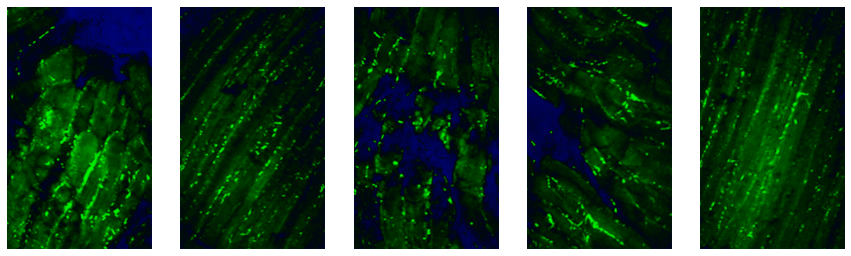

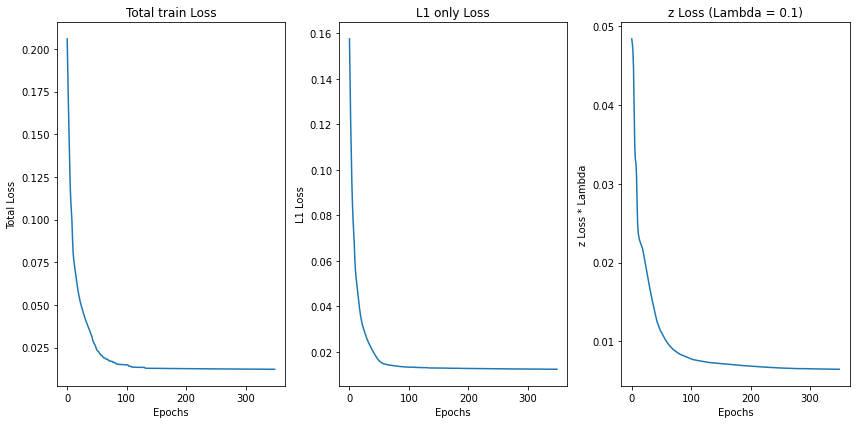

 35%|██████████████                          | 351/1000 [01:53<04:30,  2.40it/s]

Epoch: 351 	Training Loss Total: 0.012365 	L1 only: 0.012365 	Z Loss*Lambda: 0.006468


 35%|██████████████                          | 352/1000 [01:53<04:09,  2.60it/s]

Epoch: 352 	Training Loss Total: 0.012369 	L1 only: 0.012369 	Z Loss*Lambda: 0.006467


 35%|██████████████                          | 353/1000 [01:53<03:55,  2.75it/s]

Epoch: 353 	Training Loss Total: 0.012365 	L1 only: 0.012365 	Z Loss*Lambda: 0.006466


 35%|██████████████▏                         | 354/1000 [01:53<03:45,  2.86it/s]

Epoch: 354 	Training Loss Total: 0.012365 	L1 only: 0.012365 	Z Loss*Lambda: 0.006466


 36%|██████████████▏                         | 355/1000 [01:54<03:38,  2.95it/s]

Epoch: 355 	Training Loss Total: 0.012366 	L1 only: 0.012366 	Z Loss*Lambda: 0.006466


 36%|██████████████▏                         | 356/1000 [01:54<03:33,  3.01it/s]

Epoch: 356 	Training Loss Total: 0.012358 	L1 only: 0.012358 	Z Loss*Lambda: 0.006466


 36%|██████████████▎                         | 357/1000 [01:54<03:30,  3.06it/s]

Epoch: 357 	Training Loss Total: 0.012359 	L1 only: 0.012359 	Z Loss*Lambda: 0.006465


 36%|██████████████▎                         | 358/1000 [01:55<03:27,  3.10it/s]

Epoch: 358 	Training Loss Total: 0.012352 	L1 only: 0.012352 	Z Loss*Lambda: 0.006465


 36%|██████████████▎                         | 359/1000 [01:55<03:25,  3.12it/s]

Epoch: 359 	Training Loss Total: 0.012342 	L1 only: 0.012342 	Z Loss*Lambda: 0.006465


 36%|██████████████▍                         | 360/1000 [01:55<03:24,  3.13it/s]

Epoch: 360 	Training Loss Total: 0.012344 	L1 only: 0.012344 	Z Loss*Lambda: 0.006465


 36%|██████████████▍                         | 361/1000 [01:56<03:23,  3.14it/s]

Epoch: 361 	Training Loss Total: 0.012351 	L1 only: 0.012351 	Z Loss*Lambda: 0.006465


 36%|██████████████▍                         | 362/1000 [01:56<03:22,  3.16it/s]

Epoch: 362 	Training Loss Total: 0.012356 	L1 only: 0.012356 	Z Loss*Lambda: 0.006465


 36%|██████████████▌                         | 363/1000 [01:56<03:21,  3.16it/s]

Epoch: 363 	Training Loss Total: 0.012344 	L1 only: 0.012344 	Z Loss*Lambda: 0.006465


 36%|██████████████▌                         | 364/1000 [01:57<03:21,  3.16it/s]

Epoch: 364 	Training Loss Total: 0.012326 	L1 only: 0.012326 	Z Loss*Lambda: 0.006464


 36%|██████████████▌                         | 365/1000 [01:57<03:20,  3.17it/s]

Epoch: 365 	Training Loss Total: 0.012321 	L1 only: 0.012321 	Z Loss*Lambda: 0.006464


 37%|██████████████▋                         | 366/1000 [01:57<03:20,  3.17it/s]

Epoch: 366 	Training Loss Total: 0.012320 	L1 only: 0.012320 	Z Loss*Lambda: 0.006464


 37%|██████████████▋                         | 367/1000 [01:58<03:20,  3.16it/s]

Epoch: 367 	Training Loss Total: 0.012326 	L1 only: 0.012326 	Z Loss*Lambda: 0.006463


 37%|██████████████▋                         | 368/1000 [01:58<03:19,  3.17it/s]

Epoch: 368 	Training Loss Total: 0.012329 	L1 only: 0.012329 	Z Loss*Lambda: 0.006464


 37%|██████████████▊                         | 369/1000 [01:58<03:18,  3.17it/s]

Epoch: 369 	Training Loss Total: 0.012331 	L1 only: 0.012331 	Z Loss*Lambda: 0.006463


 37%|██████████████▊                         | 370/1000 [01:59<03:18,  3.17it/s]

Epoch: 370 	Training Loss Total: 0.012338 	L1 only: 0.012338 	Z Loss*Lambda: 0.006463


 37%|██████████████▊                         | 371/1000 [01:59<03:18,  3.17it/s]

Epoch: 371 	Training Loss Total: 0.012338 	L1 only: 0.012338 	Z Loss*Lambda: 0.006463


 37%|██████████████▉                         | 372/1000 [01:59<03:18,  3.17it/s]

Epoch: 372 	Training Loss Total: 0.012342 	L1 only: 0.012342 	Z Loss*Lambda: 0.006462


 37%|██████████████▉                         | 373/1000 [01:59<03:17,  3.17it/s]

Epoch: 373 	Training Loss Total: 0.012337 	L1 only: 0.012337 	Z Loss*Lambda: 0.006462


 37%|██████████████▉                         | 374/1000 [02:00<03:17,  3.17it/s]

Epoch: 374 	Training Loss Total: 0.012326 	L1 only: 0.012326 	Z Loss*Lambda: 0.006462


 38%|███████████████                         | 375/1000 [02:00<03:17,  3.17it/s]

Epoch: 375 	Training Loss Total: 0.012309 	L1 only: 0.012309 	Z Loss*Lambda: 0.006462


 38%|███████████████                         | 376/1000 [02:00<03:16,  3.17it/s]

Epoch: 376 	Training Loss Total: 0.012306 	L1 only: 0.012306 	Z Loss*Lambda: 0.006462


 38%|███████████████                         | 377/1000 [02:01<03:16,  3.17it/s]

Epoch: 377 	Training Loss Total: 0.012305 	L1 only: 0.012305 	Z Loss*Lambda: 0.006462


 38%|███████████████                         | 378/1000 [02:01<03:16,  3.17it/s]

Epoch: 378 	Training Loss Total: 0.012317 	L1 only: 0.012317 	Z Loss*Lambda: 0.006463


 38%|███████████████▏                        | 379/1000 [02:01<03:15,  3.17it/s]

Epoch: 379 	Training Loss Total: 0.012321 	L1 only: 0.012321 	Z Loss*Lambda: 0.006463


 38%|███████████████▏                        | 380/1000 [02:02<03:15,  3.17it/s]

Epoch: 380 	Training Loss Total: 0.012337 	L1 only: 0.012337 	Z Loss*Lambda: 0.006462


 38%|███████████████▏                        | 381/1000 [02:02<03:15,  3.17it/s]

Epoch: 381 	Training Loss Total: 0.012345 	L1 only: 0.012345 	Z Loss*Lambda: 0.006462


 38%|███████████████▎                        | 382/1000 [02:02<03:15,  3.17it/s]

Epoch: 382 	Training Loss Total: 0.012350 	L1 only: 0.012350 	Z Loss*Lambda: 0.006462


 38%|███████████████▎                        | 383/1000 [02:03<03:14,  3.17it/s]

Epoch: 383 	Training Loss Total: 0.012370 	L1 only: 0.012370 	Z Loss*Lambda: 0.006462


 38%|███████████████▎                        | 384/1000 [02:03<03:14,  3.17it/s]

Epoch: 384 	Training Loss Total: 0.012368 	L1 only: 0.012368 	Z Loss*Lambda: 0.006462


 38%|███████████████▍                        | 385/1000 [02:03<03:14,  3.17it/s]

Epoch: 385 	Training Loss Total: 0.012331 	L1 only: 0.012331 	Z Loss*Lambda: 0.006463


 39%|███████████████▍                        | 386/1000 [02:04<03:14,  3.16it/s]

Epoch: 386 	Training Loss Total: 0.012296 	L1 only: 0.012296 	Z Loss*Lambda: 0.006464


 39%|███████████████▍                        | 387/1000 [02:04<03:13,  3.16it/s]

Epoch: 387 	Training Loss Total: 0.012299 	L1 only: 0.012299 	Z Loss*Lambda: 0.006465


 39%|███████████████▌                        | 388/1000 [02:04<03:13,  3.17it/s]

Epoch: 388 	Training Loss Total: 0.012307 	L1 only: 0.012307 	Z Loss*Lambda: 0.006465


 39%|███████████████▌                        | 389/1000 [02:05<03:12,  3.17it/s]

Epoch: 389 	Training Loss Total: 0.012304 	L1 only: 0.012304 	Z Loss*Lambda: 0.006465


 39%|███████████████▌                        | 390/1000 [02:05<03:12,  3.17it/s]

Epoch: 390 	Training Loss Total: 0.012318 	L1 only: 0.012318 	Z Loss*Lambda: 0.006465


 39%|███████████████▋                        | 391/1000 [02:05<03:12,  3.17it/s]

Epoch: 391 	Training Loss Total: 0.012352 	L1 only: 0.012352 	Z Loss*Lambda: 0.006465


 39%|███████████████▋                        | 392/1000 [02:05<03:11,  3.17it/s]

Epoch: 392 	Training Loss Total: 0.012340 	L1 only: 0.012340 	Z Loss*Lambda: 0.006466


 39%|███████████████▋                        | 393/1000 [02:06<03:11,  3.16it/s]

Epoch: 393 	Training Loss Total: 0.012303 	L1 only: 0.012303 	Z Loss*Lambda: 0.006466


 39%|███████████████▊                        | 394/1000 [02:06<03:11,  3.17it/s]

Epoch: 394 	Training Loss Total: 0.012296 	L1 only: 0.012296 	Z Loss*Lambda: 0.006467


 40%|███████████████▊                        | 395/1000 [02:06<03:10,  3.17it/s]

Epoch: 395 	Training Loss Total: 0.012298 	L1 only: 0.012298 	Z Loss*Lambda: 0.006468


 40%|███████████████▊                        | 396/1000 [02:07<03:10,  3.16it/s]

Epoch: 396 	Training Loss Total: 0.012309 	L1 only: 0.012309 	Z Loss*Lambda: 0.006468


 40%|███████████████▉                        | 397/1000 [02:07<03:10,  3.16it/s]

Epoch: 397 	Training Loss Total: 0.012298 	L1 only: 0.012298 	Z Loss*Lambda: 0.006469


 40%|███████████████▉                        | 398/1000 [02:07<03:10,  3.17it/s]

Epoch: 398 	Training Loss Total: 0.012298 	L1 only: 0.012298 	Z Loss*Lambda: 0.006469


 40%|███████████████▉                        | 399/1000 [02:08<03:09,  3.17it/s]

Epoch: 399 	Training Loss Total: 0.012291 	L1 only: 0.012291 	Z Loss*Lambda: 0.006470
Epoch: 400 	Training Loss Total: 0.012287 	L1 only: 0.012287 	Z Loss*Lambda: 0.006471


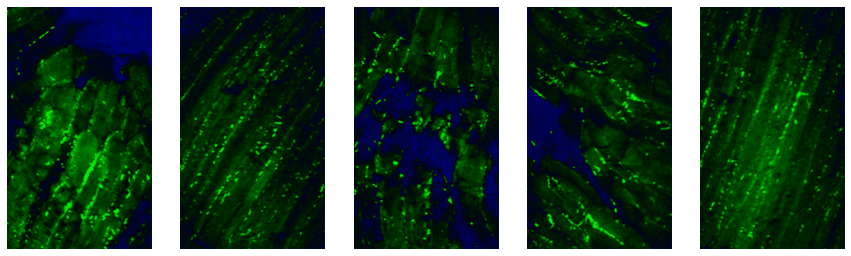

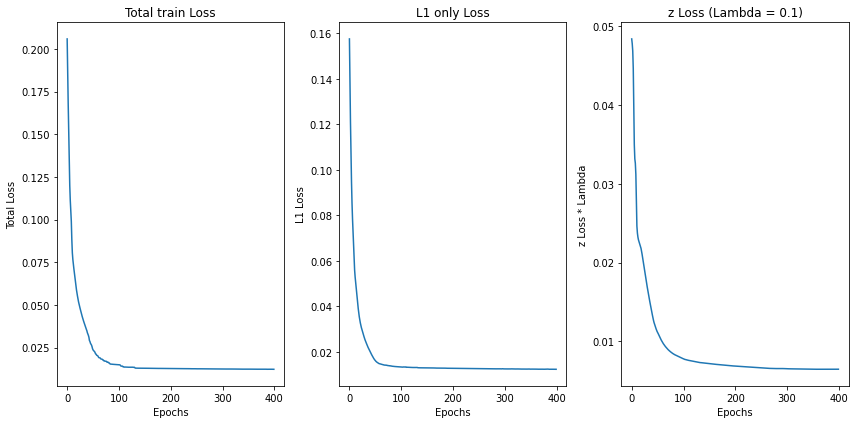

 40%|████████████████                        | 401/1000 [02:09<04:19,  2.31it/s]

Epoch: 401 	Training Loss Total: 0.012296 	L1 only: 0.012296 	Z Loss*Lambda: 0.006471


 40%|████████████████                        | 402/1000 [02:09<03:57,  2.52it/s]

Epoch: 402 	Training Loss Total: 0.012304 	L1 only: 0.012304 	Z Loss*Lambda: 0.006472


 40%|████████████████                        | 403/1000 [02:09<03:42,  2.68it/s]

Epoch: 403 	Training Loss Total: 0.012303 	L1 only: 0.012303 	Z Loss*Lambda: 0.006473


 40%|████████████████▏                       | 404/1000 [02:10<03:31,  2.82it/s]

Epoch: 404 	Training Loss Total: 0.012308 	L1 only: 0.012308 	Z Loss*Lambda: 0.006473


 40%|████████████████▏                       | 405/1000 [02:10<03:24,  2.91it/s]

Epoch: 405 	Training Loss Total: 0.012298 	L1 only: 0.012298 	Z Loss*Lambda: 0.006474


 41%|████████████████▏                       | 406/1000 [02:10<03:19,  2.98it/s]

Epoch: 406 	Training Loss Total: 0.012286 	L1 only: 0.012286 	Z Loss*Lambda: 0.006475


 41%|████████████████▎                       | 407/1000 [02:11<03:15,  3.03it/s]

Epoch: 407 	Training Loss Total: 0.012276 	L1 only: 0.012276 	Z Loss*Lambda: 0.006475


 41%|████████████████▎                       | 408/1000 [02:11<03:12,  3.08it/s]

Epoch: 408 	Training Loss Total: 0.012273 	L1 only: 0.012273 	Z Loss*Lambda: 0.006477


 41%|████████████████▎                       | 409/1000 [02:11<03:10,  3.11it/s]

Epoch: 409 	Training Loss Total: 0.012278 	L1 only: 0.012278 	Z Loss*Lambda: 0.006478


 41%|████████████████▍                       | 410/1000 [02:12<03:08,  3.13it/s]

Epoch: 410 	Training Loss Total: 0.012284 	L1 only: 0.012284 	Z Loss*Lambda: 0.006479


 41%|████████████████▍                       | 411/1000 [02:12<03:07,  3.14it/s]

Epoch: 411 	Training Loss Total: 0.012310 	L1 only: 0.012310 	Z Loss*Lambda: 0.006479


 41%|████████████████▍                       | 412/1000 [02:12<03:06,  3.14it/s]

Epoch: 412 	Training Loss Total: 0.012296 	L1 only: 0.012296 	Z Loss*Lambda: 0.006481


 41%|████████████████▌                       | 413/1000 [02:13<03:06,  3.15it/s]

Epoch: 413 	Training Loss Total: 0.012271 	L1 only: 0.012271 	Z Loss*Lambda: 0.006482


 41%|████████████████▌                       | 414/1000 [02:13<03:06,  3.15it/s]

Epoch: 414 	Training Loss Total: 0.012271 	L1 only: 0.012271 	Z Loss*Lambda: 0.006484


 42%|████████████████▌                       | 415/1000 [02:13<03:05,  3.16it/s]

Epoch: 415 	Training Loss Total: 0.012283 	L1 only: 0.012283 	Z Loss*Lambda: 0.006485


 42%|████████████████▋                       | 416/1000 [02:14<03:04,  3.16it/s]

Epoch: 416 	Training Loss Total: 0.012286 	L1 only: 0.012286 	Z Loss*Lambda: 0.006486


 42%|████████████████▋                       | 417/1000 [02:14<03:04,  3.16it/s]

Epoch: 417 	Training Loss Total: 0.012287 	L1 only: 0.012287 	Z Loss*Lambda: 0.006487


 42%|████████████████▋                       | 418/1000 [02:14<03:04,  3.16it/s]

Epoch: 418 	Training Loss Total: 0.012275 	L1 only: 0.012275 	Z Loss*Lambda: 0.006488


 42%|████████████████▊                       | 419/1000 [02:15<03:04,  3.16it/s]

Epoch: 419 	Training Loss Total: 0.012266 	L1 only: 0.012266 	Z Loss*Lambda: 0.006490


 42%|████████████████▊                       | 420/1000 [02:15<03:03,  3.16it/s]

Epoch: 420 	Training Loss Total: 0.012272 	L1 only: 0.012272 	Z Loss*Lambda: 0.006491


 42%|████████████████▊                       | 421/1000 [02:15<03:03,  3.16it/s]

Epoch: 421 	Training Loss Total: 0.012274 	L1 only: 0.012274 	Z Loss*Lambda: 0.006492


 42%|████████████████▉                       | 422/1000 [02:16<03:03,  3.15it/s]

Epoch: 422 	Training Loss Total: 0.012270 	L1 only: 0.012270 	Z Loss*Lambda: 0.006494


 42%|████████████████▉                       | 423/1000 [02:16<03:02,  3.15it/s]

Epoch: 423 	Training Loss Total: 0.012260 	L1 only: 0.012260 	Z Loss*Lambda: 0.006495


 42%|████████████████▉                       | 424/1000 [02:16<03:02,  3.16it/s]

Epoch: 424 	Training Loss Total: 0.012272 	L1 only: 0.012272 	Z Loss*Lambda: 0.006496


 42%|█████████████████                       | 425/1000 [02:16<03:01,  3.17it/s]

Epoch: 425 	Training Loss Total: 0.012279 	L1 only: 0.012279 	Z Loss*Lambda: 0.006497


 43%|█████████████████                       | 426/1000 [02:17<03:01,  3.16it/s]

Epoch: 426 	Training Loss Total: 0.012285 	L1 only: 0.012285 	Z Loss*Lambda: 0.006498


 43%|█████████████████                       | 427/1000 [02:17<03:01,  3.16it/s]

Epoch: 427 	Training Loss Total: 0.012285 	L1 only: 0.012285 	Z Loss*Lambda: 0.006498


 43%|█████████████████                       | 428/1000 [02:17<03:01,  3.15it/s]

Epoch: 428 	Training Loss Total: 0.012272 	L1 only: 0.012272 	Z Loss*Lambda: 0.006499


 43%|█████████████████▏                      | 429/1000 [02:18<03:00,  3.16it/s]

Epoch: 429 	Training Loss Total: 0.012257 	L1 only: 0.012257 	Z Loss*Lambda: 0.006500


 43%|█████████████████▏                      | 430/1000 [02:18<03:00,  3.16it/s]

Epoch: 430 	Training Loss Total: 0.012254 	L1 only: 0.012254 	Z Loss*Lambda: 0.006502


 43%|█████████████████▏                      | 431/1000 [02:18<02:59,  3.16it/s]

Epoch: 431 	Training Loss Total: 0.012255 	L1 only: 0.012255 	Z Loss*Lambda: 0.006503


 43%|█████████████████▎                      | 432/1000 [02:19<02:59,  3.16it/s]

Epoch: 432 	Training Loss Total: 0.012267 	L1 only: 0.012267 	Z Loss*Lambda: 0.006504


 43%|█████████████████▎                      | 433/1000 [02:19<02:59,  3.16it/s]

Epoch: 433 	Training Loss Total: 0.012277 	L1 only: 0.012277 	Z Loss*Lambda: 0.006506


 43%|█████████████████▎                      | 434/1000 [02:19<02:59,  3.16it/s]

Epoch: 434 	Training Loss Total: 0.012275 	L1 only: 0.012275 	Z Loss*Lambda: 0.006507


 44%|█████████████████▍                      | 435/1000 [02:20<02:59,  3.16it/s]

Epoch: 435 	Training Loss Total: 0.012265 	L1 only: 0.012265 	Z Loss*Lambda: 0.006508


 44%|█████████████████▍                      | 436/1000 [02:20<02:58,  3.15it/s]

Epoch: 436 	Training Loss Total: 0.012268 	L1 only: 0.012268 	Z Loss*Lambda: 0.006509


 44%|█████████████████▍                      | 437/1000 [02:20<02:58,  3.15it/s]

Epoch: 437 	Training Loss Total: 0.012263 	L1 only: 0.012263 	Z Loss*Lambda: 0.006510


 44%|█████████████████▌                      | 438/1000 [02:21<02:58,  3.15it/s]

Epoch: 438 	Training Loss Total: 0.012245 	L1 only: 0.012245 	Z Loss*Lambda: 0.006512


 44%|█████████████████▌                      | 439/1000 [02:21<02:58,  3.15it/s]

Epoch: 439 	Training Loss Total: 0.012231 	L1 only: 0.012231 	Z Loss*Lambda: 0.006513


 44%|█████████████████▌                      | 440/1000 [02:21<02:57,  3.15it/s]

Epoch: 440 	Training Loss Total: 0.012229 	L1 only: 0.012229 	Z Loss*Lambda: 0.006515


 44%|█████████████████▋                      | 441/1000 [02:22<02:56,  3.16it/s]

Epoch: 441 	Training Loss Total: 0.012238 	L1 only: 0.012238 	Z Loss*Lambda: 0.006516


 44%|█████████████████▋                      | 442/1000 [02:22<02:56,  3.16it/s]

Epoch: 442 	Training Loss Total: 0.012254 	L1 only: 0.012254 	Z Loss*Lambda: 0.006518


 44%|█████████████████▋                      | 443/1000 [02:22<02:56,  3.16it/s]

Epoch: 443 	Training Loss Total: 0.012282 	L1 only: 0.012282 	Z Loss*Lambda: 0.006519


 44%|█████████████████▊                      | 444/1000 [02:22<02:55,  3.16it/s]

Epoch: 444 	Training Loss Total: 0.012309 	L1 only: 0.012309 	Z Loss*Lambda: 0.006519


 44%|█████████████████▊                      | 445/1000 [02:23<02:55,  3.16it/s]

Epoch: 445 	Training Loss Total: 0.012275 	L1 only: 0.012275 	Z Loss*Lambda: 0.006520


 45%|█████████████████▊                      | 446/1000 [02:23<02:55,  3.16it/s]

Epoch: 446 	Training Loss Total: 0.012236 	L1 only: 0.012236 	Z Loss*Lambda: 0.006522


 45%|█████████████████▉                      | 447/1000 [02:23<02:55,  3.16it/s]

Epoch: 447 	Training Loss Total: 0.012227 	L1 only: 0.012227 	Z Loss*Lambda: 0.006523


 45%|█████████████████▉                      | 448/1000 [02:24<02:55,  3.15it/s]

Epoch: 448 	Training Loss Total: 0.012224 	L1 only: 0.012224 	Z Loss*Lambda: 0.006525


 45%|█████████████████▉                      | 449/1000 [02:24<02:54,  3.15it/s]

Epoch: 449 	Training Loss Total: 0.012236 	L1 only: 0.012236 	Z Loss*Lambda: 0.006527
Epoch: 450 	Training Loss Total: 0.012260 	L1 only: 0.012260 	Z Loss*Lambda: 0.006529


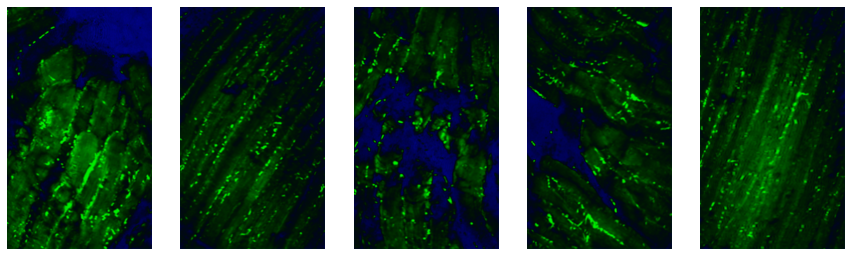

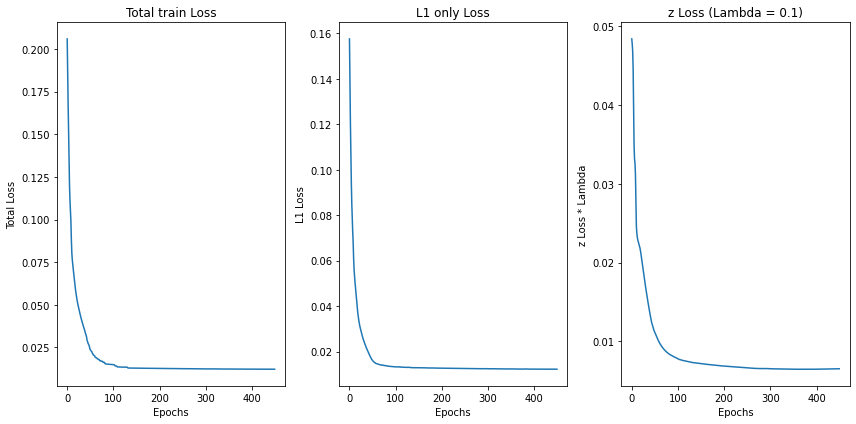

 45%|██████████████████                      | 451/1000 [02:25<03:50,  2.39it/s]

Epoch: 451 	Training Loss Total: 0.012272 	L1 only: 0.012272 	Z Loss*Lambda: 0.006530


 45%|██████████████████                      | 452/1000 [02:25<03:32,  2.58it/s]

Epoch: 452 	Training Loss Total: 0.012251 	L1 only: 0.012251 	Z Loss*Lambda: 0.006531


 45%|██████████████████                      | 453/1000 [02:26<03:20,  2.73it/s]

Epoch: 453 	Training Loss Total: 0.012232 	L1 only: 0.012232 	Z Loss*Lambda: 0.006533


 45%|██████████████████▏                     | 454/1000 [02:26<03:11,  2.85it/s]

Epoch: 454 	Training Loss Total: 0.012225 	L1 only: 0.012225 	Z Loss*Lambda: 0.006534


 46%|██████████████████▏                     | 455/1000 [02:26<03:05,  2.94it/s]

Epoch: 455 	Training Loss Total: 0.012231 	L1 only: 0.012231 	Z Loss*Lambda: 0.006536


 46%|██████████████████▏                     | 456/1000 [02:27<03:01,  3.00it/s]

Epoch: 456 	Training Loss Total: 0.012243 	L1 only: 0.012243 	Z Loss*Lambda: 0.006537


 46%|██████████████████▎                     | 457/1000 [02:27<02:58,  3.04it/s]

Epoch: 457 	Training Loss Total: 0.012243 	L1 only: 0.012243 	Z Loss*Lambda: 0.006538


 46%|██████████████████▎                     | 458/1000 [02:27<02:56,  3.08it/s]

Epoch: 458 	Training Loss Total: 0.012250 	L1 only: 0.012250 	Z Loss*Lambda: 0.006539


 46%|██████████████████▎                     | 459/1000 [02:28<02:54,  3.10it/s]

Epoch: 459 	Training Loss Total: 0.012256 	L1 only: 0.012256 	Z Loss*Lambda: 0.006541


 46%|██████████████████▍                     | 460/1000 [02:28<02:53,  3.12it/s]

Epoch: 460 	Training Loss Total: 0.012257 	L1 only: 0.012257 	Z Loss*Lambda: 0.006542


 46%|██████████████████▍                     | 461/1000 [02:28<02:52,  3.13it/s]

Epoch: 461 	Training Loss Total: 0.012239 	L1 only: 0.012239 	Z Loss*Lambda: 0.006544


 46%|██████████████████▍                     | 462/1000 [02:29<02:51,  3.14it/s]

Epoch: 462 	Training Loss Total: 0.012221 	L1 only: 0.012221 	Z Loss*Lambda: 0.006546


 46%|██████████████████▌                     | 463/1000 [02:29<02:50,  3.14it/s]

Epoch: 463 	Training Loss Total: 0.012214 	L1 only: 0.012214 	Z Loss*Lambda: 0.006547


 46%|██████████████████▌                     | 464/1000 [02:29<02:50,  3.14it/s]

Epoch: 464 	Training Loss Total: 0.012213 	L1 only: 0.012213 	Z Loss*Lambda: 0.006549


 46%|██████████████████▌                     | 465/1000 [02:30<02:50,  3.15it/s]

Epoch: 465 	Training Loss Total: 0.012228 	L1 only: 0.012228 	Z Loss*Lambda: 0.006550


 47%|██████████████████▋                     | 466/1000 [02:30<02:49,  3.15it/s]

Epoch: 466 	Training Loss Total: 0.012272 	L1 only: 0.012272 	Z Loss*Lambda: 0.006551


 47%|██████████████████▋                     | 467/1000 [02:30<02:49,  3.15it/s]

Epoch: 467 	Training Loss Total: 0.012278 	L1 only: 0.012278 	Z Loss*Lambda: 0.006553


 47%|██████████████████▋                     | 468/1000 [02:31<02:48,  3.15it/s]

Epoch: 468 	Training Loss Total: 0.012226 	L1 only: 0.012226 	Z Loss*Lambda: 0.006555


 47%|██████████████████▊                     | 469/1000 [02:31<02:48,  3.15it/s]

Epoch: 469 	Training Loss Total: 0.012202 	L1 only: 0.012202 	Z Loss*Lambda: 0.006557


 47%|██████████████████▊                     | 470/1000 [02:31<02:48,  3.15it/s]

Epoch: 470 	Training Loss Total: 0.012203 	L1 only: 0.012203 	Z Loss*Lambda: 0.006558


 47%|██████████████████▊                     | 471/1000 [02:32<02:47,  3.15it/s]

Epoch: 471 	Training Loss Total: 0.012222 	L1 only: 0.012222 	Z Loss*Lambda: 0.006560


 47%|██████████████████▉                     | 472/1000 [02:32<02:47,  3.15it/s]

Epoch: 472 	Training Loss Total: 0.012257 	L1 only: 0.012257 	Z Loss*Lambda: 0.006561


 47%|██████████████████▉                     | 473/1000 [02:32<02:47,  3.15it/s]

Epoch: 473 	Training Loss Total: 0.012253 	L1 only: 0.012253 	Z Loss*Lambda: 0.006563


 47%|██████████████████▉                     | 474/1000 [02:32<02:47,  3.15it/s]

Epoch: 474 	Training Loss Total: 0.012220 	L1 only: 0.012220 	Z Loss*Lambda: 0.006564


 48%|███████████████████                     | 475/1000 [02:33<02:46,  3.15it/s]

Epoch: 475 	Training Loss Total: 0.012217 	L1 only: 0.012217 	Z Loss*Lambda: 0.006565


 48%|███████████████████                     | 476/1000 [02:33<02:46,  3.15it/s]

Epoch: 476 	Training Loss Total: 0.012220 	L1 only: 0.012220 	Z Loss*Lambda: 0.006567


 48%|███████████████████                     | 477/1000 [02:33<02:45,  3.15it/s]

Epoch: 477 	Training Loss Total: 0.012212 	L1 only: 0.012212 	Z Loss*Lambda: 0.006569


 48%|███████████████████                     | 478/1000 [02:34<02:45,  3.15it/s]

Epoch: 478 	Training Loss Total: 0.012200 	L1 only: 0.012200 	Z Loss*Lambda: 0.006570


 48%|███████████████████▏                    | 479/1000 [02:34<02:45,  3.15it/s]

Epoch: 479 	Training Loss Total: 0.012194 	L1 only: 0.012194 	Z Loss*Lambda: 0.006572


 48%|███████████████████▏                    | 480/1000 [02:34<02:44,  3.16it/s]

Epoch: 480 	Training Loss Total: 0.012191 	L1 only: 0.012191 	Z Loss*Lambda: 0.006574


 48%|███████████████████▏                    | 481/1000 [02:35<02:44,  3.16it/s]

Epoch: 481 	Training Loss Total: 0.012189 	L1 only: 0.012189 	Z Loss*Lambda: 0.006575


 48%|███████████████████▎                    | 482/1000 [02:35<02:44,  3.15it/s]

Epoch: 482 	Training Loss Total: 0.012195 	L1 only: 0.012195 	Z Loss*Lambda: 0.006577


 48%|███████████████████▎                    | 483/1000 [02:35<02:44,  3.15it/s]

Epoch: 483 	Training Loss Total: 0.012213 	L1 only: 0.012213 	Z Loss*Lambda: 0.006578


 48%|███████████████████▎                    | 484/1000 [02:36<02:43,  3.15it/s]

Epoch: 484 	Training Loss Total: 0.012237 	L1 only: 0.012237 	Z Loss*Lambda: 0.006579


 48%|███████████████████▍                    | 485/1000 [02:36<02:43,  3.15it/s]

Epoch: 485 	Training Loss Total: 0.012266 	L1 only: 0.012266 	Z Loss*Lambda: 0.006580


 49%|███████████████████▍                    | 486/1000 [02:36<02:43,  3.15it/s]

Epoch: 486 	Training Loss Total: 0.012255 	L1 only: 0.012255 	Z Loss*Lambda: 0.006582


 49%|███████████████████▍                    | 487/1000 [02:37<02:42,  3.15it/s]

Epoch: 487 	Training Loss Total: 0.012199 	L1 only: 0.012199 	Z Loss*Lambda: 0.006586


 49%|███████████████████▌                    | 488/1000 [02:37<02:42,  3.15it/s]

Epoch: 488 	Training Loss Total: 0.012177 	L1 only: 0.012177 	Z Loss*Lambda: 0.006587


 49%|███████████████████▌                    | 489/1000 [02:37<02:42,  3.15it/s]

Epoch: 489 	Training Loss Total: 0.012178 	L1 only: 0.012178 	Z Loss*Lambda: 0.006589


 49%|███████████████████▌                    | 490/1000 [02:38<02:41,  3.15it/s]

Epoch: 490 	Training Loss Total: 0.012181 	L1 only: 0.012181 	Z Loss*Lambda: 0.006592


 49%|███████████████████▋                    | 491/1000 [02:38<02:41,  3.15it/s]

Epoch: 491 	Training Loss Total: 0.012184 	L1 only: 0.012184 	Z Loss*Lambda: 0.006594


 49%|███████████████████▋                    | 492/1000 [02:38<02:41,  3.15it/s]

Epoch: 492 	Training Loss Total: 0.012199 	L1 only: 0.012199 	Z Loss*Lambda: 0.006595


 49%|███████████████████▋                    | 493/1000 [02:38<02:40,  3.15it/s]

Epoch: 493 	Training Loss Total: 0.012221 	L1 only: 0.012221 	Z Loss*Lambda: 0.006596


 49%|███████████████████▊                    | 494/1000 [02:39<02:40,  3.15it/s]

Epoch: 494 	Training Loss Total: 0.012269 	L1 only: 0.012269 	Z Loss*Lambda: 0.006597


 50%|███████████████████▊                    | 495/1000 [02:39<02:40,  3.15it/s]

Epoch: 495 	Training Loss Total: 0.012256 	L1 only: 0.012256 	Z Loss*Lambda: 0.006600


 50%|███████████████████▊                    | 496/1000 [02:39<02:39,  3.15it/s]

Epoch: 496 	Training Loss Total: 0.012183 	L1 only: 0.012183 	Z Loss*Lambda: 0.006604


 50%|███████████████████▉                    | 497/1000 [02:40<02:39,  3.15it/s]

Epoch: 497 	Training Loss Total: 0.012170 	L1 only: 0.012170 	Z Loss*Lambda: 0.006604


 50%|███████████████████▉                    | 498/1000 [02:40<02:39,  3.15it/s]

Epoch: 498 	Training Loss Total: 0.012168 	L1 only: 0.012168 	Z Loss*Lambda: 0.006607


 50%|███████████████████▉                    | 499/1000 [02:40<02:38,  3.15it/s]

Epoch: 499 	Training Loss Total: 0.012168 	L1 only: 0.012168 	Z Loss*Lambda: 0.006610
Epoch: 500 	Training Loss Total: 0.012164 	L1 only: 0.012164 	Z Loss*Lambda: 0.006612


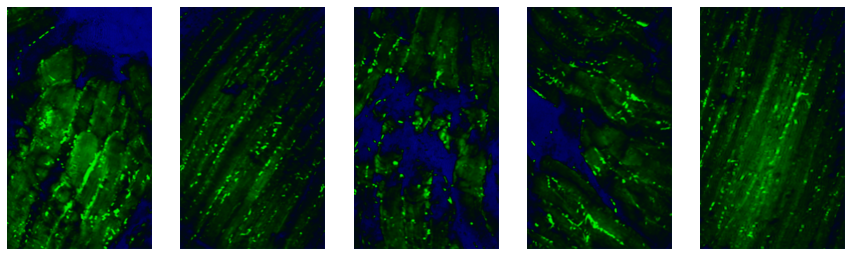

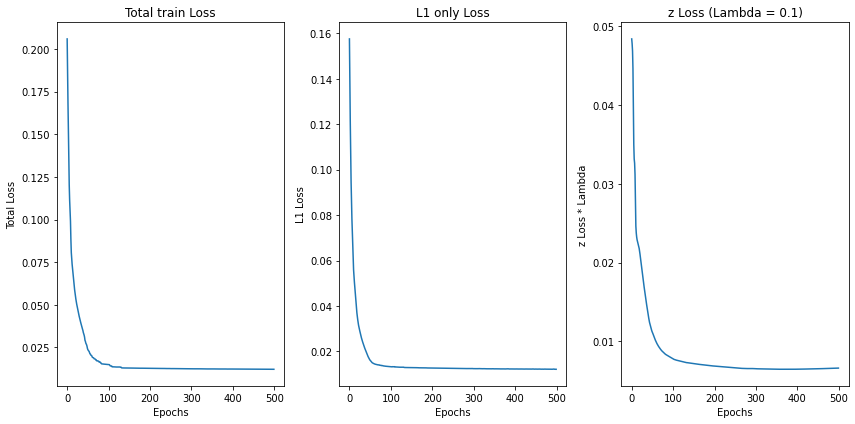

 50%|████████████████████                    | 501/1000 [02:42<03:37,  2.30it/s]

Epoch: 501 	Training Loss Total: 0.012165 	L1 only: 0.012165 	Z Loss*Lambda: 0.006614


 50%|████████████████████                    | 502/1000 [02:42<03:18,  2.51it/s]

Epoch: 502 	Training Loss Total: 0.012165 	L1 only: 0.012165 	Z Loss*Lambda: 0.006615


 50%|████████████████████                    | 503/1000 [02:42<03:05,  2.68it/s]

Epoch: 503 	Training Loss Total: 0.012168 	L1 only: 0.012168 	Z Loss*Lambda: 0.006617


 50%|████████████████████▏                   | 504/1000 [02:43<02:56,  2.81it/s]

Epoch: 504 	Training Loss Total: 0.012182 	L1 only: 0.012182 	Z Loss*Lambda: 0.006619


 50%|████████████████████▏                   | 505/1000 [02:43<02:50,  2.91it/s]

Epoch: 505 	Training Loss Total: 0.012207 	L1 only: 0.012207 	Z Loss*Lambda: 0.006621


 51%|████████████████████▏                   | 506/1000 [02:43<02:45,  2.98it/s]

Epoch: 506 	Training Loss Total: 0.012256 	L1 only: 0.012256 	Z Loss*Lambda: 0.006621


 51%|████████████████████▎                   | 507/1000 [02:43<02:42,  3.03it/s]

Epoch: 507 	Training Loss Total: 0.012428 	L1 only: 0.012428 	Z Loss*Lambda: 0.006620


 51%|████████████████████▎                   | 508/1000 [02:44<02:40,  3.06it/s]

Epoch: 508 	Training Loss Total: 0.012181 	L1 only: 0.012181 	Z Loss*Lambda: 0.006628


 51%|████████████████████▎                   | 509/1000 [02:44<02:38,  3.09it/s]

Epoch: 509 	Training Loss Total: 0.012169 	L1 only: 0.012169 	Z Loss*Lambda: 0.006630


 51%|████████████████████▍                   | 510/1000 [02:44<02:37,  3.11it/s]

Epoch: 510 	Training Loss Total: 0.012209 	L1 only: 0.012209 	Z Loss*Lambda: 0.006634


 51%|████████████████████▍                   | 511/1000 [02:45<02:36,  3.12it/s]

Epoch: 511 	Training Loss Total: 0.012304 	L1 only: 0.012304 	Z Loss*Lambda: 0.006638


 51%|████████████████████▍                   | 512/1000 [02:45<02:35,  3.13it/s]

Epoch: 512 	Training Loss Total: 0.012554 	L1 only: 0.012554 	Z Loss*Lambda: 0.006643


 51%|████████████████████▌                   | 513/1000 [02:45<02:35,  3.14it/s]

Epoch: 513 	Training Loss Total: 0.012190 	L1 only: 0.012190 	Z Loss*Lambda: 0.006651


 51%|████████████████████▌                   | 514/1000 [02:46<02:34,  3.14it/s]

Epoch: 514 	Training Loss Total: 0.012154 	L1 only: 0.012154 	Z Loss*Lambda: 0.006662


 52%|████████████████████▌                   | 515/1000 [02:46<02:34,  3.15it/s]

Epoch: 515 	Training Loss Total: 0.012144 	L1 only: 0.012144 	Z Loss*Lambda: 0.006655


 52%|████████████████████▋                   | 516/1000 [02:46<02:33,  3.15it/s]

Epoch: 516 	Training Loss Total: 0.012163 	L1 only: 0.012163 	Z Loss*Lambda: 0.006654


 52%|████████████████████▋                   | 517/1000 [02:47<02:33,  3.15it/s]

Epoch: 517 	Training Loss Total: 0.012217 	L1 only: 0.012217 	Z Loss*Lambda: 0.006653


 52%|████████████████████▋                   | 518/1000 [02:47<02:32,  3.16it/s]

Epoch: 518 	Training Loss Total: 0.012332 	L1 only: 0.012332 	Z Loss*Lambda: 0.006655


 52%|████████████████████▊                   | 519/1000 [02:47<02:32,  3.15it/s]

Epoch: 519 	Training Loss Total: 0.012256 	L1 only: 0.012256 	Z Loss*Lambda: 0.006661


 52%|████████████████████▊                   | 520/1000 [02:48<02:32,  3.15it/s]

Epoch: 520 	Training Loss Total: 0.012155 	L1 only: 0.012155 	Z Loss*Lambda: 0.006669


 52%|████████████████████▊                   | 521/1000 [02:48<02:31,  3.15it/s]

Epoch: 521 	Training Loss Total: 0.012139 	L1 only: 0.012139 	Z Loss*Lambda: 0.006671


 52%|████████████████████▉                   | 522/1000 [02:48<02:31,  3.15it/s]

Epoch: 522 	Training Loss Total: 0.012136 	L1 only: 0.012136 	Z Loss*Lambda: 0.006667


 52%|████████████████████▉                   | 523/1000 [02:49<02:31,  3.15it/s]

Epoch: 523 	Training Loss Total: 0.012157 	L1 only: 0.012157 	Z Loss*Lambda: 0.006667


 52%|████████████████████▉                   | 524/1000 [02:49<02:30,  3.15it/s]

Epoch: 524 	Training Loss Total: 0.012211 	L1 only: 0.012211 	Z Loss*Lambda: 0.006667


 52%|█████████████████████                   | 525/1000 [02:49<02:30,  3.15it/s]

Epoch: 525 	Training Loss Total: 0.012305 	L1 only: 0.012305 	Z Loss*Lambda: 0.006670


 53%|█████████████████████                   | 526/1000 [02:50<02:30,  3.15it/s]

Epoch: 526 	Training Loss Total: 0.012281 	L1 only: 0.012281 	Z Loss*Lambda: 0.006676


 53%|█████████████████████                   | 527/1000 [02:50<02:30,  3.15it/s]

Epoch: 527 	Training Loss Total: 0.012155 	L1 only: 0.012155 	Z Loss*Lambda: 0.006684


 53%|█████████████████████                   | 528/1000 [02:50<02:29,  3.15it/s]

Epoch: 528 	Training Loss Total: 0.012136 	L1 only: 0.012136 	Z Loss*Lambda: 0.006687


 53%|█████████████████████▏                  | 529/1000 [02:50<02:29,  3.15it/s]

Epoch: 529 	Training Loss Total: 0.012130 	L1 only: 0.012130 	Z Loss*Lambda: 0.006684


 53%|█████████████████████▏                  | 530/1000 [02:51<02:29,  3.15it/s]

Epoch: 530 	Training Loss Total: 0.012140 	L1 only: 0.012140 	Z Loss*Lambda: 0.006685


 53%|█████████████████████▏                  | 531/1000 [02:51<02:29,  3.15it/s]

Epoch: 531 	Training Loss Total: 0.012162 	L1 only: 0.012162 	Z Loss*Lambda: 0.006685


 53%|█████████████████████▎                  | 532/1000 [02:51<02:28,  3.15it/s]

Epoch: 532 	Training Loss Total: 0.012208 	L1 only: 0.012208 	Z Loss*Lambda: 0.006686


 53%|█████████████████████▎                  | 533/1000 [02:52<02:28,  3.15it/s]

Epoch: 533 	Training Loss Total: 0.012276 	L1 only: 0.012276 	Z Loss*Lambda: 0.006689


 53%|█████████████████████▎                  | 534/1000 [02:52<02:27,  3.15it/s]

Epoch: 534 	Training Loss Total: 0.012261 	L1 only: 0.012261 	Z Loss*Lambda: 0.006694


 54%|█████████████████████▍                  | 535/1000 [02:52<02:27,  3.15it/s]

Epoch: 535 	Training Loss Total: 0.012146 	L1 only: 0.012146 	Z Loss*Lambda: 0.006702


 54%|█████████████████████▍                  | 536/1000 [02:53<02:27,  3.15it/s]

Epoch: 536 	Training Loss Total: 0.012135 	L1 only: 0.012135 	Z Loss*Lambda: 0.006706


 54%|█████████████████████▍                  | 537/1000 [02:53<02:26,  3.15it/s]

Epoch: 537 	Training Loss Total: 0.012127 	L1 only: 0.012127 	Z Loss*Lambda: 0.006703


 54%|█████████████████████▌                  | 538/1000 [02:53<02:26,  3.16it/s]

Epoch: 538 	Training Loss Total: 0.012136 	L1 only: 0.012136 	Z Loss*Lambda: 0.006703


 54%|█████████████████████▌                  | 539/1000 [02:54<02:26,  3.16it/s]

Epoch: 539 	Training Loss Total: 0.012159 	L1 only: 0.012159 	Z Loss*Lambda: 0.006705


 54%|█████████████████████▌                  | 540/1000 [02:54<02:25,  3.15it/s]

Epoch: 540 	Training Loss Total: 0.012211 	L1 only: 0.012211 	Z Loss*Lambda: 0.006706


 54%|█████████████████████▋                  | 541/1000 [02:54<02:25,  3.15it/s]

Epoch: 541 	Training Loss Total: 0.012324 	L1 only: 0.012324 	Z Loss*Lambda: 0.006709


 54%|█████████████████████▋                  | 542/1000 [02:55<02:25,  3.15it/s]

Epoch: 542 	Training Loss Total: 0.012226 	L1 only: 0.012226 	Z Loss*Lambda: 0.006716


 54%|█████████████████████▋                  | 543/1000 [02:55<02:25,  3.15it/s]

Epoch: 543 	Training Loss Total: 0.012142 	L1 only: 0.012142 	Z Loss*Lambda: 0.006725


 54%|█████████████████████▊                  | 544/1000 [02:55<02:24,  3.15it/s]

Epoch: 544 	Training Loss Total: 0.012125 	L1 only: 0.012125 	Z Loss*Lambda: 0.006726


 55%|█████████████████████▊                  | 545/1000 [02:56<02:24,  3.15it/s]

Epoch: 545 	Training Loss Total: 0.012119 	L1 only: 0.012119 	Z Loss*Lambda: 0.006724


 55%|█████████████████████▊                  | 546/1000 [02:56<02:23,  3.15it/s]

Epoch: 546 	Training Loss Total: 0.012121 	L1 only: 0.012121 	Z Loss*Lambda: 0.006726


 55%|█████████████████████▉                  | 547/1000 [02:56<02:23,  3.16it/s]

Epoch: 547 	Training Loss Total: 0.012130 	L1 only: 0.012130 	Z Loss*Lambda: 0.006727


 55%|█████████████████████▉                  | 548/1000 [02:56<02:23,  3.16it/s]

Epoch: 548 	Training Loss Total: 0.012153 	L1 only: 0.012153 	Z Loss*Lambda: 0.006728


 55%|█████████████████████▉                  | 549/1000 [02:57<02:22,  3.16it/s]

Epoch: 549 	Training Loss Total: 0.012209 	L1 only: 0.012209 	Z Loss*Lambda: 0.006730
Epoch: 550 	Training Loss Total: 0.012353 	L1 only: 0.012353 	Z Loss*Lambda: 0.006732


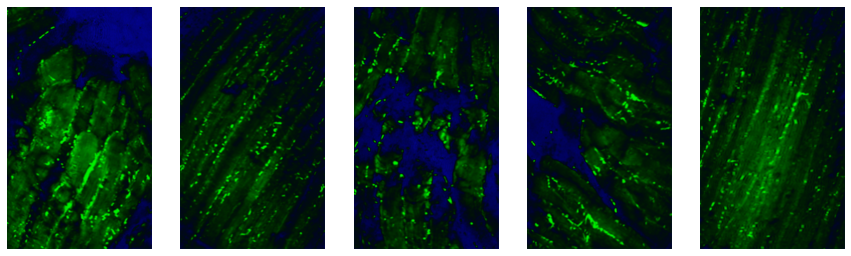

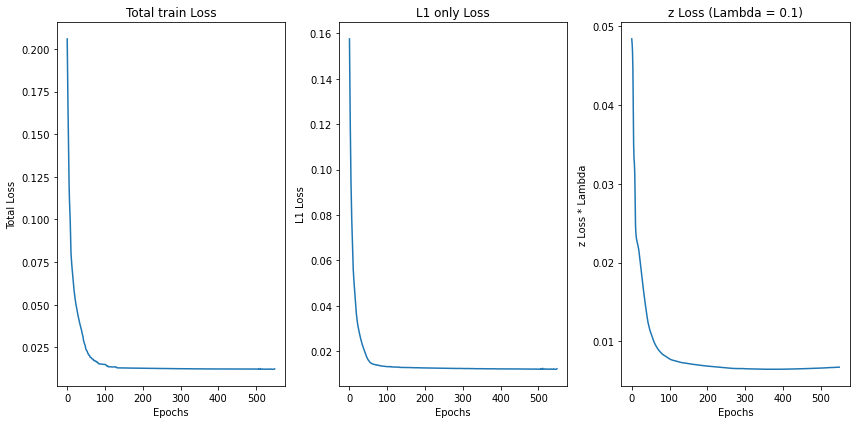

 55%|██████████████████████                  | 551/1000 [02:58<03:08,  2.38it/s]

Epoch: 551 	Training Loss Total: 0.012254 	L1 only: 0.012254 	Z Loss*Lambda: 0.006742


 55%|██████████████████████                  | 552/1000 [02:58<02:53,  2.57it/s]

Epoch: 552 	Training Loss Total: 0.012163 	L1 only: 0.012163 	Z Loss*Lambda: 0.006752


 55%|██████████████████████                  | 553/1000 [02:59<02:44,  2.73it/s]

Epoch: 553 	Training Loss Total: 0.012131 	L1 only: 0.012131 	Z Loss*Lambda: 0.006754


 55%|██████████████████████▏                 | 554/1000 [02:59<02:36,  2.84it/s]

Epoch: 554 	Training Loss Total: 0.012116 	L1 only: 0.012116 	Z Loss*Lambda: 0.006752


 56%|██████████████████████▏                 | 555/1000 [02:59<02:31,  2.93it/s]

Epoch: 555 	Training Loss Total: 0.012120 	L1 only: 0.012120 	Z Loss*Lambda: 0.006756


 56%|██████████████████████▏                 | 556/1000 [03:00<02:28,  2.99it/s]

Epoch: 556 	Training Loss Total: 0.012127 	L1 only: 0.012127 	Z Loss*Lambda: 0.006756


 56%|██████████████████████▎                 | 557/1000 [03:00<02:25,  3.04it/s]

Epoch: 557 	Training Loss Total: 0.012151 	L1 only: 0.012151 	Z Loss*Lambda: 0.006759


 56%|██████████████████████▎                 | 558/1000 [03:00<02:23,  3.07it/s]

Epoch: 558 	Training Loss Total: 0.012192 	L1 only: 0.012192 	Z Loss*Lambda: 0.006761


 56%|██████████████████████▎                 | 559/1000 [03:00<02:22,  3.10it/s]

Epoch: 559 	Training Loss Total: 0.012269 	L1 only: 0.012269 	Z Loss*Lambda: 0.006764


 56%|██████████████████████▍                 | 560/1000 [03:01<02:21,  3.11it/s]

Epoch: 560 	Training Loss Total: 0.012234 	L1 only: 0.012234 	Z Loss*Lambda: 0.006771


 56%|██████████████████████▍                 | 561/1000 [03:01<02:20,  3.13it/s]

Epoch: 561 	Training Loss Total: 0.012130 	L1 only: 0.012130 	Z Loss*Lambda: 0.006782


 56%|██████████████████████▍                 | 562/1000 [03:01<02:19,  3.13it/s]

Epoch: 562 	Training Loss Total: 0.012114 	L1 only: 0.012114 	Z Loss*Lambda: 0.006788


 56%|██████████████████████▌                 | 563/1000 [03:02<02:19,  3.14it/s]

Epoch: 563 	Training Loss Total: 0.012108 	L1 only: 0.012108 	Z Loss*Lambda: 0.006785


 56%|██████████████████████▌                 | 564/1000 [03:02<02:18,  3.14it/s]

Epoch: 564 	Training Loss Total: 0.012112 	L1 only: 0.012112 	Z Loss*Lambda: 0.006787


 56%|██████████████████████▌                 | 565/1000 [03:02<02:18,  3.15it/s]

Epoch: 565 	Training Loss Total: 0.012122 	L1 only: 0.012122 	Z Loss*Lambda: 0.006789


 57%|██████████████████████▋                 | 566/1000 [03:03<02:17,  3.15it/s]

Epoch: 566 	Training Loss Total: 0.012138 	L1 only: 0.012138 	Z Loss*Lambda: 0.006793


 57%|██████████████████████▋                 | 567/1000 [03:03<02:17,  3.15it/s]

Epoch: 567 	Training Loss Total: 0.012182 	L1 only: 0.012182 	Z Loss*Lambda: 0.006795


 57%|██████████████████████▋                 | 568/1000 [03:03<02:17,  3.15it/s]

Epoch: 568 	Training Loss Total: 0.012258 	L1 only: 0.012258 	Z Loss*Lambda: 0.006798


 57%|██████████████████████▊                 | 569/1000 [03:04<02:16,  3.15it/s]

Epoch: 569 	Training Loss Total: 0.012272 	L1 only: 0.012272 	Z Loss*Lambda: 0.006806


 57%|██████████████████████▊                 | 570/1000 [03:04<02:16,  3.15it/s]

Epoch: 570 	Training Loss Total: 0.012129 	L1 only: 0.012129 	Z Loss*Lambda: 0.006819


 57%|██████████████████████▊                 | 571/1000 [03:04<02:16,  3.15it/s]

Epoch: 571 	Training Loss Total: 0.012107 	L1 only: 0.012107 	Z Loss*Lambda: 0.006826


 57%|██████████████████████▉                 | 572/1000 [03:05<02:15,  3.15it/s]

Epoch: 572 	Training Loss Total: 0.012102 	L1 only: 0.012102 	Z Loss*Lambda: 0.006826


 57%|██████████████████████▉                 | 573/1000 [03:05<02:15,  3.15it/s]

Epoch: 573 	Training Loss Total: 0.012105 	L1 only: 0.012105 	Z Loss*Lambda: 0.006828


 57%|██████████████████████▉                 | 574/1000 [03:05<02:15,  3.15it/s]

Epoch: 574 	Training Loss Total: 0.012109 	L1 only: 0.012109 	Z Loss*Lambda: 0.006832


 57%|███████████████████████                 | 575/1000 [03:06<02:14,  3.15it/s]

Epoch: 575 	Training Loss Total: 0.012121 	L1 only: 0.012121 	Z Loss*Lambda: 0.006836


 58%|███████████████████████                 | 576/1000 [03:06<02:14,  3.15it/s]

Epoch: 576 	Training Loss Total: 0.012139 	L1 only: 0.012139 	Z Loss*Lambda: 0.006840


 58%|███████████████████████                 | 577/1000 [03:06<02:14,  3.15it/s]

Epoch: 577 	Training Loss Total: 0.012187 	L1 only: 0.012187 	Z Loss*Lambda: 0.006843


 58%|███████████████████████                 | 578/1000 [03:06<02:13,  3.15it/s]

Epoch: 578 	Training Loss Total: 0.012303 	L1 only: 0.012303 	Z Loss*Lambda: 0.006846


 58%|███████████████████████▏                | 579/1000 [03:07<02:13,  3.15it/s]

Epoch: 579 	Training Loss Total: 0.012285 	L1 only: 0.012285 	Z Loss*Lambda: 0.006856


 58%|███████████████████████▏                | 580/1000 [03:07<02:13,  3.15it/s]

Epoch: 580 	Training Loss Total: 0.012124 	L1 only: 0.012124 	Z Loss*Lambda: 0.006873


 58%|███████████████████████▏                | 581/1000 [03:07<02:13,  3.15it/s]

Epoch: 581 	Training Loss Total: 0.012098 	L1 only: 0.012098 	Z Loss*Lambda: 0.006879


 58%|███████████████████████▎                | 582/1000 [03:08<02:12,  3.15it/s]

Epoch: 582 	Training Loss Total: 0.012098 	L1 only: 0.012098 	Z Loss*Lambda: 0.006878


 58%|███████████████████████▎                | 583/1000 [03:08<02:12,  3.15it/s]

Epoch: 583 	Training Loss Total: 0.012101 	L1 only: 0.012101 	Z Loss*Lambda: 0.006883


 58%|███████████████████████▎                | 584/1000 [03:08<02:12,  3.15it/s]

Epoch: 584 	Training Loss Total: 0.012110 	L1 only: 0.012110 	Z Loss*Lambda: 0.006888


 58%|███████████████████████▍                | 585/1000 [03:09<02:11,  3.15it/s]

Epoch: 585 	Training Loss Total: 0.012126 	L1 only: 0.012126 	Z Loss*Lambda: 0.006893


 59%|███████████████████████▍                | 586/1000 [03:09<02:11,  3.15it/s]

Epoch: 586 	Training Loss Total: 0.012173 	L1 only: 0.012173 	Z Loss*Lambda: 0.006897


 59%|███████████████████████▍                | 587/1000 [03:09<02:11,  3.15it/s]

Epoch: 587 	Training Loss Total: 0.012285 	L1 only: 0.012285 	Z Loss*Lambda: 0.006901


 59%|███████████████████████▌                | 588/1000 [03:10<02:10,  3.15it/s]

Epoch: 588 	Training Loss Total: 0.012218 	L1 only: 0.012218 	Z Loss*Lambda: 0.006912


 59%|███████████████████████▌                | 589/1000 [03:10<02:10,  3.15it/s]

Epoch: 589 	Training Loss Total: 0.012110 	L1 only: 0.012110 	Z Loss*Lambda: 0.006929


 59%|███████████████████████▌                | 590/1000 [03:10<02:10,  3.15it/s]

Epoch: 590 	Training Loss Total: 0.012089 	L1 only: 0.012089 	Z Loss*Lambda: 0.006935


 59%|███████████████████████▋                | 591/1000 [03:11<02:09,  3.15it/s]

Epoch: 591 	Training Loss Total: 0.012091 	L1 only: 0.012091 	Z Loss*Lambda: 0.006937


 59%|███████████████████████▋                | 592/1000 [03:11<02:09,  3.15it/s]

Epoch: 592 	Training Loss Total: 0.012088 	L1 only: 0.012088 	Z Loss*Lambda: 0.006944


 59%|███████████████████████▋                | 593/1000 [03:11<02:09,  3.15it/s]

Epoch: 593 	Training Loss Total: 0.012090 	L1 only: 0.012090 	Z Loss*Lambda: 0.006951


 59%|███████████████████████▊                | 594/1000 [03:12<02:08,  3.15it/s]

Epoch: 594 	Training Loss Total: 0.012101 	L1 only: 0.012101 	Z Loss*Lambda: 0.006957


 60%|███████████████████████▊                | 595/1000 [03:12<02:08,  3.15it/s]

Epoch: 595 	Training Loss Total: 0.012111 	L1 only: 0.012111 	Z Loss*Lambda: 0.006964


 60%|███████████████████████▊                | 596/1000 [03:12<02:08,  3.15it/s]

Epoch: 596 	Training Loss Total: 0.012132 	L1 only: 0.012132 	Z Loss*Lambda: 0.006971


 60%|███████████████████████▉                | 597/1000 [03:13<02:07,  3.15it/s]

Epoch: 597 	Training Loss Total: 0.012185 	L1 only: 0.012185 	Z Loss*Lambda: 0.006976


 60%|███████████████████████▉                | 598/1000 [03:13<02:07,  3.15it/s]

Epoch: 598 	Training Loss Total: 0.012355 	L1 only: 0.012355 	Z Loss*Lambda: 0.006981


 60%|███████████████████████▉                | 599/1000 [03:13<02:07,  3.15it/s]

Epoch: 599 	Training Loss Total: 0.012193 	L1 only: 0.012193 	Z Loss*Lambda: 0.006995
Epoch: 600 	Training Loss Total: 0.012102 	L1 only: 0.012102 	Z Loss*Lambda: 0.007016


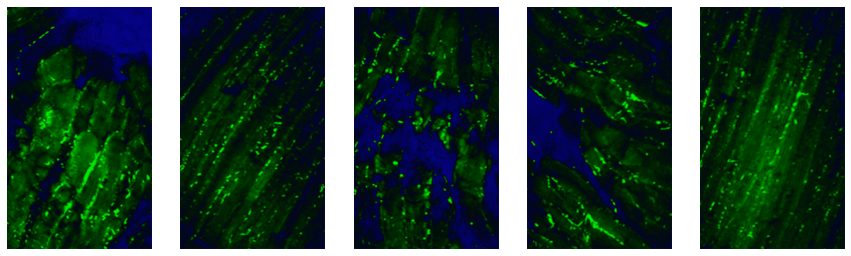

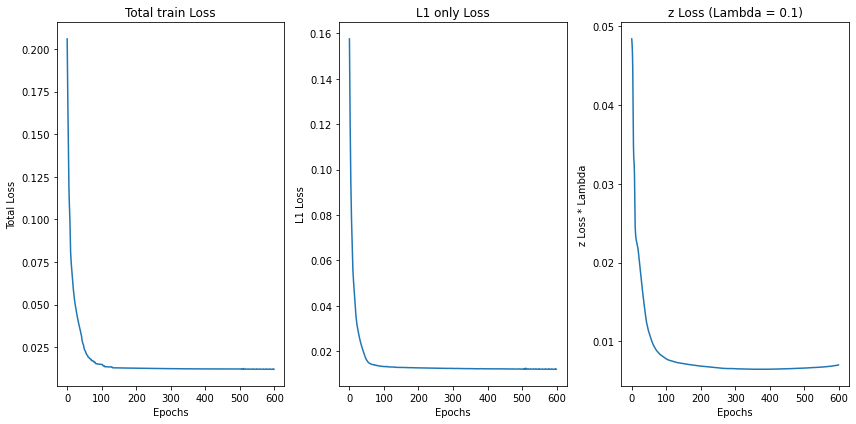

 60%|████████████████████████                | 601/1000 [03:14<02:48,  2.36it/s]

Epoch: 601 	Training Loss Total: 0.012082 	L1 only: 0.012082 	Z Loss*Lambda: 0.007022


 60%|████████████████████████                | 602/1000 [03:15<02:35,  2.56it/s]

Epoch: 602 	Training Loss Total: 0.012081 	L1 only: 0.012081 	Z Loss*Lambda: 0.007027


 60%|████████████████████████                | 603/1000 [03:15<02:26,  2.72it/s]

Epoch: 603 	Training Loss Total: 0.012080 	L1 only: 0.012080 	Z Loss*Lambda: 0.007036


 60%|████████████████████████▏               | 604/1000 [03:15<02:19,  2.84it/s]

Epoch: 604 	Training Loss Total: 0.012088 	L1 only: 0.012088 	Z Loss*Lambda: 0.007045


 60%|████████████████████████▏               | 605/1000 [03:16<02:14,  2.93it/s]

Epoch: 605 	Training Loss Total: 0.012102 	L1 only: 0.012102 	Z Loss*Lambda: 0.007054


 61%|████████████████████████▏               | 606/1000 [03:16<02:11,  2.99it/s]

Epoch: 606 	Training Loss Total: 0.012130 	L1 only: 0.012130 	Z Loss*Lambda: 0.007063


 61%|████████████████████████▎               | 607/1000 [03:16<02:09,  3.04it/s]

Epoch: 607 	Training Loss Total: 0.012191 	L1 only: 0.012191 	Z Loss*Lambda: 0.007071


 61%|████████████████████████▎               | 608/1000 [03:17<02:07,  3.07it/s]

Epoch: 608 	Training Loss Total: 0.012300 	L1 only: 0.012300 	Z Loss*Lambda: 0.007080


 61%|████████████████████████▎               | 609/1000 [03:17<02:06,  3.09it/s]

Epoch: 609 	Training Loss Total: 0.012120 	L1 only: 0.012120 	Z Loss*Lambda: 0.007099


 61%|████████████████████████▍               | 610/1000 [03:17<02:05,  3.11it/s]

Epoch: 610 	Training Loss Total: 0.012081 	L1 only: 0.012081 	Z Loss*Lambda: 0.007119


 61%|████████████████████████▍               | 611/1000 [03:17<02:04,  3.12it/s]

Epoch: 611 	Training Loss Total: 0.012075 	L1 only: 0.012075 	Z Loss*Lambda: 0.007127


 61%|████████████████████████▍               | 612/1000 [03:18<02:04,  3.13it/s]

Epoch: 612 	Training Loss Total: 0.012081 	L1 only: 0.012081 	Z Loss*Lambda: 0.007137


 61%|████████████████████████▌               | 613/1000 [03:18<02:03,  3.13it/s]

Epoch: 613 	Training Loss Total: 0.012083 	L1 only: 0.012083 	Z Loss*Lambda: 0.007149


 61%|████████████████████████▌               | 614/1000 [03:18<02:03,  3.13it/s]

Epoch: 614 	Training Loss Total: 0.012101 	L1 only: 0.012101 	Z Loss*Lambda: 0.007160


 62%|████████████████████████▌               | 615/1000 [03:19<02:02,  3.14it/s]

Epoch: 615 	Training Loss Total: 0.012125 	L1 only: 0.012125 	Z Loss*Lambda: 0.007171


 62%|████████████████████████▋               | 616/1000 [03:19<02:02,  3.14it/s]

Epoch: 616 	Training Loss Total: 0.012161 	L1 only: 0.012161 	Z Loss*Lambda: 0.007183


 62%|████████████████████████▋               | 617/1000 [03:19<02:02,  3.14it/s]

Epoch: 617 	Training Loss Total: 0.012221 	L1 only: 0.012221 	Z Loss*Lambda: 0.007196


 62%|████████████████████████▋               | 618/1000 [03:20<02:01,  3.14it/s]

Epoch: 618 	Training Loss Total: 0.012199 	L1 only: 0.012199 	Z Loss*Lambda: 0.007211


 62%|████████████████████████▊               | 619/1000 [03:20<02:01,  3.14it/s]

Epoch: 619 	Training Loss Total: 0.012100 	L1 only: 0.012100 	Z Loss*Lambda: 0.007233


 62%|████████████████████████▊               | 620/1000 [03:20<02:01,  3.14it/s]

Epoch: 620 	Training Loss Total: 0.012066 	L1 only: 0.012066 	Z Loss*Lambda: 0.007254


 62%|████████████████████████▊               | 621/1000 [03:21<02:00,  3.14it/s]

Epoch: 621 	Training Loss Total: 0.012059 	L1 only: 0.012059 	Z Loss*Lambda: 0.007267


 62%|████████████████████████▉               | 622/1000 [03:21<02:00,  3.14it/s]

Epoch: 622 	Training Loss Total: 0.012060 	L1 only: 0.012060 	Z Loss*Lambda: 0.007282


 62%|████████████████████████▉               | 623/1000 [03:21<02:00,  3.14it/s]

Epoch: 623 	Training Loss Total: 0.012475 	L1 only: 0.012075 	Z Loss*Lambda: 0.007270


 62%|████████████████████████▉               | 624/1000 [03:22<01:59,  3.14it/s]

Epoch: 624 	Training Loss Total: 0.012096 	L1 only: 0.012096 	Z Loss*Lambda: 0.007247


 62%|█████████████████████████               | 625/1000 [03:22<01:59,  3.14it/s]

Epoch: 625 	Training Loss Total: 0.012095 	L1 only: 0.012095 	Z Loss*Lambda: 0.007261


 63%|█████████████████████████               | 626/1000 [03:22<01:59,  3.14it/s]

Epoch: 626 	Training Loss Total: 0.012130 	L1 only: 0.012130 	Z Loss*Lambda: 0.007279


 63%|█████████████████████████               | 627/1000 [03:23<01:58,  3.14it/s]

Epoch: 627 	Training Loss Total: 0.012213 	L1 only: 0.012213 	Z Loss*Lambda: 0.007296


 63%|█████████████████████████               | 628/1000 [03:23<01:58,  3.14it/s]

Epoch: 628 	Training Loss Total: 0.012219 	L1 only: 0.012219 	Z Loss*Lambda: 0.007319


 63%|█████████████████████████▏              | 629/1000 [03:23<01:58,  3.14it/s]

Epoch: 629 	Training Loss Total: 0.012501 	L1 only: 0.012099 	Z Loss*Lambda: 0.007318


 63%|█████████████████████████▏              | 630/1000 [03:24<01:57,  3.14it/s]

Epoch: 630 	Training Loss Total: 0.012058 	L1 only: 0.012058 	Z Loss*Lambda: 0.007312


 63%|█████████████████████████▏              | 631/1000 [03:24<01:57,  3.14it/s]

Epoch: 631 	Training Loss Total: 0.012052 	L1 only: 0.012052 	Z Loss*Lambda: 0.007325


 63%|█████████████████████████▎              | 632/1000 [03:24<01:57,  3.14it/s]

Epoch: 632 	Training Loss Total: 0.012064 	L1 only: 0.012064 	Z Loss*Lambda: 0.007350


 63%|█████████████████████████▎              | 633/1000 [03:24<01:56,  3.14it/s]

Epoch: 633 	Training Loss Total: 0.012070 	L1 only: 0.012070 	Z Loss*Lambda: 0.007374


 63%|█████████████████████████▎              | 634/1000 [03:25<01:56,  3.14it/s]

Epoch: 634 	Training Loss Total: 0.012487 	L1 only: 0.012087 	Z Loss*Lambda: 0.007369


 64%|█████████████████████████▍              | 635/1000 [03:25<01:56,  3.14it/s]

Epoch: 635 	Training Loss Total: 0.012168 	L1 only: 0.012168 	Z Loss*Lambda: 0.007355


 64%|█████████████████████████▍              | 636/1000 [03:25<01:55,  3.14it/s]

Epoch: 636 	Training Loss Total: 0.012230 	L1 only: 0.012230 	Z Loss*Lambda: 0.007377


 64%|█████████████████████████▍              | 637/1000 [03:26<01:55,  3.14it/s]

Epoch: 637 	Training Loss Total: 0.012505 	L1 only: 0.012104 	Z Loss*Lambda: 0.007381


 64%|█████████████████████████▌              | 638/1000 [03:26<01:55,  3.14it/s]

Epoch: 638 	Training Loss Total: 0.012056 	L1 only: 0.012056 	Z Loss*Lambda: 0.007384


 64%|█████████████████████████▌              | 639/1000 [03:26<01:54,  3.14it/s]

Epoch: 639 	Training Loss Total: 0.012052 	L1 only: 0.012052 	Z Loss*Lambda: 0.007402


 64%|█████████████████████████▌              | 640/1000 [03:27<01:54,  3.14it/s]

Epoch: 640 	Training Loss Total: 0.012075 	L1 only: 0.012075 	Z Loss*Lambda: 0.007430


 64%|█████████████████████████▋              | 641/1000 [03:27<01:54,  3.14it/s]

Epoch: 641 	Training Loss Total: 0.012078 	L1 only: 0.012078 	Z Loss*Lambda: 0.007460


 64%|█████████████████████████▋              | 642/1000 [03:27<01:53,  3.14it/s]

Epoch: 642 	Training Loss Total: 0.012122 	L1 only: 0.012122 	Z Loss*Lambda: 0.007486


 64%|█████████████████████████▋              | 643/1000 [03:28<01:53,  3.14it/s]

Epoch: 643 	Training Loss Total: 0.012546 	L1 only: 0.012145 	Z Loss*Lambda: 0.007484


 64%|█████████████████████████▊              | 644/1000 [03:28<01:53,  3.14it/s]

Epoch: 644 	Training Loss Total: 0.012117 	L1 only: 0.012117 	Z Loss*Lambda: 0.007483


 64%|█████████████████████████▊              | 645/1000 [03:28<01:53,  3.14it/s]

Epoch: 645 	Training Loss Total: 0.012487 	L1 only: 0.012086 	Z Loss*Lambda: 0.007483


 65%|█████████████████████████▊              | 646/1000 [03:29<01:52,  3.14it/s]

Epoch: 646 	Training Loss Total: 0.012065 	L1 only: 0.012065 	Z Loss*Lambda: 0.007486


 65%|█████████████████████████▉              | 647/1000 [03:29<01:52,  3.14it/s]

Epoch: 647 	Training Loss Total: 0.012041 	L1 only: 0.012041 	Z Loss*Lambda: 0.007518


 65%|█████████████████████████▉              | 648/1000 [03:29<01:52,  3.14it/s]

Epoch: 648 	Training Loss Total: 0.012037 	L1 only: 0.012037 	Z Loss*Lambda: 0.007556


 65%|█████████████████████████▉              | 649/1000 [03:30<01:51,  3.14it/s]

Epoch: 649 	Training Loss Total: 0.012464 	L1 only: 0.012063 	Z Loss*Lambda: 0.007560
Epoch: 650 	Training Loss Total: 0.012114 	L1 only: 0.012114 	Z Loss*Lambda: 0.007558


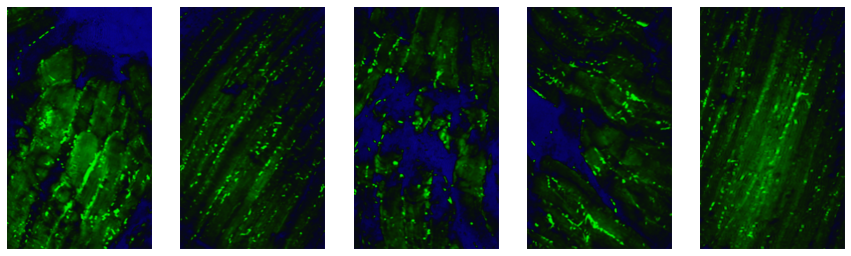

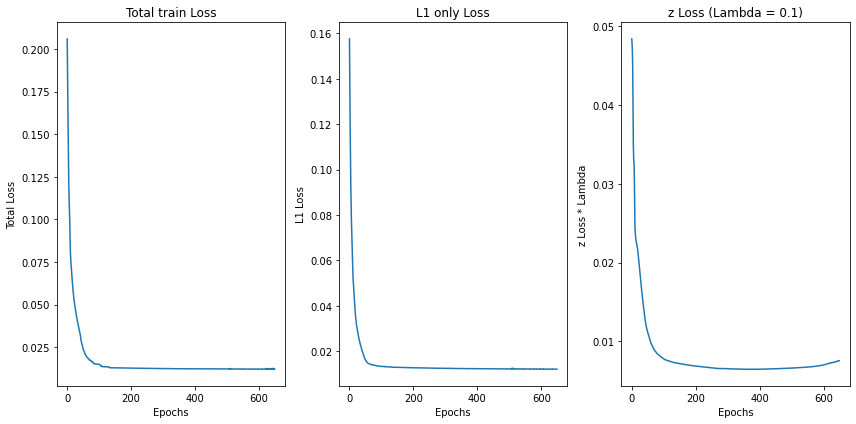

 65%|██████████████████████████              | 651/1000 [03:31<02:32,  2.29it/s]

Epoch: 651 	Training Loss Total: 0.012517 	L1 only: 0.012116 	Z Loss*Lambda: 0.007566


 65%|██████████████████████████              | 652/1000 [03:31<02:19,  2.50it/s]

Epoch: 652 	Training Loss Total: 0.012066 	L1 only: 0.012066 	Z Loss*Lambda: 0.007576


 65%|██████████████████████████              | 653/1000 [03:31<02:10,  2.67it/s]

Epoch: 653 	Training Loss Total: 0.012022 	L1 only: 0.012022 	Z Loss*Lambda: 0.007613


 65%|██████████████████████████▏             | 654/1000 [03:32<02:03,  2.79it/s]

Epoch: 654 	Training Loss Total: 0.012428 	L1 only: 0.012027 	Z Loss*Lambda: 0.007627


 66%|██████████████████████████▏             | 655/1000 [03:32<01:59,  2.89it/s]

Epoch: 655 	Training Loss Total: 0.012100 	L1 only: 0.012100 	Z Loss*Lambda: 0.007631


 66%|██████████████████████████▏             | 656/1000 [03:32<01:55,  2.97it/s]

Epoch: 656 	Training Loss Total: 0.012169 	L1 only: 0.012169 	Z Loss*Lambda: 0.007672


 66%|██████████████████████████▎             | 657/1000 [03:33<01:53,  3.02it/s]

Epoch: 657 	Training Loss Total: 0.012430 	L1 only: 0.012024 	Z Loss*Lambda: 0.007702


 66%|██████████████████████████▎             | 658/1000 [03:33<01:51,  3.06it/s]

Epoch: 658 	Training Loss Total: 0.011993 	L1 only: 0.011993 	Z Loss*Lambda: 0.007713


 66%|██████████████████████████▎             | 659/1000 [03:33<01:50,  3.09it/s]

Epoch: 659 	Training Loss Total: 0.012402 	L1 only: 0.012000 	Z Loss*Lambda: 0.007726


 66%|██████████████████████████▍             | 660/1000 [03:34<01:49,  3.11it/s]

Epoch: 660 	Training Loss Total: 0.012004 	L1 only: 0.012004 	Z Loss*Lambda: 0.007746


 66%|██████████████████████████▍             | 661/1000 [03:34<01:48,  3.12it/s]

Epoch: 661 	Training Loss Total: 0.012523 	L1 only: 0.012121 	Z Loss*Lambda: 0.007767


 66%|██████████████████████████▍             | 662/1000 [03:34<01:48,  3.13it/s]

Epoch: 662 	Training Loss Total: 0.011981 	L1 only: 0.011981 	Z Loss*Lambda: 0.007791


 66%|██████████████████████████▌             | 663/1000 [03:35<01:47,  3.14it/s]

Epoch: 663 	Training Loss Total: 0.012374 	L1 only: 0.011974 	Z Loss*Lambda: 0.007826


 66%|██████████████████████████▌             | 664/1000 [03:35<01:46,  3.15it/s]

Epoch: 664 	Training Loss Total: 0.012369 	L1 only: 0.011969 	Z Loss*Lambda: 0.007820


 66%|██████████████████████████▌             | 665/1000 [03:35<01:46,  3.15it/s]

Epoch: 665 	Training Loss Total: 0.011998 	L1 only: 0.011998 	Z Loss*Lambda: 0.007843


 67%|██████████████████████████▋             | 666/1000 [03:36<01:46,  3.15it/s]

Epoch: 666 	Training Loss Total: 0.012577 	L1 only: 0.012176 	Z Loss*Lambda: 0.007879


 67%|██████████████████████████▋             | 667/1000 [03:36<01:45,  3.15it/s]

Epoch: 667 	Training Loss Total: 0.012088 	L1 only: 0.012088 	Z Loss*Lambda: 0.007909


 67%|██████████████████████████▋             | 668/1000 [03:36<01:45,  3.15it/s]

Epoch: 668 	Training Loss Total: 0.012414 	L1 only: 0.012009 	Z Loss*Lambda: 0.007961


 67%|██████████████████████████▊             | 669/1000 [03:36<01:45,  3.15it/s]

Epoch: 669 	Training Loss Total: 0.011929 	L1 only: 0.011929 	Z Loss*Lambda: 0.007993


 67%|██████████████████████████▊             | 670/1000 [03:37<01:44,  3.15it/s]

Epoch: 670 	Training Loss Total: 0.012349 	L1 only: 0.011948 	Z Loss*Lambda: 0.008026


 67%|██████████████████████████▊             | 671/1000 [03:37<01:44,  3.15it/s]

Epoch: 671 	Training Loss Total: 0.012000 	L1 only: 0.012000 	Z Loss*Lambda: 0.008065


 67%|██████████████████████████▉             | 672/1000 [03:37<01:44,  3.15it/s]

Epoch: 672 	Training Loss Total: 0.012465 	L1 only: 0.012062 	Z Loss*Lambda: 0.008112


 67%|██████████████████████████▉             | 673/1000 [03:38<01:43,  3.15it/s]

Epoch: 673 	Training Loss Total: 0.012313 	L1 only: 0.011907 	Z Loss*Lambda: 0.008125


 67%|██████████████████████████▉             | 674/1000 [03:38<01:43,  3.15it/s]

Epoch: 674 	Training Loss Total: 0.012293 	L1 only: 0.011890 	Z Loss*Lambda: 0.008126


 68%|███████████████████████████             | 675/1000 [03:38<01:43,  3.15it/s]

Epoch: 675 	Training Loss Total: 0.012304 	L1 only: 0.011902 	Z Loss*Lambda: 0.008138


 68%|███████████████████████████             | 676/1000 [03:39<01:42,  3.15it/s]

Epoch: 676 	Training Loss Total: 0.012324 	L1 only: 0.011924 	Z Loss*Lambda: 0.008157


 68%|███████████████████████████             | 677/1000 [03:39<01:42,  3.15it/s]

Epoch: 677 	Training Loss Total: 0.011863 	L1 only: 0.011863 	Z Loss*Lambda: 0.008208


 68%|███████████████████████████             | 678/1000 [03:39<01:42,  3.15it/s]

Epoch: 678 	Training Loss Total: 0.012248 	L1 only: 0.011846 	Z Loss*Lambda: 0.008268


 68%|███████████████████████████▏            | 679/1000 [03:40<01:41,  3.15it/s]

Epoch: 679 	Training Loss Total: 0.012272 	L1 only: 0.011870 	Z Loss*Lambda: 0.008288


 68%|███████████████████████████▏            | 680/1000 [03:40<01:41,  3.15it/s]

Epoch: 680 	Training Loss Total: 0.012271 	L1 only: 0.011870 	Z Loss*Lambda: 0.008304


 68%|███████████████████████████▏            | 681/1000 [03:40<01:41,  3.15it/s]

Epoch: 681 	Training Loss Total: 0.011792 	L1 only: 0.011792 	Z Loss*Lambda: 0.008363


 68%|███████████████████████████▎            | 682/1000 [03:41<01:40,  3.15it/s]

Epoch: 682 	Training Loss Total: 0.012197 	L1 only: 0.011794 	Z Loss*Lambda: 0.008428


 68%|███████████████████████████▎            | 683/1000 [03:41<01:40,  3.15it/s]

Epoch: 683 	Training Loss Total: 0.012189 	L1 only: 0.011786 	Z Loss*Lambda: 0.008451


 68%|███████████████████████████▎            | 684/1000 [03:41<01:40,  3.15it/s]

Epoch: 684 	Training Loss Total: 0.012189 	L1 only: 0.011787 	Z Loss*Lambda: 0.008476


 68%|███████████████████████████▍            | 685/1000 [03:42<01:40,  3.15it/s]

Epoch: 685 	Training Loss Total: 0.012098 	L1 only: 0.011697 	Z Loss*Lambda: 0.008492


 69%|███████████████████████████▍            | 686/1000 [03:42<01:39,  3.15it/s]

Epoch: 686 	Training Loss Total: 0.012165 	L1 only: 0.011755 	Z Loss*Lambda: 0.008566


 69%|███████████████████████████▍            | 687/1000 [03:42<01:39,  3.15it/s]

Epoch: 687 	Training Loss Total: 0.012535 	L1 only: 0.011719 	Z Loss*Lambda: 0.008598


 69%|███████████████████████████▌            | 688/1000 [03:43<01:39,  3.15it/s]

Epoch: 688 	Training Loss Total: 0.012456 	L1 only: 0.011644 	Z Loss*Lambda: 0.008594


 69%|███████████████████████████▌            | 689/1000 [03:43<01:38,  3.15it/s]

Epoch: 689 	Training Loss Total: 0.012014 	L1 only: 0.011604 	Z Loss*Lambda: 0.008638


 69%|███████████████████████████▌            | 690/1000 [03:43<01:38,  3.15it/s]

Epoch: 690 	Training Loss Total: 0.012362 	L1 only: 0.011546 	Z Loss*Lambda: 0.008679


 69%|███████████████████████████▋            | 691/1000 [03:43<01:38,  3.15it/s]

Epoch: 691 	Training Loss Total: 0.012348 	L1 only: 0.011534 	Z Loss*Lambda: 0.008697


 69%|███████████████████████████▋            | 692/1000 [03:44<01:37,  3.15it/s]

Epoch: 692 	Training Loss Total: 0.011852 	L1 only: 0.011438 	Z Loss*Lambda: 0.008749


 69%|███████████████████████████▋            | 693/1000 [03:44<01:37,  3.15it/s]

Epoch: 693 	Training Loss Total: 0.012209 	L1 only: 0.011390 	Z Loss*Lambda: 0.008801


 69%|███████████████████████████▊            | 694/1000 [03:44<01:37,  3.15it/s]

Epoch: 694 	Training Loss Total: 0.012256 	L1 only: 0.011437 	Z Loss*Lambda: 0.008822


 70%|███████████████████████████▊            | 695/1000 [03:45<01:36,  3.15it/s]

Epoch: 695 	Training Loss Total: 0.012639 	L1 only: 0.011415 	Z Loss*Lambda: 0.008822


 70%|███████████████████████████▊            | 696/1000 [03:45<01:36,  3.15it/s]

Epoch: 696 	Training Loss Total: 0.012016 	L1 only: 0.011196 	Z Loss*Lambda: 0.008844


 70%|███████████████████████████▉            | 697/1000 [03:45<01:36,  3.15it/s]

Epoch: 697 	Training Loss Total: 0.011543 	L1 only: 0.011126 	Z Loss*Lambda: 0.008938


 70%|███████████████████████████▉            | 698/1000 [03:46<01:35,  3.15it/s]

Epoch: 698 	Training Loss Total: 0.012546 	L1 only: 0.011307 	Z Loss*Lambda: 0.008970


 70%|███████████████████████████▉            | 699/1000 [03:46<01:35,  3.15it/s]

Epoch: 699 	Training Loss Total: 0.012226 	L1 only: 0.010996 	Z Loss*Lambda: 0.008964
Epoch: 700 	Training Loss Total: 0.011603 	L1 only: 0.010778 	Z Loss*Lambda: 0.009000


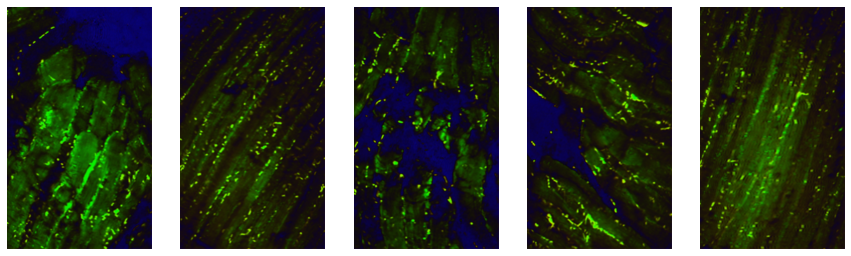

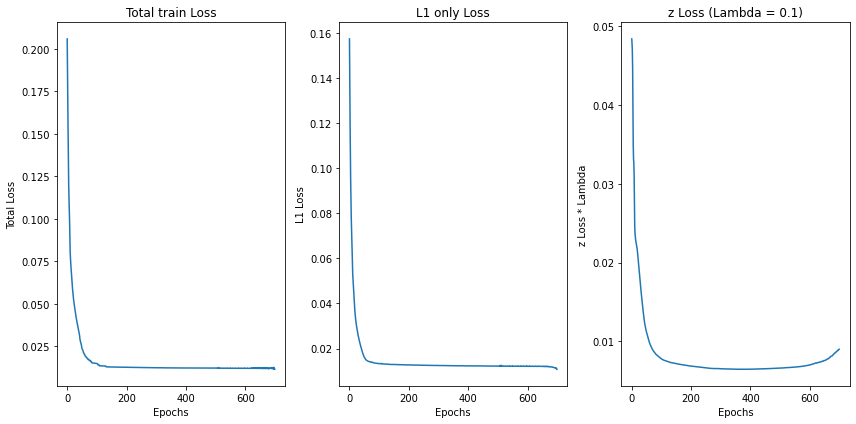

 70%|████████████████████████████            | 701/1000 [03:47<02:05,  2.37it/s]

Epoch: 701 	Training Loss Total: 0.012146 	L1 only: 0.010893 	Z Loss*Lambda: 0.009042


 70%|████████████████████████████            | 702/1000 [03:47<01:55,  2.57it/s]

Epoch: 702 	Training Loss Total: 0.012273 	L1 only: 0.010616 	Z Loss*Lambda: 0.009052


 70%|████████████████████████████            | 703/1000 [03:48<01:49,  2.72it/s]

Epoch: 703 	Training Loss Total: 0.012113 	L1 only: 0.010461 	Z Loss*Lambda: 0.009034


 70%|████████████████████████████▏           | 704/1000 [03:48<01:44,  2.84it/s]

Epoch: 704 	Training Loss Total: 0.011986 	L1 only: 0.010325 	Z Loss*Lambda: 0.009044


 70%|████████████████████████████▏           | 705/1000 [03:48<01:40,  2.92it/s]

Epoch: 705 	Training Loss Total: 0.011946 	L1 only: 0.010274 	Z Loss*Lambda: 0.009070


 71%|████████████████████████████▏           | 706/1000 [03:49<01:38,  2.98it/s]

Epoch: 706 	Training Loss Total: 0.011784 	L1 only: 0.010103 	Z Loss*Lambda: 0.009090


 71%|████████████████████████████▎           | 707/1000 [03:49<01:36,  3.03it/s]

Epoch: 707 	Training Loss Total: 0.011703 	L1 only: 0.010010 	Z Loss*Lambda: 0.009110


 71%|████████████████████████████▎           | 708/1000 [03:49<01:35,  3.06it/s]

Epoch: 708 	Training Loss Total: 0.011567 	L1 only: 0.009867 	Z Loss*Lambda: 0.009128


 71%|████████████████████████████▎           | 709/1000 [03:50<01:34,  3.09it/s]

Epoch: 709 	Training Loss Total: 0.011464 	L1 only: 0.009753 	Z Loss*Lambda: 0.009149


 71%|████████████████████████████▍           | 710/1000 [03:50<01:33,  3.10it/s]

Epoch: 710 	Training Loss Total: 0.011269 	L1 only: 0.009549 	Z Loss*Lambda: 0.009176


 71%|████████████████████████████▍           | 711/1000 [03:50<01:32,  3.11it/s]

Epoch: 711 	Training Loss Total: 0.011657 	L1 only: 0.009524 	Z Loss*Lambda: 0.009185


 71%|████████████████████████████▍           | 712/1000 [03:51<01:32,  3.12it/s]

Epoch: 712 	Training Loss Total: 0.011652 	L1 only: 0.009127 	Z Loss*Lambda: 0.009173


 71%|████████████████████████████▌           | 713/1000 [03:51<01:31,  3.13it/s]

Epoch: 713 	Training Loss Total: 0.011760 	L1 only: 0.009247 	Z Loss*Lambda: 0.009123


 71%|████████████████████████████▌           | 714/1000 [03:51<01:31,  3.13it/s]

Epoch: 714 	Training Loss Total: 0.011386 	L1 only: 0.008869 	Z Loss*Lambda: 0.009089


 72%|████████████████████████████▌           | 715/1000 [03:52<01:30,  3.13it/s]

Epoch: 715 	Training Loss Total: 0.011337 	L1 only: 0.008834 	Z Loss*Lambda: 0.009051


 72%|████████████████████████████▋           | 716/1000 [03:52<01:30,  3.14it/s]

Epoch: 716 	Training Loss Total: 0.011571 	L1 only: 0.009080 	Z Loss*Lambda: 0.009008


 72%|████████████████████████████▋           | 717/1000 [03:52<01:30,  3.14it/s]

Epoch: 717 	Training Loss Total: 0.010947 	L1 only: 0.008845 	Z Loss*Lambda: 0.008972


 72%|████████████████████████████▋           | 718/1000 [03:53<01:29,  3.14it/s]

Epoch: 718 	Training Loss Total: 0.011019 	L1 only: 0.008533 	Z Loss*Lambda: 0.008967


 72%|████████████████████████████▊           | 719/1000 [03:53<01:29,  3.14it/s]

Epoch: 719 	Training Loss Total: 0.011084 	L1 only: 0.008605 	Z Loss*Lambda: 0.008935


 72%|████████████████████████████▊           | 720/1000 [03:53<01:29,  3.14it/s]

Epoch: 720 	Training Loss Total: 0.011016 	L1 only: 0.008546 	Z Loss*Lambda: 0.008906


 72%|████████████████████████████▊           | 721/1000 [03:53<01:28,  3.14it/s]

Epoch: 721 	Training Loss Total: 0.010369 	L1 only: 0.008293 	Z Loss*Lambda: 0.008906


 72%|████████████████████████████▉           | 722/1000 [03:54<01:28,  3.14it/s]

Epoch: 722 	Training Loss Total: 0.010258 	L1 only: 0.008565 	Z Loss*Lambda: 0.008901


 72%|████████████████████████████▉           | 723/1000 [03:54<01:28,  3.14it/s]

Epoch: 723 	Training Loss Total: 0.010166 	L1 only: 0.008474 	Z Loss*Lambda: 0.008912


 72%|████████████████████████████▉           | 724/1000 [03:54<01:27,  3.14it/s]

Epoch: 724 	Training Loss Total: 0.010053 	L1 only: 0.008357 	Z Loss*Lambda: 0.008935


 72%|█████████████████████████████           | 725/1000 [03:55<01:27,  3.14it/s]

Epoch: 725 	Training Loss Total: 0.010047 	L1 only: 0.008350 	Z Loss*Lambda: 0.008936


 73%|█████████████████████████████           | 726/1000 [03:55<01:27,  3.14it/s]

Epoch: 726 	Training Loss Total: 0.010274 	L1 only: 0.008184 	Z Loss*Lambda: 0.008936


 73%|█████████████████████████████           | 727/1000 [03:55<01:26,  3.14it/s]

Epoch: 727 	Training Loss Total: 0.009885 	L1 only: 0.008195 	Z Loss*Lambda: 0.008914


 73%|█████████████████████████████           | 728/1000 [03:56<01:26,  3.14it/s]

Epoch: 728 	Training Loss Total: 0.009840 	L1 only: 0.008151 	Z Loss*Lambda: 0.008914


 73%|█████████████████████████████▏          | 729/1000 [03:56<01:26,  3.14it/s]

Epoch: 729 	Training Loss Total: 0.009784 	L1 only: 0.008096 	Z Loss*Lambda: 0.008913


 73%|█████████████████████████████▏          | 730/1000 [03:56<01:25,  3.14it/s]

Epoch: 730 	Training Loss Total: 0.010094 	L1 only: 0.008013 	Z Loss*Lambda: 0.008902


 73%|█████████████████████████████▏          | 731/1000 [03:57<01:25,  3.14it/s]

Epoch: 731 	Training Loss Total: 0.009583 	L1 only: 0.007907 	Z Loss*Lambda: 0.008880


 73%|█████████████████████████████▎          | 732/1000 [03:57<01:25,  3.14it/s]

Epoch: 732 	Training Loss Total: 0.009660 	L1 only: 0.007981 	Z Loss*Lambda: 0.008866


 73%|█████████████████████████████▎          | 733/1000 [03:57<01:25,  3.14it/s]

Epoch: 733 	Training Loss Total: 0.009563 	L1 only: 0.007888 	Z Loss*Lambda: 0.008864


 73%|█████████████████████████████▎          | 734/1000 [03:58<01:24,  3.14it/s]

Epoch: 734 	Training Loss Total: 0.009587 	L1 only: 0.007913 	Z Loss*Lambda: 0.008848


 74%|█████████████████████████████▍          | 735/1000 [03:58<01:24,  3.14it/s]

Epoch: 735 	Training Loss Total: 0.009521 	L1 only: 0.007851 	Z Loss*Lambda: 0.008838


 74%|█████████████████████████████▍          | 736/1000 [03:58<01:24,  3.14it/s]

Epoch: 736 	Training Loss Total: 0.009547 	L1 only: 0.007879 	Z Loss*Lambda: 0.008818


 74%|█████████████████████████████▍          | 737/1000 [03:59<01:23,  3.14it/s]

Epoch: 737 	Training Loss Total: 0.009481 	L1 only: 0.007817 	Z Loss*Lambda: 0.008804


 74%|█████████████████████████████▌          | 738/1000 [03:59<01:23,  3.14it/s]

Epoch: 738 	Training Loss Total: 0.009483 	L1 only: 0.007821 	Z Loss*Lambda: 0.008787


 74%|█████████████████████████████▌          | 739/1000 [03:59<01:23,  3.14it/s]

Epoch: 739 	Training Loss Total: 0.009444 	L1 only: 0.007787 	Z Loss*Lambda: 0.008773


 74%|█████████████████████████████▌          | 740/1000 [04:00<01:22,  3.14it/s]

Epoch: 740 	Training Loss Total: 0.009038 	L1 only: 0.007781 	Z Loss*Lambda: 0.008764


 74%|█████████████████████████████▋          | 741/1000 [04:00<01:22,  3.14it/s]

Epoch: 741 	Training Loss Total: 0.009443 	L1 only: 0.007786 	Z Loss*Lambda: 0.008765


 74%|█████████████████████████████▋          | 742/1000 [04:00<01:22,  3.14it/s]

Epoch: 742 	Training Loss Total: 0.008931 	L1 only: 0.007679 	Z Loss*Lambda: 0.008755


 74%|█████████████████████████████▋          | 743/1000 [04:00<01:21,  3.14it/s]

Epoch: 743 	Training Loss Total: 0.009417 	L1 only: 0.007763 	Z Loss*Lambda: 0.008754


 74%|█████████████████████████████▊          | 744/1000 [04:01<01:21,  3.14it/s]

Epoch: 744 	Training Loss Total: 0.008892 	L1 only: 0.007644 	Z Loss*Lambda: 0.008737


 74%|█████████████████████████████▊          | 745/1000 [04:01<01:21,  3.14it/s]

Epoch: 745 	Training Loss Total: 0.008982 	L1 only: 0.007728 	Z Loss*Lambda: 0.008747


 75%|█████████████████████████████▊          | 746/1000 [04:01<01:20,  3.14it/s]

Epoch: 746 	Training Loss Total: 0.008926 	L1 only: 0.007674 	Z Loss*Lambda: 0.008747


 75%|█████████████████████████████▉          | 747/1000 [04:02<01:20,  3.14it/s]

Epoch: 747 	Training Loss Total: 0.008932 	L1 only: 0.007680 	Z Loss*Lambda: 0.008752


 75%|█████████████████████████████▉          | 748/1000 [04:02<01:20,  3.14it/s]

Epoch: 748 	Training Loss Total: 0.008890 	L1 only: 0.007639 	Z Loss*Lambda: 0.008752


 75%|█████████████████████████████▉          | 749/1000 [04:02<01:19,  3.14it/s]

Epoch: 749 	Training Loss Total: 0.008914 	L1 only: 0.007662 	Z Loss*Lambda: 0.008757
Epoch: 750 	Training Loss Total: 0.008916 	L1 only: 0.007663 	Z Loss*Lambda: 0.008759


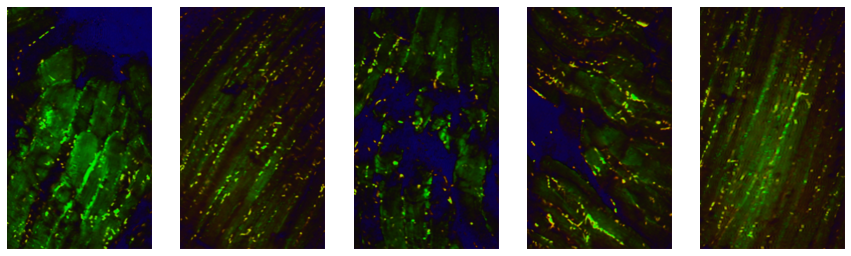

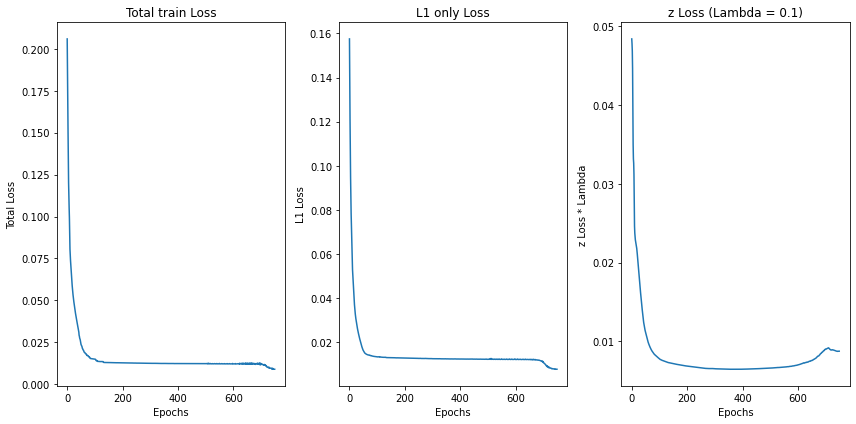

 75%|██████████████████████████████          | 751/1000 [04:04<01:45,  2.36it/s]

Epoch: 751 	Training Loss Total: 0.008901 	L1 only: 0.007648 	Z Loss*Lambda: 0.008770


 75%|██████████████████████████████          | 752/1000 [04:04<01:36,  2.56it/s]

Epoch: 752 	Training Loss Total: 0.008846 	L1 only: 0.007595 	Z Loss*Lambda: 0.008786


 75%|██████████████████████████████          | 753/1000 [04:04<01:30,  2.72it/s]

Epoch: 753 	Training Loss Total: 0.008830 	L1 only: 0.007579 	Z Loss*Lambda: 0.008791


 75%|██████████████████████████████▏         | 754/1000 [04:04<01:26,  2.83it/s]

Epoch: 754 	Training Loss Total: 0.008795 	L1 only: 0.007545 	Z Loss*Lambda: 0.008794


 76%|██████████████████████████████▏         | 755/1000 [04:05<01:23,  2.92it/s]

Epoch: 755 	Training Loss Total: 0.008790 	L1 only: 0.007541 	Z Loss*Lambda: 0.008792


 76%|██████████████████████████████▏         | 756/1000 [04:05<01:21,  2.99it/s]

Epoch: 756 	Training Loss Total: 0.008796 	L1 only: 0.007546 	Z Loss*Lambda: 0.008791


 76%|██████████████████████████████▎         | 757/1000 [04:05<01:20,  3.03it/s]

Epoch: 757 	Training Loss Total: 0.008775 	L1 only: 0.007528 	Z Loss*Lambda: 0.008793


 76%|██████████████████████████████▎         | 758/1000 [04:06<01:18,  3.07it/s]

Epoch: 758 	Training Loss Total: 0.008764 	L1 only: 0.007517 	Z Loss*Lambda: 0.008783


 76%|██████████████████████████████▎         | 759/1000 [04:06<01:18,  3.09it/s]

Epoch: 759 	Training Loss Total: 0.008773 	L1 only: 0.007527 	Z Loss*Lambda: 0.008776


 76%|██████████████████████████████▍         | 760/1000 [04:06<01:17,  3.11it/s]

Epoch: 760 	Training Loss Total: 0.008739 	L1 only: 0.007496 	Z Loss*Lambda: 0.008771


 76%|██████████████████████████████▍         | 761/1000 [04:07<01:16,  3.12it/s]

Epoch: 761 	Training Loss Total: 0.008748 	L1 only: 0.007506 	Z Loss*Lambda: 0.008757


 76%|██████████████████████████████▍         | 762/1000 [04:07<01:16,  3.13it/s]

Epoch: 762 	Training Loss Total: 0.008720 	L1 only: 0.007482 	Z Loss*Lambda: 0.008746


 76%|██████████████████████████████▌         | 763/1000 [04:07<01:15,  3.14it/s]

Epoch: 763 	Training Loss Total: 0.008709 	L1 only: 0.007473 	Z Loss*Lambda: 0.008734


 76%|██████████████████████████████▌         | 764/1000 [04:08<01:15,  3.14it/s]

Epoch: 764 	Training Loss Total: 0.008688 	L1 only: 0.007454 	Z Loss*Lambda: 0.008720


 76%|██████████████████████████████▌         | 765/1000 [04:08<01:14,  3.14it/s]

Epoch: 765 	Training Loss Total: 0.008659 	L1 only: 0.007428 	Z Loss*Lambda: 0.008706


 77%|██████████████████████████████▋         | 766/1000 [04:08<01:14,  3.14it/s]

Epoch: 766 	Training Loss Total: 0.008676 	L1 only: 0.007446 	Z Loss*Lambda: 0.008691


 77%|██████████████████████████████▋         | 767/1000 [04:09<01:14,  3.15it/s]

Epoch: 767 	Training Loss Total: 0.008255 	L1 only: 0.007427 	Z Loss*Lambda: 0.008679


 77%|██████████████████████████████▋         | 768/1000 [04:09<01:13,  3.15it/s]

Epoch: 768 	Training Loss Total: 0.008620 	L1 only: 0.007390 	Z Loss*Lambda: 0.008692


 77%|██████████████████████████████▊         | 769/1000 [04:09<01:13,  3.15it/s]

Epoch: 769 	Training Loss Total: 0.008295 	L1 only: 0.007465 	Z Loss*Lambda: 0.008674


 77%|██████████████████████████████▊         | 770/1000 [04:10<01:12,  3.15it/s]

Epoch: 770 	Training Loss Total: 0.008642 	L1 only: 0.007409 	Z Loss*Lambda: 0.008698


 77%|██████████████████████████████▊         | 771/1000 [04:10<01:12,  3.15it/s]

Epoch: 771 	Training Loss Total: 0.008266 	L1 only: 0.007438 	Z Loss*Lambda: 0.008683


 77%|██████████████████████████████▉         | 772/1000 [04:10<01:12,  3.15it/s]

Epoch: 772 	Training Loss Total: 0.008606 	L1 only: 0.007376 	Z Loss*Lambda: 0.008692


 77%|██████████████████████████████▉         | 773/1000 [04:11<01:12,  3.15it/s]

Epoch: 773 	Training Loss Total: 0.008258 	L1 only: 0.007431 	Z Loss*Lambda: 0.008671


 77%|██████████████████████████████▉         | 774/1000 [04:11<01:11,  3.15it/s]

Epoch: 774 	Training Loss Total: 0.008192 	L1 only: 0.007363 	Z Loss*Lambda: 0.008677


 78%|███████████████████████████████         | 775/1000 [04:11<01:11,  3.15it/s]

Epoch: 775 	Training Loss Total: 0.008210 	L1 only: 0.007379 	Z Loss*Lambda: 0.008683


 78%|███████████████████████████████         | 776/1000 [04:11<01:11,  3.15it/s]

Epoch: 776 	Training Loss Total: 0.008177 	L1 only: 0.007348 	Z Loss*Lambda: 0.008682


 78%|███████████████████████████████         | 777/1000 [04:12<01:10,  3.15it/s]

Epoch: 777 	Training Loss Total: 0.008189 	L1 only: 0.007359 	Z Loss*Lambda: 0.008679


 78%|███████████████████████████████         | 778/1000 [04:12<01:10,  3.14it/s]

Epoch: 778 	Training Loss Total: 0.008182 	L1 only: 0.007353 	Z Loss*Lambda: 0.008672


 78%|███████████████████████████████▏        | 779/1000 [04:12<01:10,  3.14it/s]

Epoch: 779 	Training Loss Total: 0.008151 	L1 only: 0.007324 	Z Loss*Lambda: 0.008662


 78%|███████████████████████████████▏        | 780/1000 [04:13<01:09,  3.14it/s]

Epoch: 780 	Training Loss Total: 0.008158 	L1 only: 0.007330 	Z Loss*Lambda: 0.008653


 78%|███████████████████████████████▏        | 781/1000 [04:13<01:09,  3.14it/s]

Epoch: 781 	Training Loss Total: 0.008152 	L1 only: 0.007326 	Z Loss*Lambda: 0.008643


 78%|███████████████████████████████▎        | 782/1000 [04:13<01:09,  3.15it/s]

Epoch: 782 	Training Loss Total: 0.008138 	L1 only: 0.007313 	Z Loss*Lambda: 0.008630


 78%|███████████████████████████████▎        | 783/1000 [04:14<01:08,  3.15it/s]

Epoch: 783 	Training Loss Total: 0.007774 	L1 only: 0.007346 	Z Loss*Lambda: 0.008652


 78%|███████████████████████████████▎        | 784/1000 [04:14<01:08,  3.15it/s]

Epoch: 784 	Training Loss Total: 0.008092 	L1 only: 0.007268 	Z Loss*Lambda: 0.008637


 78%|███████████████████████████████▍        | 785/1000 [04:14<01:08,  3.15it/s]

Epoch: 785 	Training Loss Total: 0.007771 	L1 only: 0.007343 	Z Loss*Lambda: 0.008650


 79%|███████████████████████████████▍        | 786/1000 [04:15<01:08,  3.15it/s]

Epoch: 786 	Training Loss Total: 0.008076 	L1 only: 0.007254 	Z Loss*Lambda: 0.008634


 79%|███████████████████████████████▍        | 787/1000 [04:15<01:07,  3.14it/s]

Epoch: 787 	Training Loss Total: 0.007772 	L1 only: 0.007344 	Z Loss*Lambda: 0.008642


 79%|███████████████████████████████▌        | 788/1000 [04:15<01:07,  3.15it/s]

Epoch: 788 	Training Loss Total: 0.007721 	L1 only: 0.007295 	Z Loss*Lambda: 0.008660


 79%|███████████████████████████████▌        | 789/1000 [04:16<01:07,  3.15it/s]

Epoch: 789 	Training Loss Total: 0.008073 	L1 only: 0.007249 	Z Loss*Lambda: 0.008638


 79%|███████████████████████████████▌        | 790/1000 [04:16<01:06,  3.15it/s]

Epoch: 790 	Training Loss Total: 0.008111 	L1 only: 0.007288 	Z Loss*Lambda: 0.008607


 79%|███████████████████████████████▋        | 791/1000 [04:16<01:06,  3.15it/s]

Epoch: 791 	Training Loss Total: 0.007744 	L1 only: 0.007319 	Z Loss*Lambda: 0.008618


 79%|███████████████████████████████▋        | 792/1000 [04:17<01:06,  3.15it/s]

Epoch: 792 	Training Loss Total: 0.007686 	L1 only: 0.007263 	Z Loss*Lambda: 0.008638


 79%|███████████████████████████████▋        | 793/1000 [04:17<01:05,  3.15it/s]

Epoch: 793 	Training Loss Total: 0.008074 	L1 only: 0.007253 	Z Loss*Lambda: 0.008614


 79%|███████████████████████████████▊        | 794/1000 [04:17<01:05,  3.15it/s]

Epoch: 794 	Training Loss Total: 0.007717 	L1 only: 0.007292 	Z Loss*Lambda: 0.008619


 80%|███████████████████████████████▊        | 795/1000 [04:18<01:05,  3.15it/s]

Epoch: 795 	Training Loss Total: 0.007662 	L1 only: 0.007240 	Z Loss*Lambda: 0.008636


 80%|███████████████████████████████▊        | 796/1000 [04:18<01:04,  3.15it/s]

Epoch: 796 	Training Loss Total: 0.008042 	L1 only: 0.007222 	Z Loss*Lambda: 0.008612


 80%|███████████████████████████████▉        | 797/1000 [04:18<01:04,  3.15it/s]

Epoch: 797 	Training Loss Total: 0.007709 	L1 only: 0.007285 	Z Loss*Lambda: 0.008613


 80%|███████████████████████████████▉        | 798/1000 [04:18<01:04,  3.14it/s]

Epoch: 798 	Training Loss Total: 0.007673 	L1 only: 0.007250 	Z Loss*Lambda: 0.008630


 80%|███████████████████████████████▉        | 799/1000 [04:19<01:03,  3.15it/s]

Epoch: 799 	Training Loss Total: 0.008069 	L1 only: 0.007248 	Z Loss*Lambda: 0.008604
Epoch: 800 	Training Loss Total: 0.007694 	L1 only: 0.007271 	Z Loss*Lambda: 0.008605


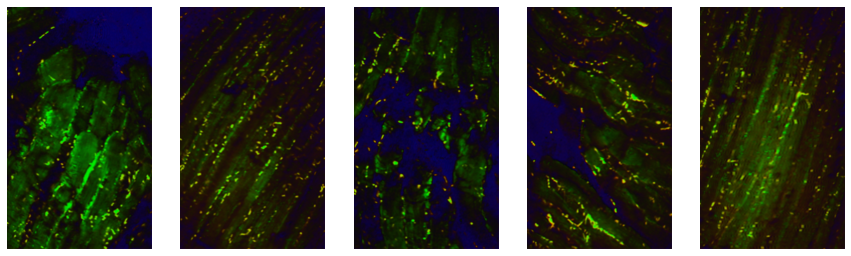

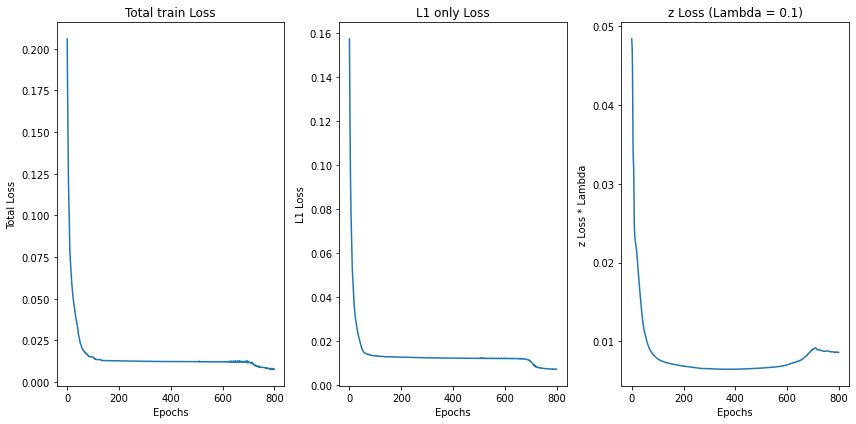

 80%|████████████████████████████████        | 801/1000 [04:20<01:27,  2.27it/s]

Epoch: 801 	Training Loss Total: 0.007652 	L1 only: 0.007232 	Z Loss*Lambda: 0.008620


 80%|████████████████████████████████        | 802/1000 [04:20<01:19,  2.48it/s]

Epoch: 802 	Training Loss Total: 0.007656 	L1 only: 0.007235 	Z Loss*Lambda: 0.008628


 80%|████████████████████████████████        | 803/1000 [04:21<01:14,  2.66it/s]

Epoch: 803 	Training Loss Total: 0.008025 	L1 only: 0.007208 	Z Loss*Lambda: 0.008598


 80%|████████████████████████████████▏       | 804/1000 [04:21<01:10,  2.79it/s]

Epoch: 804 	Training Loss Total: 0.007686 	L1 only: 0.007264 	Z Loss*Lambda: 0.008597


 80%|████████████████████████████████▏       | 805/1000 [04:21<01:07,  2.89it/s]

Epoch: 805 	Training Loss Total: 0.007637 	L1 only: 0.007218 	Z Loss*Lambda: 0.008611


 81%|████████████████████████████████▏       | 806/1000 [04:22<01:05,  2.97it/s]

Epoch: 806 	Training Loss Total: 0.007636 	L1 only: 0.007216 	Z Loss*Lambda: 0.008618


 81%|████████████████████████████████▎       | 807/1000 [04:22<01:03,  3.02it/s]

Epoch: 807 	Training Loss Total: 0.007625 	L1 only: 0.007206 	Z Loss*Lambda: 0.008624


 81%|████████████████████████████████▎       | 808/1000 [04:22<01:02,  3.06it/s]

Epoch: 808 	Training Loss Total: 0.007630 	L1 only: 0.007210 	Z Loss*Lambda: 0.008627


 81%|████████████████████████████████▎       | 809/1000 [04:23<01:01,  3.09it/s]

Epoch: 809 	Training Loss Total: 0.008010 	L1 only: 0.007193 	Z Loss*Lambda: 0.008594


 81%|████████████████████████████████▍       | 810/1000 [04:23<01:01,  3.11it/s]

Epoch: 810 	Training Loss Total: 0.007664 	L1 only: 0.007243 	Z Loss*Lambda: 0.008590


 81%|████████████████████████████████▍       | 811/1000 [04:23<01:00,  3.12it/s]

Epoch: 811 	Training Loss Total: 0.007647 	L1 only: 0.007229 	Z Loss*Lambda: 0.008601


 81%|████████████████████████████████▍       | 812/1000 [04:23<01:00,  3.13it/s]

Epoch: 812 	Training Loss Total: 0.007621 	L1 only: 0.007203 	Z Loss*Lambda: 0.008608


 81%|████████████████████████████████▌       | 813/1000 [04:24<00:59,  3.14it/s]

Epoch: 813 	Training Loss Total: 0.007623 	L1 only: 0.007204 	Z Loss*Lambda: 0.008611


 81%|████████████████████████████████▌       | 814/1000 [04:24<00:59,  3.14it/s]

Epoch: 814 	Training Loss Total: 0.007631 	L1 only: 0.007212 	Z Loss*Lambda: 0.008614


 82%|████████████████████████████████▌       | 815/1000 [04:24<00:58,  3.14it/s]

Epoch: 815 	Training Loss Total: 0.007640 	L1 only: 0.007222 	Z Loss*Lambda: 0.008616


 82%|████████████████████████████████▋       | 816/1000 [04:25<00:58,  3.15it/s]

Epoch: 816 	Training Loss Total: 0.007631 	L1 only: 0.007213 	Z Loss*Lambda: 0.008619


 82%|████████████████████████████████▋       | 817/1000 [04:25<00:58,  3.15it/s]

Epoch: 817 	Training Loss Total: 0.008016 	L1 only: 0.007200 	Z Loss*Lambda: 0.008581


 82%|████████████████████████████████▋       | 818/1000 [04:25<00:57,  3.15it/s]

Epoch: 818 	Training Loss Total: 0.007676 	L1 only: 0.007257 	Z Loss*Lambda: 0.008575


 82%|████████████████████████████████▊       | 819/1000 [04:26<00:57,  3.15it/s]

Epoch: 819 	Training Loss Total: 0.007641 	L1 only: 0.007224 	Z Loss*Lambda: 0.008585


 82%|████████████████████████████████▊       | 820/1000 [04:26<00:57,  3.14it/s]

Epoch: 820 	Training Loss Total: 0.007630 	L1 only: 0.007214 	Z Loss*Lambda: 0.008591


 82%|████████████████████████████████▊       | 821/1000 [04:26<00:56,  3.15it/s]

Epoch: 821 	Training Loss Total: 0.007632 	L1 only: 0.007215 	Z Loss*Lambda: 0.008593


 82%|████████████████████████████████▉       | 822/1000 [04:27<00:56,  3.15it/s]

Epoch: 822 	Training Loss Total: 0.007606 	L1 only: 0.007191 	Z Loss*Lambda: 0.008595


 82%|████████████████████████████████▉       | 823/1000 [04:27<00:56,  3.15it/s]

Epoch: 823 	Training Loss Total: 0.007607 	L1 only: 0.007191 	Z Loss*Lambda: 0.008596


 82%|████████████████████████████████▉       | 824/1000 [04:27<00:55,  3.15it/s]

Epoch: 824 	Training Loss Total: 0.007607 	L1 only: 0.007191 	Z Loss*Lambda: 0.008598


 82%|█████████████████████████████████       | 825/1000 [04:28<00:55,  3.15it/s]

Epoch: 825 	Training Loss Total: 0.007607 	L1 only: 0.007191 	Z Loss*Lambda: 0.008598


 83%|█████████████████████████████████       | 826/1000 [04:28<00:55,  3.15it/s]

Epoch: 826 	Training Loss Total: 0.007597 	L1 only: 0.007182 	Z Loss*Lambda: 0.008598


 83%|█████████████████████████████████       | 827/1000 [04:28<00:54,  3.15it/s]

Epoch: 827 	Training Loss Total: 0.007587 	L1 only: 0.007172 	Z Loss*Lambda: 0.008599


 83%|█████████████████████████████████       | 828/1000 [04:29<00:54,  3.15it/s]

Epoch: 828 	Training Loss Total: 0.007577 	L1 only: 0.007163 	Z Loss*Lambda: 0.008598


 83%|█████████████████████████████████▏      | 829/1000 [04:29<00:54,  3.15it/s]

Epoch: 829 	Training Loss Total: 0.007592 	L1 only: 0.007177 	Z Loss*Lambda: 0.008596


 83%|█████████████████████████████████▏      | 830/1000 [04:29<00:53,  3.15it/s]

Epoch: 830 	Training Loss Total: 0.007979 	L1 only: 0.007166 	Z Loss*Lambda: 0.008572


 83%|█████████████████████████████████▏      | 831/1000 [04:30<00:53,  3.15it/s]

Epoch: 831 	Training Loss Total: 0.007585 	L1 only: 0.007172 	Z Loss*Lambda: 0.008535


 83%|█████████████████████████████████▎      | 832/1000 [04:30<00:53,  3.15it/s]

Epoch: 832 	Training Loss Total: 0.007611 	L1 only: 0.007198 	Z Loss*Lambda: 0.008542


 83%|█████████████████████████████████▎      | 833/1000 [04:30<00:52,  3.15it/s]

Epoch: 833 	Training Loss Total: 0.007598 	L1 only: 0.007186 	Z Loss*Lambda: 0.008550


 83%|█████████████████████████████████▎      | 834/1000 [04:30<00:52,  3.15it/s]

Epoch: 834 	Training Loss Total: 0.007617 	L1 only: 0.007204 	Z Loss*Lambda: 0.008553


 84%|█████████████████████████████████▍      | 835/1000 [04:31<00:52,  3.15it/s]

Epoch: 835 	Training Loss Total: 0.007615 	L1 only: 0.007201 	Z Loss*Lambda: 0.008556


 84%|█████████████████████████████████▍      | 836/1000 [04:31<00:51,  3.15it/s]

Epoch: 836 	Training Loss Total: 0.007611 	L1 only: 0.007198 	Z Loss*Lambda: 0.008557


 84%|█████████████████████████████████▍      | 837/1000 [04:31<00:51,  3.15it/s]

Epoch: 837 	Training Loss Total: 0.007585 	L1 only: 0.007173 	Z Loss*Lambda: 0.008557


 84%|█████████████████████████████████▌      | 838/1000 [04:32<00:51,  3.15it/s]

Epoch: 838 	Training Loss Total: 0.007967 	L1 only: 0.007156 	Z Loss*Lambda: 0.008534


 84%|█████████████████████████████████▌      | 839/1000 [04:32<00:51,  3.15it/s]

Epoch: 839 	Training Loss Total: 0.007584 	L1 only: 0.007173 	Z Loss*Lambda: 0.008496


 84%|█████████████████████████████████▌      | 840/1000 [04:32<00:50,  3.15it/s]

Epoch: 840 	Training Loss Total: 0.007592 	L1 only: 0.007182 	Z Loss*Lambda: 0.008504


 84%|█████████████████████████████████▋      | 841/1000 [04:33<00:50,  3.15it/s]

Epoch: 841 	Training Loss Total: 0.007563 	L1 only: 0.007153 	Z Loss*Lambda: 0.008511


 84%|█████████████████████████████████▋      | 842/1000 [04:33<00:50,  3.15it/s]

Epoch: 842 	Training Loss Total: 0.007580 	L1 only: 0.007169 	Z Loss*Lambda: 0.008514


 84%|█████████████████████████████████▋      | 843/1000 [04:33<00:49,  3.15it/s]

Epoch: 843 	Training Loss Total: 0.007547 	L1 only: 0.007138 	Z Loss*Lambda: 0.008516


 84%|█████████████████████████████████▊      | 844/1000 [04:34<00:49,  3.15it/s]

Epoch: 844 	Training Loss Total: 0.007545 	L1 only: 0.007136 	Z Loss*Lambda: 0.008517


 84%|█████████████████████████████████▊      | 845/1000 [04:34<00:49,  3.15it/s]

Epoch: 845 	Training Loss Total: 0.007573 	L1 only: 0.007164 	Z Loss*Lambda: 0.008517


 85%|█████████████████████████████████▊      | 846/1000 [04:34<00:48,  3.15it/s]

Epoch: 846 	Training Loss Total: 0.007576 	L1 only: 0.007167 	Z Loss*Lambda: 0.008517


 85%|█████████████████████████████████▉      | 847/1000 [04:35<00:48,  3.15it/s]

Epoch: 847 	Training Loss Total: 0.007950 	L1 only: 0.007142 	Z Loss*Lambda: 0.008494


 85%|█████████████████████████████████▉      | 848/1000 [04:35<00:48,  3.15it/s]

Epoch: 848 	Training Loss Total: 0.007569 	L1 only: 0.007162 	Z Loss*Lambda: 0.008456


 85%|█████████████████████████████████▉      | 849/1000 [04:35<00:48,  3.15it/s]

Epoch: 849 	Training Loss Total: 0.007585 	L1 only: 0.007177 	Z Loss*Lambda: 0.008462
Epoch: 850 	Training Loss Total: 0.007564 	L1 only: 0.007157 	Z Loss*Lambda: 0.008470


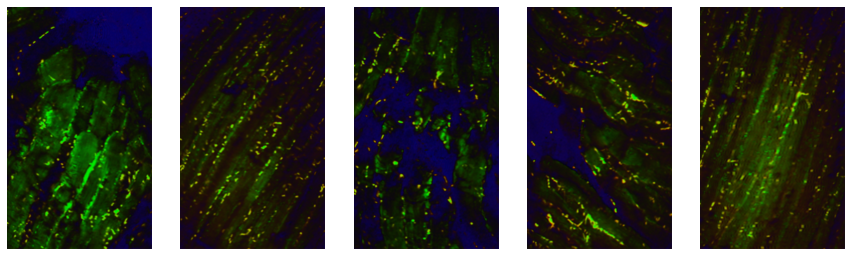

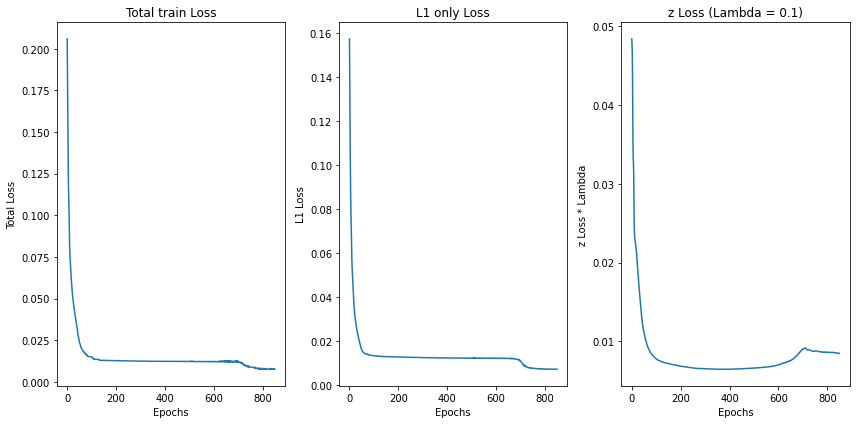

 85%|██████████████████████████████████      | 851/1000 [04:36<01:03,  2.36it/s]

Epoch: 851 	Training Loss Total: 0.007566 	L1 only: 0.007158 	Z Loss*Lambda: 0.008473


 85%|██████████████████████████████████      | 852/1000 [04:37<00:58,  2.55it/s]

Epoch: 852 	Training Loss Total: 0.007550 	L1 only: 0.007143 	Z Loss*Lambda: 0.008475


 85%|██████████████████████████████████      | 853/1000 [04:37<00:54,  2.71it/s]

Epoch: 853 	Training Loss Total: 0.007553 	L1 only: 0.007147 	Z Loss*Lambda: 0.008475


 85%|██████████████████████████████████▏     | 854/1000 [04:37<00:51,  2.83it/s]

Epoch: 854 	Training Loss Total: 0.007532 	L1 only: 0.007127 	Z Loss*Lambda: 0.008476


 86%|██████████████████████████████████▏     | 855/1000 [04:38<00:49,  2.91it/s]

Epoch: 855 	Training Loss Total: 0.007921 	L1 only: 0.007116 	Z Loss*Lambda: 0.008451


 86%|██████████████████████████████████▏     | 856/1000 [04:38<00:48,  2.98it/s]

Epoch: 856 	Training Loss Total: 0.007512 	L1 only: 0.007108 	Z Loss*Lambda: 0.008414


 86%|██████████████████████████████████▎     | 857/1000 [04:38<00:47,  3.02it/s]

Epoch: 857 	Training Loss Total: 0.007549 	L1 only: 0.007144 	Z Loss*Lambda: 0.008419


 86%|██████████████████████████████████▎     | 858/1000 [04:39<00:46,  3.06it/s]

Epoch: 858 	Training Loss Total: 0.007534 	L1 only: 0.007130 	Z Loss*Lambda: 0.008427


 86%|██████████████████████████████████▎     | 859/1000 [04:39<00:45,  3.08it/s]

Epoch: 859 	Training Loss Total: 0.007553 	L1 only: 0.007148 	Z Loss*Lambda: 0.008429


 86%|██████████████████████████████████▍     | 860/1000 [04:39<00:45,  3.10it/s]

Epoch: 860 	Training Loss Total: 0.007544 	L1 only: 0.007140 	Z Loss*Lambda: 0.008431


 86%|██████████████████████████████████▍     | 861/1000 [04:40<00:44,  3.11it/s]

Epoch: 861 	Training Loss Total: 0.007544 	L1 only: 0.007140 	Z Loss*Lambda: 0.008432


 86%|██████████████████████████████████▍     | 862/1000 [04:40<00:44,  3.12it/s]

Epoch: 862 	Training Loss Total: 0.007554 	L1 only: 0.007149 	Z Loss*Lambda: 0.008432


 86%|██████████████████████████████████▌     | 863/1000 [04:40<00:43,  3.13it/s]

Epoch: 863 	Training Loss Total: 0.007537 	L1 only: 0.007133 	Z Loss*Lambda: 0.008432


 86%|██████████████████████████████████▌     | 864/1000 [04:41<00:43,  3.13it/s]

Epoch: 864 	Training Loss Total: 0.007919 	L1 only: 0.007117 	Z Loss*Lambda: 0.008408


 86%|██████████████████████████████████▌     | 865/1000 [04:41<00:43,  3.14it/s]

Epoch: 865 	Training Loss Total: 0.007537 	L1 only: 0.007135 	Z Loss*Lambda: 0.008369


 87%|██████████████████████████████████▋     | 866/1000 [04:41<00:42,  3.14it/s]

Epoch: 866 	Training Loss Total: 0.007540 	L1 only: 0.007139 	Z Loss*Lambda: 0.008375


 87%|██████████████████████████████████▋     | 867/1000 [04:41<00:42,  3.14it/s]

Epoch: 867 	Training Loss Total: 0.007519 	L1 only: 0.007117 	Z Loss*Lambda: 0.008382


 87%|██████████████████████████████████▋     | 868/1000 [04:42<00:42,  3.14it/s]

Epoch: 868 	Training Loss Total: 0.007530 	L1 only: 0.007128 	Z Loss*Lambda: 0.008385


 87%|██████████████████████████████████▊     | 869/1000 [04:42<00:41,  3.14it/s]

Epoch: 869 	Training Loss Total: 0.007525 	L1 only: 0.007123 	Z Loss*Lambda: 0.008386


 87%|██████████████████████████████████▊     | 870/1000 [04:42<00:41,  3.14it/s]

Epoch: 870 	Training Loss Total: 0.007513 	L1 only: 0.007112 	Z Loss*Lambda: 0.008387


 87%|██████████████████████████████████▊     | 871/1000 [04:43<00:41,  3.14it/s]

Epoch: 871 	Training Loss Total: 0.007511 	L1 only: 0.007110 	Z Loss*Lambda: 0.008387


 87%|██████████████████████████████████▉     | 872/1000 [04:43<00:40,  3.14it/s]

Epoch: 872 	Training Loss Total: 0.007499 	L1 only: 0.007099 	Z Loss*Lambda: 0.008387


 87%|██████████████████████████████████▉     | 873/1000 [04:43<00:40,  3.14it/s]

Epoch: 873 	Training Loss Total: 0.007502 	L1 only: 0.007101 	Z Loss*Lambda: 0.008386


 87%|██████████████████████████████████▉     | 874/1000 [04:44<00:40,  3.14it/s]

Epoch: 874 	Training Loss Total: 0.007473 	L1 only: 0.007073 	Z Loss*Lambda: 0.008371


 88%|███████████████████████████████████     | 875/1000 [04:44<00:39,  3.14it/s]

Epoch: 875 	Training Loss Total: 0.006993 	L1 only: 0.006993 	Z Loss*Lambda: 0.008373


 88%|███████████████████████████████████     | 876/1000 [04:44<00:39,  3.14it/s]

Epoch: 876 	Training Loss Total: 0.007129 	L1 only: 0.007129 	Z Loss*Lambda: 0.008411


 88%|███████████████████████████████████     | 877/1000 [04:45<00:39,  3.14it/s]

Epoch: 877 	Training Loss Total: 0.007477 	L1 only: 0.007076 	Z Loss*Lambda: 0.008417


 88%|███████████████████████████████████     | 878/1000 [04:45<00:38,  3.14it/s]

Epoch: 878 	Training Loss Total: 0.007240 	L1 only: 0.007240 	Z Loss*Lambda: 0.008409


 88%|███████████████████████████████████▏    | 879/1000 [04:45<00:38,  3.14it/s]

Epoch: 879 	Training Loss Total: 0.007889 	L1 only: 0.007083 	Z Loss*Lambda: 0.008401


 88%|███████████████████████████████████▏    | 880/1000 [04:46<00:38,  3.14it/s]

Epoch: 880 	Training Loss Total: 0.007518 	L1 only: 0.007117 	Z Loss*Lambda: 0.008363


 88%|███████████████████████████████████▏    | 881/1000 [04:46<00:37,  3.14it/s]

Epoch: 881 	Training Loss Total: 0.007521 	L1 only: 0.007120 	Z Loss*Lambda: 0.008360


 88%|███████████████████████████████████▎    | 882/1000 [04:46<00:37,  3.14it/s]

Epoch: 882 	Training Loss Total: 0.007479 	L1 only: 0.007078 	Z Loss*Lambda: 0.008360


 88%|███████████████████████████████████▎    | 883/1000 [04:47<00:37,  3.14it/s]

Epoch: 883 	Training Loss Total: 0.007506 	L1 only: 0.007105 	Z Loss*Lambda: 0.008357


 88%|███████████████████████████████████▎    | 884/1000 [04:47<00:36,  3.14it/s]

Epoch: 884 	Training Loss Total: 0.007494 	L1 only: 0.007094 	Z Loss*Lambda: 0.008353


 88%|███████████████████████████████████▍    | 885/1000 [04:47<00:36,  3.14it/s]

Epoch: 885 	Training Loss Total: 0.007066 	L1 only: 0.007066 	Z Loss*Lambda: 0.008359


 89%|███████████████████████████████████▍    | 886/1000 [04:48<00:36,  3.14it/s]

Epoch: 886 	Training Loss Total: 0.006980 	L1 only: 0.006980 	Z Loss*Lambda: 0.008399


 89%|███████████████████████████████████▍    | 887/1000 [04:48<00:35,  3.14it/s]

Epoch: 887 	Training Loss Total: 0.007362 	L1 only: 0.006962 	Z Loss*Lambda: 0.008409


 89%|███████████████████████████████████▌    | 888/1000 [04:48<00:35,  3.14it/s]

Epoch: 888 	Training Loss Total: 0.007096 	L1 only: 0.007096 	Z Loss*Lambda: 0.008396


 89%|███████████████████████████████████▌    | 889/1000 [04:48<00:35,  3.14it/s]

Epoch: 889 	Training Loss Total: 0.007083 	L1 only: 0.007083 	Z Loss*Lambda: 0.008420


 89%|███████████████████████████████████▌    | 890/1000 [04:49<00:35,  3.14it/s]

Epoch: 890 	Training Loss Total: 0.007595 	L1 only: 0.007195 	Z Loss*Lambda: 0.008421


 89%|███████████████████████████████████▋    | 891/1000 [04:49<00:34,  3.14it/s]

Epoch: 891 	Training Loss Total: 0.007421 	L1 only: 0.007020 	Z Loss*Lambda: 0.008396


 89%|███████████████████████████████████▋    | 892/1000 [04:49<00:34,  3.14it/s]

Epoch: 892 	Training Loss Total: 0.007568 	L1 only: 0.007163 	Z Loss*Lambda: 0.008385


 89%|███████████████████████████████████▋    | 893/1000 [04:50<00:34,  3.14it/s]

Epoch: 893 	Training Loss Total: 0.007520 	L1 only: 0.007118 	Z Loss*Lambda: 0.008377


 89%|███████████████████████████████████▊    | 894/1000 [04:50<00:33,  3.14it/s]

Epoch: 894 	Training Loss Total: 0.007487 	L1 only: 0.007086 	Z Loss*Lambda: 0.008367


 90%|███████████████████████████████████▊    | 895/1000 [04:50<00:33,  3.14it/s]

Epoch: 895 	Training Loss Total: 0.007482 	L1 only: 0.007082 	Z Loss*Lambda: 0.008359


 90%|███████████████████████████████████▊    | 896/1000 [04:51<00:33,  3.14it/s]

Epoch: 896 	Training Loss Total: 0.007052 	L1 only: 0.007052 	Z Loss*Lambda: 0.008359


 90%|███████████████████████████████████▉    | 897/1000 [04:51<00:32,  3.14it/s]

Epoch: 897 	Training Loss Total: 0.006956 	L1 only: 0.006956 	Z Loss*Lambda: 0.008396


 90%|███████████████████████████████████▉    | 898/1000 [04:51<00:32,  3.14it/s]

Epoch: 898 	Training Loss Total: 0.007007 	L1 only: 0.007007 	Z Loss*Lambda: 0.008425


 90%|███████████████████████████████████▉    | 899/1000 [04:52<00:32,  3.14it/s]

Epoch: 899 	Training Loss Total: 0.007564 	L1 only: 0.007163 	Z Loss*Lambda: 0.008423
Epoch: 900 	Training Loss Total: 0.006958 	L1 only: 0.006958 	Z Loss*Lambda: 0.008398


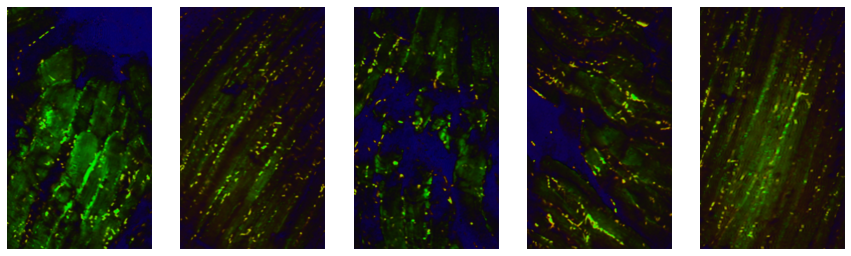

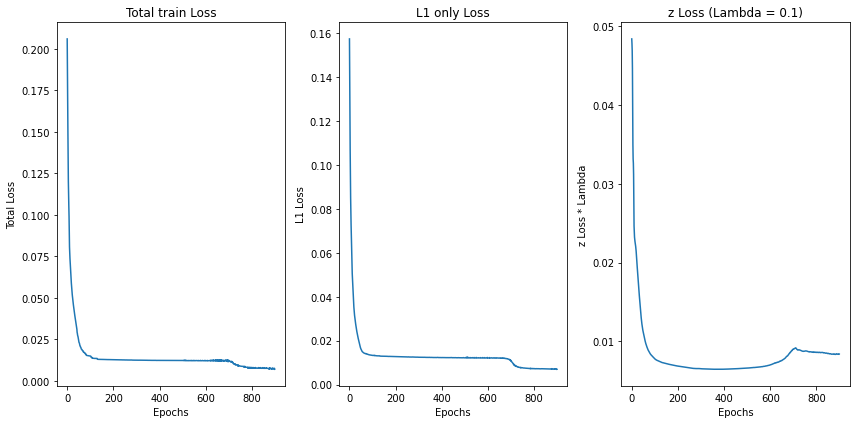

 90%|████████████████████████████████████    | 901/1000 [04:53<00:42,  2.35it/s]

Epoch: 901 	Training Loss Total: 0.006961 	L1 only: 0.006961 	Z Loss*Lambda: 0.008428


 90%|████████████████████████████████████    | 902/1000 [04:53<00:38,  2.55it/s]

Epoch: 902 	Training Loss Total: 0.007580 	L1 only: 0.007180 	Z Loss*Lambda: 0.008431


 90%|████████████████████████████████████    | 903/1000 [04:53<00:35,  2.71it/s]

Epoch: 903 	Training Loss Total: 0.007414 	L1 only: 0.007012 	Z Loss*Lambda: 0.008398


 90%|████████████████████████████████████▏   | 904/1000 [04:54<00:33,  2.83it/s]

Epoch: 904 	Training Loss Total: 0.007570 	L1 only: 0.007166 	Z Loss*Lambda: 0.008380


 90%|████████████████████████████████████▏   | 905/1000 [04:54<00:32,  2.92it/s]

Epoch: 905 	Training Loss Total: 0.007527 	L1 only: 0.007125 	Z Loss*Lambda: 0.008372


 91%|████████████████████████████████████▏   | 906/1000 [04:54<00:31,  2.98it/s]

Epoch: 906 	Training Loss Total: 0.007505 	L1 only: 0.007103 	Z Loss*Lambda: 0.008359


 91%|████████████████████████████████████▎   | 907/1000 [04:55<00:30,  3.03it/s]

Epoch: 907 	Training Loss Total: 0.007062 	L1 only: 0.007062 	Z Loss*Lambda: 0.008357


 91%|████████████████████████████████████▎   | 908/1000 [04:55<00:29,  3.07it/s]

Epoch: 908 	Training Loss Total: 0.006955 	L1 only: 0.006955 	Z Loss*Lambda: 0.008391


 91%|████████████████████████████████████▎   | 909/1000 [04:55<00:29,  3.09it/s]

Epoch: 909 	Training Loss Total: 0.007342 	L1 only: 0.006940 	Z Loss*Lambda: 0.008398


 91%|████████████████████████████████████▍   | 910/1000 [04:56<00:28,  3.11it/s]

Epoch: 910 	Training Loss Total: 0.007065 	L1 only: 0.007065 	Z Loss*Lambda: 0.008388


 91%|████████████████████████████████████▍   | 911/1000 [04:56<00:28,  3.13it/s]

Epoch: 911 	Training Loss Total: 0.007038 	L1 only: 0.007038 	Z Loss*Lambda: 0.008405


 91%|████████████████████████████████████▍   | 912/1000 [04:56<00:28,  3.13it/s]

Epoch: 912 	Training Loss Total: 0.007135 	L1 only: 0.007135 	Z Loss*Lambda: 0.008428


 91%|████████████████████████████████████▌   | 913/1000 [04:57<00:27,  3.14it/s]

Epoch: 913 	Training Loss Total: 0.007351 	L1 only: 0.006949 	Z Loss*Lambda: 0.008421


 91%|████████████████████████████████████▌   | 914/1000 [04:57<00:27,  3.14it/s]

Epoch: 914 	Training Loss Total: 0.006945 	L1 only: 0.006945 	Z Loss*Lambda: 0.008409


 92%|████████████████████████████████████▌   | 915/1000 [04:57<00:27,  3.14it/s]

Epoch: 915 	Training Loss Total: 0.007115 	L1 only: 0.007115 	Z Loss*Lambda: 0.008428


 92%|████████████████████████████████████▋   | 916/1000 [04:58<00:26,  3.14it/s]

Epoch: 916 	Training Loss Total: 0.006990 	L1 only: 0.006990 	Z Loss*Lambda: 0.008446


 92%|████████████████████████████████████▋   | 917/1000 [04:58<00:26,  3.15it/s]

Epoch: 917 	Training Loss Total: 0.007622 	L1 only: 0.007221 	Z Loss*Lambda: 0.008444


 92%|████████████████████████████████████▋   | 918/1000 [04:58<00:26,  3.15it/s]

Epoch: 918 	Training Loss Total: 0.007496 	L1 only: 0.007090 	Z Loss*Lambda: 0.008409


 92%|████████████████████████████████████▊   | 919/1000 [04:59<00:25,  3.15it/s]

Epoch: 919 	Training Loss Total: 0.007540 	L1 only: 0.007135 	Z Loss*Lambda: 0.008386


 92%|████████████████████████████████████▊   | 920/1000 [04:59<00:25,  3.15it/s]

Epoch: 920 	Training Loss Total: 0.007508 	L1 only: 0.007107 	Z Loss*Lambda: 0.008374


 92%|████████████████████████████████████▊   | 921/1000 [04:59<00:25,  3.15it/s]

Epoch: 921 	Training Loss Total: 0.007479 	L1 only: 0.007077 	Z Loss*Lambda: 0.008357


 92%|████████████████████████████████████▉   | 922/1000 [04:59<00:24,  3.15it/s]

Epoch: 922 	Training Loss Total: 0.007030 	L1 only: 0.007030 	Z Loss*Lambda: 0.008352


 92%|████████████████████████████████████▉   | 923/1000 [05:00<00:24,  3.15it/s]

Epoch: 923 	Training Loss Total: 0.006927 	L1 only: 0.006927 	Z Loss*Lambda: 0.008382


 92%|████████████████████████████████████▉   | 924/1000 [05:00<00:24,  3.15it/s]

Epoch: 924 	Training Loss Total: 0.007026 	L1 only: 0.007026 	Z Loss*Lambda: 0.008407


 92%|█████████████████████████████████████   | 925/1000 [05:00<00:23,  3.15it/s]

Epoch: 925 	Training Loss Total: 0.007073 	L1 only: 0.007073 	Z Loss*Lambda: 0.008426


 93%|█████████████████████████████████████   | 926/1000 [05:01<00:23,  3.15it/s]

Epoch: 926 	Training Loss Total: 0.007449 	L1 only: 0.007048 	Z Loss*Lambda: 0.008416


 93%|█████████████████████████████████████   | 927/1000 [05:01<00:23,  3.15it/s]

Epoch: 927 	Training Loss Total: 0.007100 	L1 only: 0.007100 	Z Loss*Lambda: 0.008398


 93%|█████████████████████████████████████   | 928/1000 [05:01<00:22,  3.15it/s]

Epoch: 928 	Training Loss Total: 0.006983 	L1 only: 0.006983 	Z Loss*Lambda: 0.008412


 93%|█████████████████████████████████████▏  | 929/1000 [05:02<00:22,  3.15it/s]

Epoch: 929 	Training Loss Total: 0.007524 	L1 only: 0.007124 	Z Loss*Lambda: 0.008415


 93%|█████████████████████████████████████▏  | 930/1000 [05:02<00:22,  3.15it/s]

Epoch: 930 	Training Loss Total: 0.006934 	L1 only: 0.006934 	Z Loss*Lambda: 0.008392


 93%|█████████████████████████████████████▏  | 931/1000 [05:02<00:21,  3.15it/s]

Epoch: 931 	Training Loss Total: 0.006934 	L1 only: 0.006934 	Z Loss*Lambda: 0.008416


 93%|█████████████████████████████████████▎  | 932/1000 [05:03<00:21,  3.15it/s]

Epoch: 932 	Training Loss Total: 0.007112 	L1 only: 0.007112 	Z Loss*Lambda: 0.008440


 93%|█████████████████████████████████████▎  | 933/1000 [05:03<00:21,  3.15it/s]

Epoch: 933 	Training Loss Total: 0.007339 	L1 only: 0.006939 	Z Loss*Lambda: 0.008429


 93%|█████████████████████████████████████▎  | 934/1000 [05:03<00:20,  3.15it/s]

Epoch: 934 	Training Loss Total: 0.007029 	L1 only: 0.007029 	Z Loss*Lambda: 0.008407


 94%|█████████████████████████████████████▍  | 935/1000 [05:04<00:20,  3.15it/s]

Epoch: 935 	Training Loss Total: 0.007099 	L1 only: 0.007099 	Z Loss*Lambda: 0.008425


 94%|█████████████████████████████████████▍  | 936/1000 [05:04<00:20,  3.15it/s]

Epoch: 936 	Training Loss Total: 0.006971 	L1 only: 0.006971 	Z Loss*Lambda: 0.008441


 94%|█████████████████████████████████████▍  | 937/1000 [05:04<00:19,  3.15it/s]

Epoch: 937 	Training Loss Total: 0.007075 	L1 only: 0.007075 	Z Loss*Lambda: 0.008462


 94%|█████████████████████████████████████▌  | 938/1000 [05:05<00:19,  3.15it/s]

Epoch: 938 	Training Loss Total: 0.007353 	L1 only: 0.006952 	Z Loss*Lambda: 0.008451


 94%|█████████████████████████████████████▌  | 939/1000 [05:05<00:19,  3.15it/s]

Epoch: 939 	Training Loss Total: 0.007090 	L1 only: 0.007090 	Z Loss*Lambda: 0.008429


 94%|█████████████████████████████████████▌  | 940/1000 [05:05<00:19,  3.15it/s]

Epoch: 940 	Training Loss Total: 0.006924 	L1 only: 0.006924 	Z Loss*Lambda: 0.008441


 94%|█████████████████████████████████████▋  | 941/1000 [05:05<00:18,  3.15it/s]

Epoch: 941 	Training Loss Total: 0.006921 	L1 only: 0.006921 	Z Loss*Lambda: 0.008464


 94%|█████████████████████████████████████▋  | 942/1000 [05:06<00:18,  3.15it/s]

Epoch: 942 	Training Loss Total: 0.007452 	L1 only: 0.007052 	Z Loss*Lambda: 0.008457


 94%|█████████████████████████████████████▋  | 943/1000 [05:06<00:18,  3.15it/s]

Epoch: 943 	Training Loss Total: 0.007127 	L1 only: 0.007127 	Z Loss*Lambda: 0.008431


 94%|█████████████████████████████████████▊  | 944/1000 [05:06<00:17,  3.15it/s]

Epoch: 944 	Training Loss Total: 0.006923 	L1 only: 0.006923 	Z Loss*Lambda: 0.008436


 94%|█████████████████████████████████████▊  | 945/1000 [05:07<00:17,  3.15it/s]

Epoch: 945 	Training Loss Total: 0.006959 	L1 only: 0.006959 	Z Loss*Lambda: 0.008461


 95%|█████████████████████████████████████▊  | 946/1000 [05:07<00:17,  3.15it/s]

Epoch: 946 	Training Loss Total: 0.007137 	L1 only: 0.007137 	Z Loss*Lambda: 0.008479


 95%|█████████████████████████████████████▉  | 947/1000 [05:07<00:16,  3.15it/s]

Epoch: 947 	Training Loss Total: 0.007357 	L1 only: 0.006956 	Z Loss*Lambda: 0.008463


 95%|█████████████████████████████████████▉  | 948/1000 [05:08<00:16,  3.15it/s]

Epoch: 948 	Training Loss Total: 0.007081 	L1 only: 0.007081 	Z Loss*Lambda: 0.008437


 95%|█████████████████████████████████████▉  | 949/1000 [05:08<00:16,  3.15it/s]

Epoch: 949 	Training Loss Total: 0.006986 	L1 only: 0.006986 	Z Loss*Lambda: 0.008450
Epoch: 950 	Training Loss Total: 0.007100 	L1 only: 0.007100 	Z Loss*Lambda: 0.008468


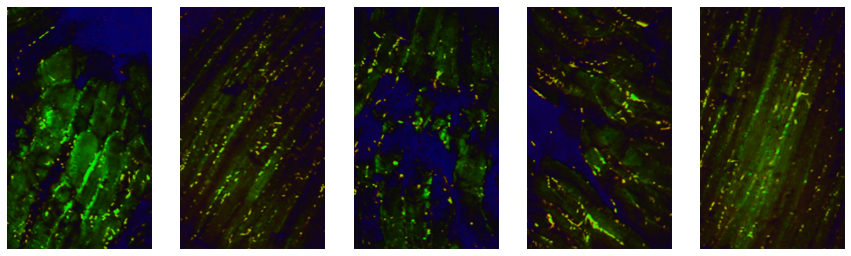

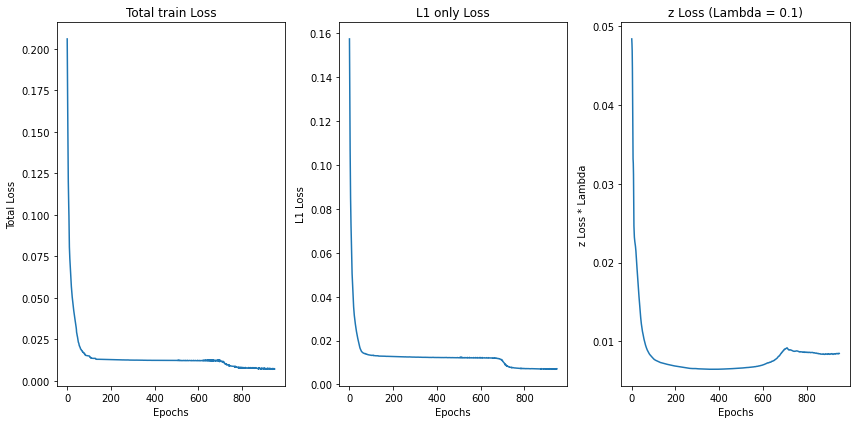

 95%|██████████████████████████████████████  | 951/1000 [05:09<00:21,  2.27it/s]

Epoch: 951 	Training Loss Total: 0.007343 	L1 only: 0.006943 	Z Loss*Lambda: 0.008458


 95%|██████████████████████████████████████  | 952/1000 [05:10<00:19,  2.49it/s]

Epoch: 952 	Training Loss Total: 0.007047 	L1 only: 0.007047 	Z Loss*Lambda: 0.008433


 95%|██████████████████████████████████████  | 953/1000 [05:10<00:17,  2.66it/s]

Epoch: 953 	Training Loss Total: 0.007014 	L1 only: 0.007014 	Z Loss*Lambda: 0.008446


 95%|██████████████████████████████████████▏ | 954/1000 [05:10<00:16,  2.79it/s]

Epoch: 954 	Training Loss Total: 0.007076 	L1 only: 0.007076 	Z Loss*Lambda: 0.008465


 96%|██████████████████████████████████████▏ | 955/1000 [05:11<00:15,  2.89it/s]

Epoch: 955 	Training Loss Total: 0.006968 	L1 only: 0.006968 	Z Loss*Lambda: 0.008477


 96%|██████████████████████████████████████▏ | 956/1000 [05:11<00:14,  2.97it/s]

Epoch: 956 	Training Loss Total: 0.007066 	L1 only: 0.007066 	Z Loss*Lambda: 0.008494


 96%|██████████████████████████████████████▎ | 957/1000 [05:11<00:14,  3.02it/s]

Epoch: 957 	Training Loss Total: 0.007359 	L1 only: 0.006957 	Z Loss*Lambda: 0.008479


 96%|██████████████████████████████████████▎ | 958/1000 [05:11<00:13,  3.06it/s]

Epoch: 958 	Training Loss Total: 0.007072 	L1 only: 0.007072 	Z Loss*Lambda: 0.008454


 96%|██████████████████████████████████████▎ | 959/1000 [05:12<00:13,  3.09it/s]

Epoch: 959 	Training Loss Total: 0.006941 	L1 only: 0.006941 	Z Loss*Lambda: 0.008461


 96%|██████████████████████████████████████▍ | 960/1000 [05:12<00:12,  3.11it/s]

Epoch: 960 	Training Loss Total: 0.007006 	L1 only: 0.007006 	Z Loss*Lambda: 0.008481


 96%|██████████████████████████████████████▍ | 961/1000 [05:12<00:12,  3.12it/s]

Epoch: 961 	Training Loss Total: 0.007458 	L1 only: 0.007058 	Z Loss*Lambda: 0.008471


 96%|██████████████████████████████████████▍ | 962/1000 [05:13<00:12,  3.13it/s]

Epoch: 962 	Training Loss Total: 0.007012 	L1 only: 0.007012 	Z Loss*Lambda: 0.008443


 96%|██████████████████████████████████████▌ | 963/1000 [05:13<00:11,  3.14it/s]

Epoch: 963 	Training Loss Total: 0.006992 	L1 only: 0.006992 	Z Loss*Lambda: 0.008453


 96%|██████████████████████████████████████▌ | 964/1000 [05:13<00:11,  3.14it/s]

Epoch: 964 	Training Loss Total: 0.007030 	L1 only: 0.007030 	Z Loss*Lambda: 0.008472


 96%|██████████████████████████████████████▌ | 965/1000 [05:14<00:11,  3.14it/s]

Epoch: 965 	Training Loss Total: 0.006987 	L1 only: 0.006987 	Z Loss*Lambda: 0.008485


 97%|██████████████████████████████████████▋ | 966/1000 [05:14<00:10,  3.15it/s]

Epoch: 966 	Training Loss Total: 0.007034 	L1 only: 0.007034 	Z Loss*Lambda: 0.008498


 97%|██████████████████████████████████████▋ | 967/1000 [05:14<00:10,  3.14it/s]

Epoch: 967 	Training Loss Total: 0.007391 	L1 only: 0.006990 	Z Loss*Lambda: 0.008484


 97%|██████████████████████████████████████▋ | 968/1000 [05:15<00:10,  3.14it/s]

Epoch: 968 	Training Loss Total: 0.007066 	L1 only: 0.007066 	Z Loss*Lambda: 0.008455


 97%|██████████████████████████████████████▊ | 969/1000 [05:15<00:09,  3.15it/s]

Epoch: 969 	Training Loss Total: 0.006963 	L1 only: 0.006963 	Z Loss*Lambda: 0.008463


 97%|██████████████████████████████████████▊ | 970/1000 [05:15<00:09,  3.15it/s]

Epoch: 970 	Training Loss Total: 0.007047 	L1 only: 0.007047 	Z Loss*Lambda: 0.008480


 97%|██████████████████████████████████████▊ | 971/1000 [05:16<00:09,  3.15it/s]

Epoch: 971 	Training Loss Total: 0.006972 	L1 only: 0.006972 	Z Loss*Lambda: 0.008494


 97%|██████████████████████████████████████▉ | 972/1000 [05:16<00:08,  3.15it/s]

Epoch: 972 	Training Loss Total: 0.007070 	L1 only: 0.007070 	Z Loss*Lambda: 0.008506


 97%|██████████████████████████████████████▉ | 973/1000 [05:16<00:08,  3.15it/s]

Epoch: 973 	Training Loss Total: 0.007354 	L1 only: 0.006953 	Z Loss*Lambda: 0.008489


 97%|██████████████████████████████████████▉ | 974/1000 [05:17<00:08,  3.15it/s]

Epoch: 974 	Training Loss Total: 0.007070 	L1 only: 0.007070 	Z Loss*Lambda: 0.008462


 98%|███████████████████████████████████████ | 975/1000 [05:17<00:07,  3.15it/s]

Epoch: 975 	Training Loss Total: 0.006929 	L1 only: 0.006929 	Z Loss*Lambda: 0.008468


 98%|███████████████████████████████████████ | 976/1000 [05:17<00:07,  3.15it/s]

Epoch: 976 	Training Loss Total: 0.007024 	L1 only: 0.007024 	Z Loss*Lambda: 0.008486


 98%|███████████████████████████████████████ | 977/1000 [05:17<00:07,  3.15it/s]

Epoch: 977 	Training Loss Total: 0.006990 	L1 only: 0.006990 	Z Loss*Lambda: 0.008499


 98%|███████████████████████████████████████ | 978/1000 [05:18<00:06,  3.15it/s]

Epoch: 978 	Training Loss Total: 0.007506 	L1 only: 0.007106 	Z Loss*Lambda: 0.008489


 98%|███████████████████████████████████████▏| 979/1000 [05:18<00:06,  3.15it/s]

Epoch: 979 	Training Loss Total: 0.006914 	L1 only: 0.006914 	Z Loss*Lambda: 0.008453


 98%|███████████████████████████████████████▏| 980/1000 [05:18<00:06,  3.15it/s]

Epoch: 980 	Training Loss Total: 0.007317 	L1 only: 0.006915 	Z Loss*Lambda: 0.008465


 98%|███████████████████████████████████████▏| 981/1000 [05:19<00:06,  3.15it/s]

Epoch: 981 	Training Loss Total: 0.007549 	L1 only: 0.007140 	Z Loss*Lambda: 0.008435


 98%|███████████████████████████████████████▎| 982/1000 [05:19<00:05,  3.15it/s]

Epoch: 982 	Training Loss Total: 0.007521 	L1 only: 0.007113 	Z Loss*Lambda: 0.008407


 98%|███████████████████████████████████████▎| 983/1000 [05:19<00:05,  3.15it/s]

Epoch: 983 	Training Loss Total: 0.007495 	L1 only: 0.007092 	Z Loss*Lambda: 0.008378


 98%|███████████████████████████████████████▎| 984/1000 [05:20<00:05,  3.15it/s]

Epoch: 984 	Training Loss Total: 0.007489 	L1 only: 0.007085 	Z Loss*Lambda: 0.008357


 98%|███████████████████████████████████████▍| 985/1000 [05:20<00:04,  3.15it/s]

Epoch: 985 	Training Loss Total: 0.007446 	L1 only: 0.007046 	Z Loss*Lambda: 0.008336


 99%|███████████████████████████████████████▍| 986/1000 [05:20<00:04,  3.15it/s]

Epoch: 986 	Training Loss Total: 0.006997 	L1 only: 0.006997 	Z Loss*Lambda: 0.008325


 99%|███████████████████████████████████████▍| 987/1000 [05:21<00:04,  3.15it/s]

Epoch: 987 	Training Loss Total: 0.006899 	L1 only: 0.006899 	Z Loss*Lambda: 0.008353


 99%|███████████████████████████████████████▌| 988/1000 [05:21<00:03,  3.15it/s]

Epoch: 988 	Training Loss Total: 0.006882 	L1 only: 0.006882 	Z Loss*Lambda: 0.008377


 99%|███████████████████████████████████████▌| 989/1000 [05:21<00:03,  3.15it/s]

Epoch: 989 	Training Loss Total: 0.006907 	L1 only: 0.006907 	Z Loss*Lambda: 0.008399


 99%|███████████████████████████████████████▌| 990/1000 [05:22<00:03,  3.15it/s]

Epoch: 990 	Training Loss Total: 0.007021 	L1 only: 0.007021 	Z Loss*Lambda: 0.008416


 99%|███████████████████████████████████████▋| 991/1000 [05:22<00:02,  3.15it/s]

Epoch: 991 	Training Loss Total: 0.006970 	L1 only: 0.006970 	Z Loss*Lambda: 0.008429


 99%|███████████████████████████████████████▋| 992/1000 [05:22<00:02,  3.14it/s]

Epoch: 992 	Training Loss Total: 0.007003 	L1 only: 0.007003 	Z Loss*Lambda: 0.008441


 99%|███████████████████████████████████████▋| 993/1000 [05:23<00:02,  3.14it/s]

Epoch: 993 	Training Loss Total: 0.007395 	L1 only: 0.006994 	Z Loss*Lambda: 0.008431


 99%|███████████████████████████████████████▊| 994/1000 [05:23<00:01,  3.15it/s]

Epoch: 994 	Training Loss Total: 0.006985 	L1 only: 0.006985 	Z Loss*Lambda: 0.008401


100%|███████████████████████████████████████▊| 995/1000 [05:23<00:01,  3.14it/s]

Epoch: 995 	Training Loss Total: 0.007000 	L1 only: 0.007000 	Z Loss*Lambda: 0.008415


100%|███████████████████████████████████████▊| 996/1000 [05:24<00:01,  3.14it/s]

Epoch: 996 	Training Loss Total: 0.006961 	L1 only: 0.006961 	Z Loss*Lambda: 0.008431


100%|███████████████████████████████████████▉| 997/1000 [05:24<00:00,  3.14it/s]

Epoch: 997 	Training Loss Total: 0.007025 	L1 only: 0.007025 	Z Loss*Lambda: 0.008451


100%|███████████████████████████████████████▉| 998/1000 [05:24<00:00,  3.15it/s]

Epoch: 998 	Training Loss Total: 0.007371 	L1 only: 0.006970 	Z Loss*Lambda: 0.008436


100%|███████████████████████████████████████▉| 999/1000 [05:24<00:00,  3.15it/s]

Epoch: 999 	Training Loss Total: 0.007050 	L1 only: 0.007050 	Z Loss*Lambda: 0.008414
Epoch: 1000 	Training Loss Total: 0.006946 	L1 only: 0.006946 	Z Loss*Lambda: 0.008419


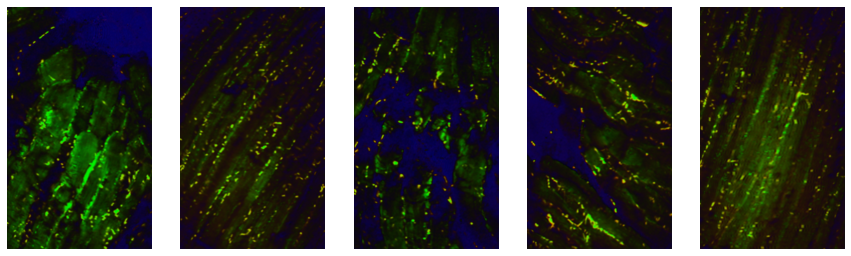

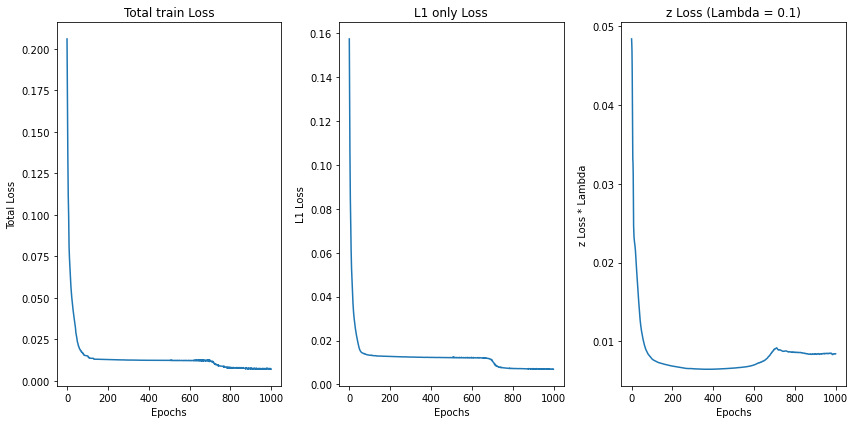

100%|███████████████████████████████████████| 1000/1000 [05:25<00:00,  3.07it/s]


In [13]:
n_epochs = 1000
train_loss_arr = []
l1_loss_arr = []
z_loss_arr = []
z_imgs = []
temp_img_arr = []
# scheduler = StepLR(optimizer, step_size=50, gamma=0.9, verbose = True)
Lambda = 0.1
thr = 0.1

for epoch in tqdm(range(1, n_epochs+1)):
    # monitor training loss
    train_loss = 0.0
    l1_loss = 0.0
    z_loss = 0.0

    #Training
    for images in img_stack:
        images = images[None, :]
        image_x_p = torch.permute(images, (0, 3, 1, 2))
        image_x_p = image_x_p.to(device)
        optimizer.zero_grad() 
        z = model.forward_enc(image_x_p)
        outputs = model.decoder(z)
        loss_l1 = criterion(outputs, image_x_p)
        loss_z = torch.mean(torch.abs(z))
        loss_total = loss_l1 + (Lambda*(loss_z>thr)*loss_z)
        loss_total.backward()
        optimizer.step()
        
        train_loss += loss_total.item()*image_x_p.size(0)
        l1_loss += loss_l1.item()*image_x_p.size(0)
        z_loss += loss_z.item()*image_x_p.size(0)

    train_loss = train_loss/len(img_stack)
    l1_loss = l1_loss/len(img_stack)
    z_loss = z_loss/len(img_stack)
    print('Epoch: {} \tTraining Loss Total: {:.6f} \tL1 only: {:.6f} \tZ Loss*Lambda: {:.6f}'.format(epoch, 
                                                                                                     train_loss, 
                                                                                                     l1_loss, 
                                                                                                     Lambda*z_loss))
    train_loss_arr.append(train_loss)
    l1_loss_arr.append(l1_loss)
    z_loss_arr.append(z_loss)
#     scheduler.step()
        
    if epoch%50 == 0:
        # visualize latent space
        ind_array = np.arange(0,25,5)
        for i in ind_array:
            temp_img = visualize_z(i)
            temp_img_arr.append(temp_img)
        
        z_imgs.append(temp_img_arr)
        
        plt.figure(figsize=(15,5))
        for k in range(0,5):
            plt.subplot(1,5,k+1)
            plt.imshow(temp_img_arr[k])
            plt.axis('off')
        plt.show()
        temp_img_arr = []
        
        
        # making subplots
        fig, ax = plt.subplots(1, 3)
        fig.set_size_inches(12,6)
        # set data with subplots and plot
        ax[0].plot(train_loss_arr)
        ax[0].set_title('Total train Loss')
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Total Loss')
        
        ax[1].plot(l1_loss_arr)
        ax[1].set_title('L1 only Loss')
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('L1 Loss')
        
        ax[2].plot([Lambda*float(x) for x in z_loss_arr])
        ax[2].set_title('z Loss (Lambda = {})'.format(Lambda))
        ax[2].set_xlabel('Epochs')
        ax[2].set_ylabel('z Loss * Lambda')
        
        fig.tight_layout()
        plt.show()
        

In [14]:
# torch.save(model,'/home/arya1080/python_projects/CNN_TAM/20220310_1')

In [15]:
# model = torch.load('/home/arya1080/python_projects/CNN_TAM/20220310_1')

# Analyze latent space images

In [16]:
# z_imgs = np.asarray(z_imgs)
# print(z_imgs.shape)

In [17]:
# plt.figure(figsize=(8,8))
# plt.imshow(z_imgs[39,3,:,:,:])
# plt.show()

In [18]:
# z_imgs = z_imgs[:,0,:,:]
# print(z_imgs.shape)

In [19]:
# iterate through the latent space image stack and save the images
# n_count = 0
# for img in z_imgs:
#     io.imsave('img' + str(n_count) + '.png', img)
#     n_count = n_count + 1

In [20]:
# use the saved latent space images to create a movie
# image_folder = '/home/arya1080/python_projects/CNN_TAM'
# video_name = 'video.avi'

# images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
# frame = cv2.imread(os.path.join(image_folder, images[0]))
# height, width, layers = frame.shape

# video = cv2.VideoWriter(video_name, 0, 1, (width,height))

# for image in images:
#     video.write(cv2.imread(os.path.join(image_folder, image)))

# cv2.destroyAllWindows()
# video.release()

In [21]:
# plt.figure(figsize=(10,10))
# plt.imshow(img)
# plt.show()

In [22]:
# img = z_imgs[:,:,:]
# # separate the 3 channels out
# r = img[:,:,:,0].ravel()
# g = img[:,:,:,1].ravel()
# b = img[:,:,:,2].ravel()

In [23]:
# # create 2D histogram
# plt.figure(figsize=(12,8))
# plt.hist2d(b, g, bins=(255, 255), cmap=plt.cm.jet)
# plt.ylabel('Green channel')
# plt.xlabel('Blue channel')
# plt.show()